# Import dependencies

In [1]:
#import all 
from pandas.io.parsers import read_csv
import numpy as np
import seaborn as sns
import pandas as pd
import sklearn.cluster as cluster
import matplotlib.pyplot as plt
import collections
import scipy
import matplotlib as mpl

import scanpy as sc
dpi = 50
sc.set_figure_params(dpi=dpi, color_map = 'viridis')
sns.set_style('white')
sns.set_context("talk")
#sns.set_style('ticks')

# Read in dataframes

This is necessary for computing percentages. If these are already computed and saved, move down to 'load computed datasets'.

In [2]:
pathToData = '/Users/m.blotenburg/Documents/Projects/Mouse_Scartrace/Data_analysis/Scar_analysis/20210222_wtTransfectionTest/'

First we have to import all count tables separately, then we will merge them into one dataframe df.

In [3]:
def readInScarPlate(pathToFile, replaceToString):
    scarPlate = read_csv((pathToData + pathToFile),sep = ',', low_memory=False, index_col=(0,1,2,3))
    scarPlate = scarPlate.loc[[idx for idx in scarPlate.index if 'Unknown'!=idx]]
    scarPlate = scarPlate.iloc[1:]
    scarPlate.columns = scarPlate.columns.str.replace((scarPlate.columns[0].rsplit('_',1)[0] + '_'), (replaceToString + '.'))
    scarPlate.index.names = ['chrom','allele','site', 'scar']
    scarPlate.columns = pd.MultiIndex.from_tuples( [ (x.split('.',3)[0], x.split('.',3)[1]) for x in scarPlate.columns] )
    scarPlate = scarPlate[sorted(scarPlate.columns)]
    return scarPlate

In [4]:
path1 = 'MB-msc-transfection-ESCs/count_table_unfilteredBam.csv'
path2 = 'MB-msc-transfection-ESCgastr/count_table_unfilteredBam.csv'




In [5]:
plate1 = readInScarPlate(path1, '1')
plate2 = readInScarPlate(path2, '2')

# Check quality of the data, barcode bleed through etc.

First we will check the barcode bleedthrough. Plates are pooled by column, so every sequencing sample has a maximum of 8 bulk samples - except plate 1 column 3, which has been indexed the same way as plate 2 column 9 - these combined contain 9 bulk samples.

Overview:

plate | number of bulk samples
---|---
plate1c1 | 8
plate1c2 | 8
plate1c3_2c9 | 9 
plate2c1 | 8
plate2c2 | 8
plate2c3 | 8
plate2c4 | 8 
plate2c5 | 8
plate2c6 | 8
plate2c7 | 8
plate2c8 | 8
plate3c1 | 8
plate3c2 | 8
plate3c3 | 6



In [6]:
def plotSumsPlate(plate, colour = 'mediumseagreen'):
    sums_cells = plate.sum(axis=0)
    sns.set(style="white")
    plt.figure(figsize=(10,5))
    ax = sns.barplot(x=sums_cells.index.levels[1], y=sums_cells, color= colour)
    ax.set_title('Plate'+ plate.columns.levels[0][0])
    ax.set(xlabel='Index nr', ylabel='Total counts')
    return ax

<AxesSubplot:title={'center':'Plate2'}, xlabel='Index nr', ylabel='Total counts'>

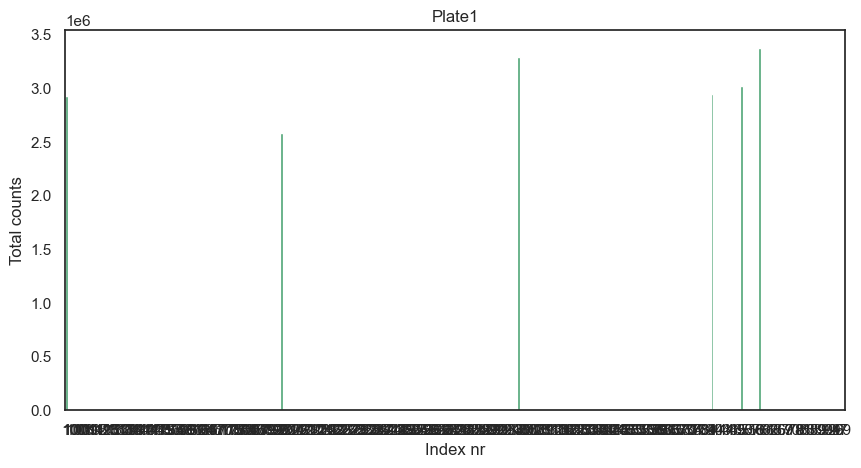

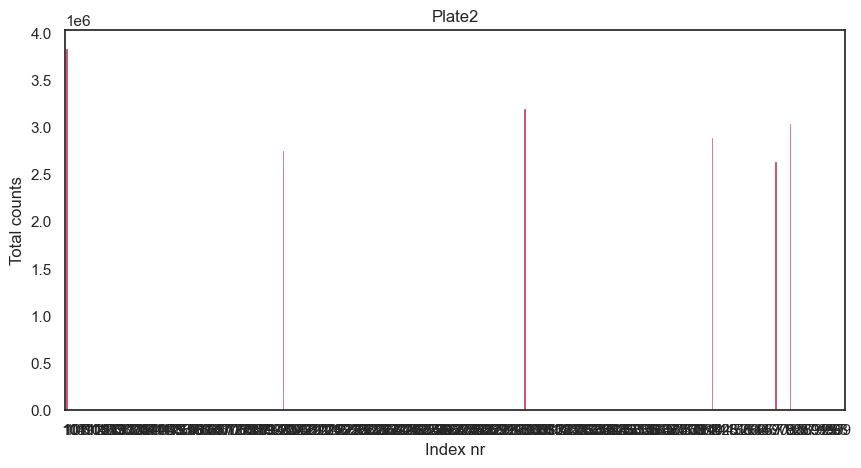

In [7]:
plotSumsPlate(plate1)
plotSumsPlate(plate2, 'crimson')

###### Overview of index numbers for each sample

#### Plate 1

Illumina sample | sample | barcode | number
---|---|---|---
1 | 26/01 mESC 2401 control | MSC11 | 1
1 | 26/01 mESC 2401 transfected | MSC12 | 2
1 | 26/01 mESC 2501 control | MSC13 | 3
1 | 26/01 mESC 2501 transfected | MSC14 | 4
1 | 31/01 mESC 2401 control | MSC15 | 5
1 | 31/01 mESC 2401 transfected | MSC16 | 6
2 | 31/01 mESC 2501 control | MSC17 | 7
2 | 31/01 mESC 2501 transfected | MSC18 | 8
2 | 31/01 gastruloid 2401 control | MSC11 | 1
2 | 31/01 gastruloid 2401 transfected | MSC12 | 2
2 | 31/01 gastruloid 2501 control | MSC13 | 3
2 | 31/01 gastruloid 2501 transfected | MSC14 | 4


In [8]:
# check percentage of reads with correct scar barcode
print('Plate 1: ' + str(plate1['1'][
    ['1','2','3','4','5','6']].sum().sum()/
                        plate1.sum().sum()*100) + ' %')
print('Plate 2: ' + str(plate2['2'][
    ['7','8','1','2','3','4']].sum().sum()/
                        plate2.sum().sum()*100) + ' %')


Plate 1: 99.97896084646572 %
Plate 2: 99.979556632499 %


Now we can merge all samples together into one dataframe 'df', dropping per sample all reads with the incorrect scar barcode.

In [9]:
plate1.columns = plate1.columns.droplevel()

In [10]:
plate2.columns = plate2.columns.droplevel()

In [11]:
numbersToClones1 = {
    '1':'2601_mESC_2401_control',
    '2':'2601_mESC_2401_transfect',
    '3':'2601_mESC_2501_control',
    '4':'2601_mESC_2501_transfect',
    '5':'3101_mESC_2401_control',
    '6':'3101_mESC_2401_transfect'}

numbersToClones2 = {
    '7':'3101_mESC_2501_control',
    '8':'3101_mESC_2501_transfect',
    '1':'3101_gastr_2401_control',
    '2':'3101_gastr_2401_transfect',
    '3':'3101_gastr_2501_control',
    '4':'3101_gastr_2501_transfect'}

plate1.columns = plate1.columns.to_series().map(numbersToClones1)
plate2.columns = plate2.columns.to_series().map(numbersToClones2)



In [12]:
dfs_all = [plate1[['2601_mESC_2401_control',
    '2601_mESC_2401_transfect',
    '2601_mESC_2501_control',
    '2601_mESC_2501_transfect',
    '3101_mESC_2401_control',
    '3101_mESC_2401_transfect']],
           plate2[['3101_mESC_2501_control',
    '3101_mESC_2501_transfect',
    '3101_gastr_2401_control',
    '3101_gastr_2401_transfect',
    '3101_gastr_2501_control',
    '3101_gastr_2501_transfect']],
          ]

df = dfs_all[0].join(dfs_all[1:],how='outer')

Now that we have selected the reads with the correct scar barcode, we can plot the total counts of the final dataframe

### Overview of index numbers and corresponding samples


Barcode | sample 
---|---
1 | 26/01 mESC 2401 control 
2 | 26/01 mESC 2401 transfected
3 | 26/01 mESC 2501 control 
4 | 26/01 mESC 2501 transfected 
5 | 31/01 mESC 2401 control 
6 | 31/01 mESC 2401 transfected 
7 | 31/01 mESC 2501 control 
8 | 31/01 mESC 2501 transfected
1 | 31/01 gastruloid 2401 control 
2 | 31/01 gastruloid 2401 transfected 
3 | 31/01 gastruloid 2501 control 
4 | 31/01 gastruloid 2501 transfected



In [13]:
df.head()

2601_mESC_2401_control  2601_mESC_2401_transfect  \
chrom allele site      scar                                                     
1     None   11261037  WT                       NaN                       NaN   
             54893095  WT                       NaN                       NaN   
             58941247  WT                       NaN                       NaN   
             84164597  WT                       NaN                       NaN   
             134126827 WT                       NaN                       NaN   

                             2601_mESC_2501_control  2601_mESC_2501_transfect  \
chrom allele site      scar                                                     
1     None   11261037  WT                       NaN                       NaN   
             54893095  WT                       NaN                       NaN   
             58941247  WT                       NaN                       NaN   
             84164597  WT                       NaN                       NaN   
             134126827 WT                       NaN                       NaN   

                             3101_mESC_2401_control  3101_mESC_2401_transfect  \
chrom allele site      scar                                                     
1     None   11261037  WT                       NaN                       1.0   
             54893095  WT                       NaN                       1.0   
             58941247  WT                       NaN                       1.0   
             84164597  WT                       NaN                       2.0   
             134126827 WT                       NaN                       1.0   

                             3101_mESC_2501_control  3101_mESC_2501_transfect  \
chrom allele site      scar                                                     
1     None   11261037  WT                       NaN                       NaN   
             54893095  WT                       NaN                       NaN   
             58941247  WT                       NaN                       NaN   
             84164597  WT                       NaN                       NaN   
             134126827 WT                       NaN                       NaN   

                             3101_gastr_2401_control  \
chrom allele site      scar                            
1     None   11261037  WT                        NaN   
             54893095  WT                        NaN   
             58941247  WT                        NaN   
             84164597  WT                        NaN   
             134126827 WT                        NaN   

                             3101_gastr_2401_transfect  \
chrom allele site      scar                              
1     None   11261037  WT                          NaN   
             54893095  WT                          NaN   
             58941247  WT                          NaN   
             84164597  WT                          NaN   
             134126827 WT                          NaN   

                             3101_gastr_2501_control  \
chrom allele site      scar                            
1     None   11261037  WT                        NaN   
             54893095  WT                        NaN   
             58941247  WT                        NaN   
             84164597  WT                        NaN   
             134126827 WT                        NaN   

                             3101_gastr_2501_transfect  
chrom allele site      scar                             
1     None   11261037  WT                          NaN  
             54893095  WT                          NaN  
             58941247  WT                          NaN  
             84164597  WT                          NaN  
             134126827 WT                          NaN

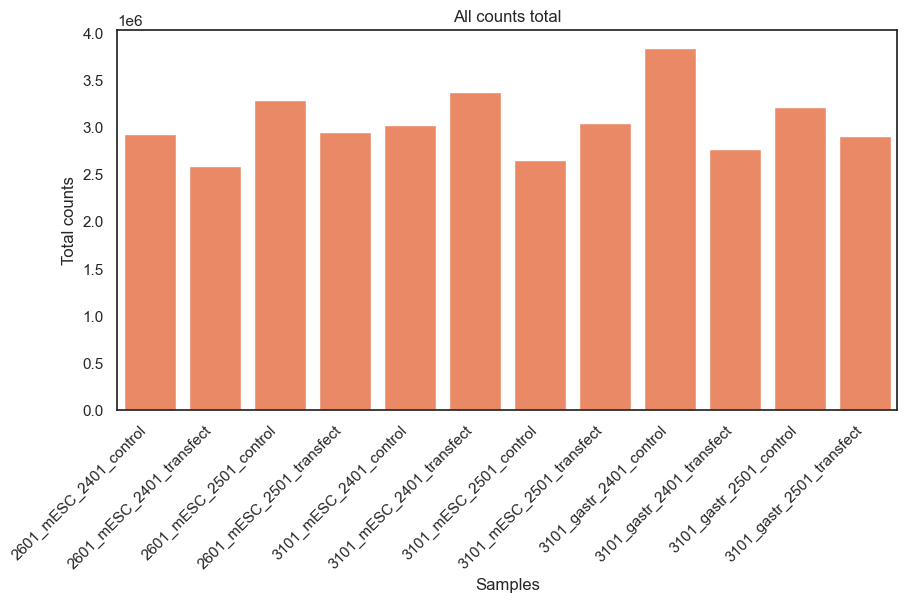

In [14]:
#selected
sums_cells_df = df.sum(axis=0)

sns.set(style="white")
plt.figure(figsize=(10,5))
ax = sns.barplot(x=sums_cells_df.index, y=sums_cells_df,color='coral')
ax.set_title('All counts total')
ax.set(xlabel='Samples', ylabel='Total counts')
plt.xticks(rotation = 45, ha = 'right')
plt.show()

In [15]:
sf = df.loc['12']

sf_129 = sf.loc['129S1_SvImJ']
sf_B6 = sf.loc['C57BL_6NJ']

nonallelic = sf.drop(['C57BL_6NJ','129S1_SvImJ'])

indexNonAllelic = nonallelic.index.droplevel(0)
sf_nonallelic = nonallelic.copy()
sf_nonallelic.index = indexNonAllelic

/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_34166/1195784849.py:6: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  nonallelic = sf.drop(['C57BL_6NJ','129S1_SvImJ'])


# Check counts per allele and gRNA target site

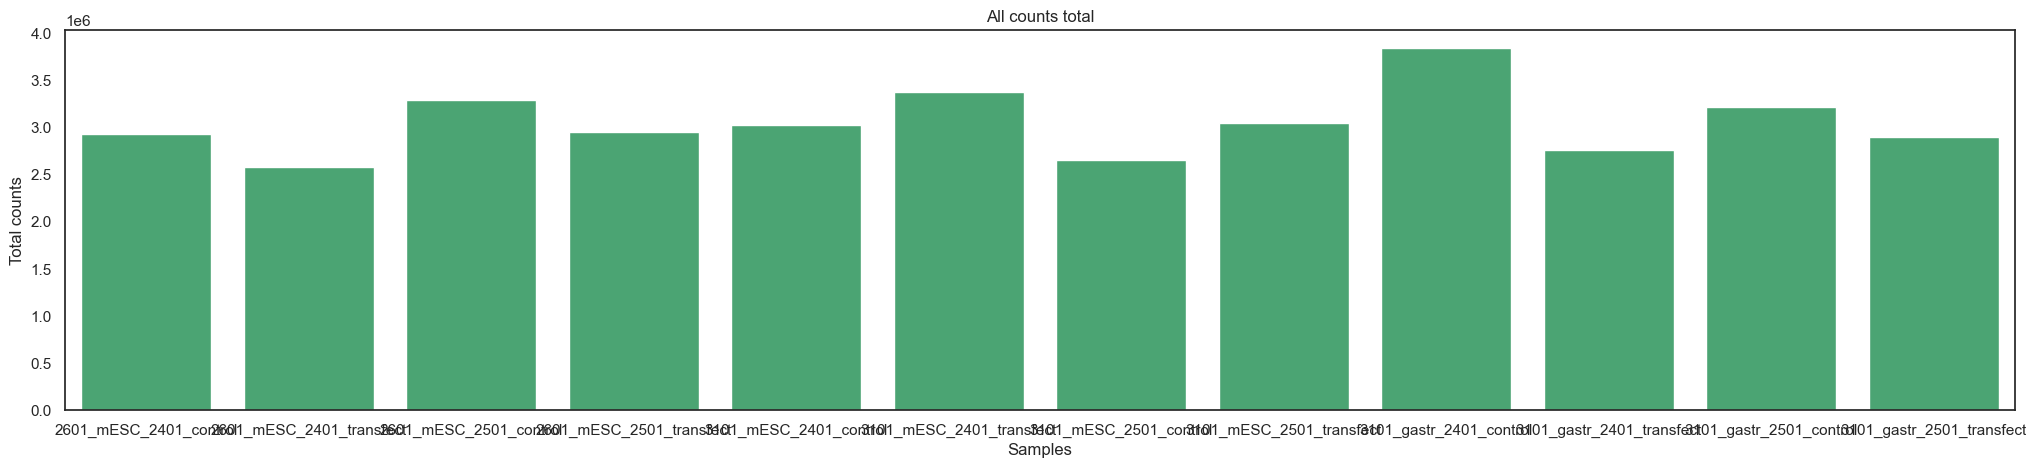

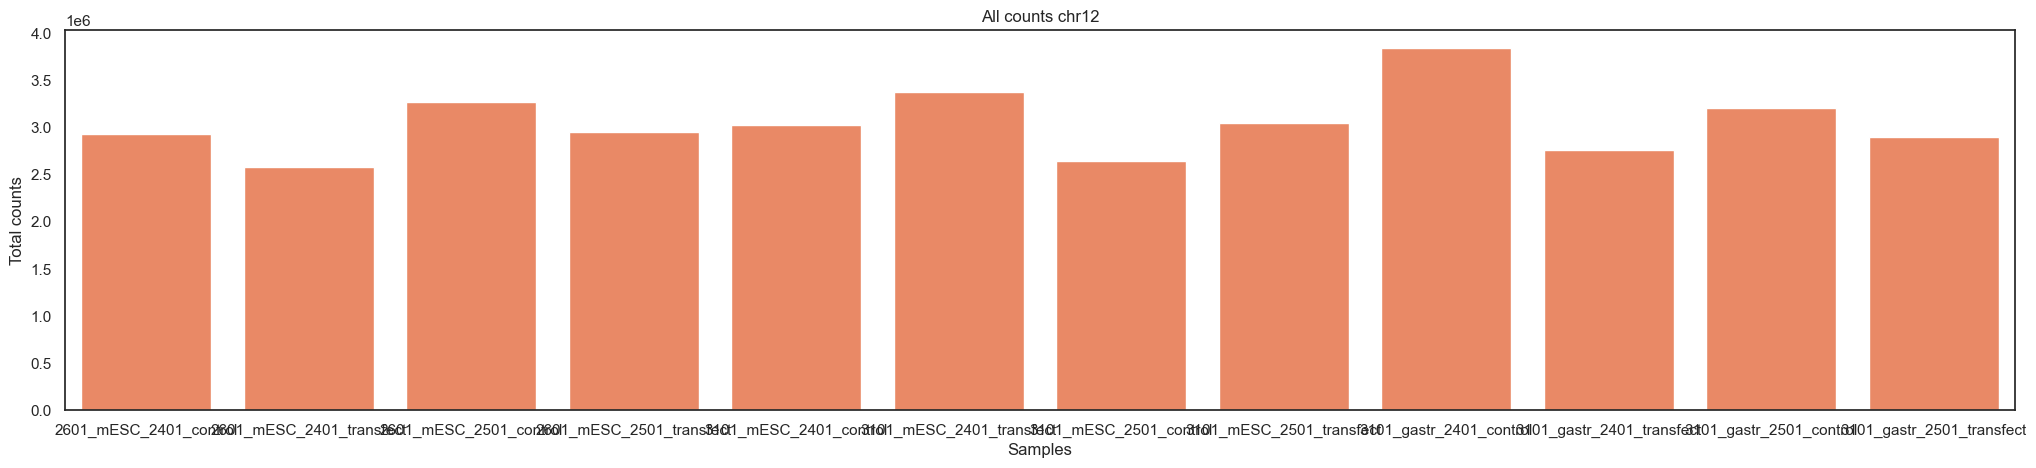

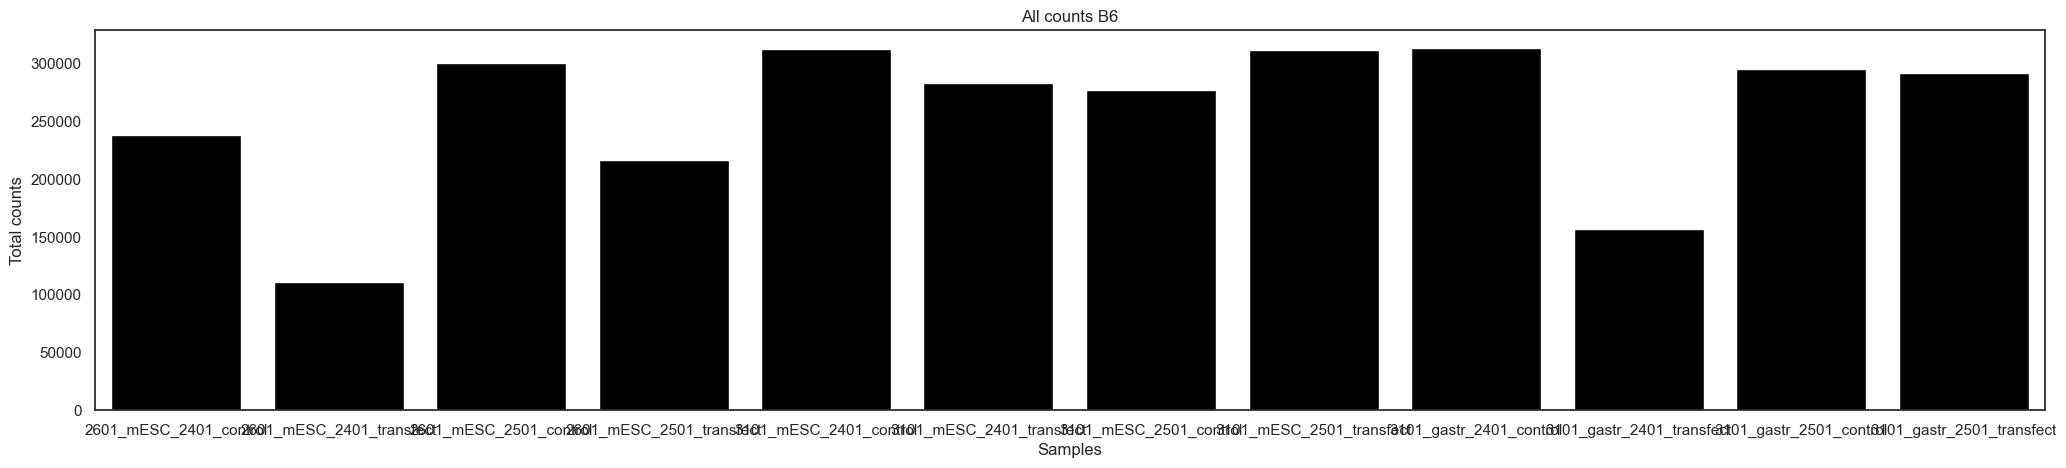

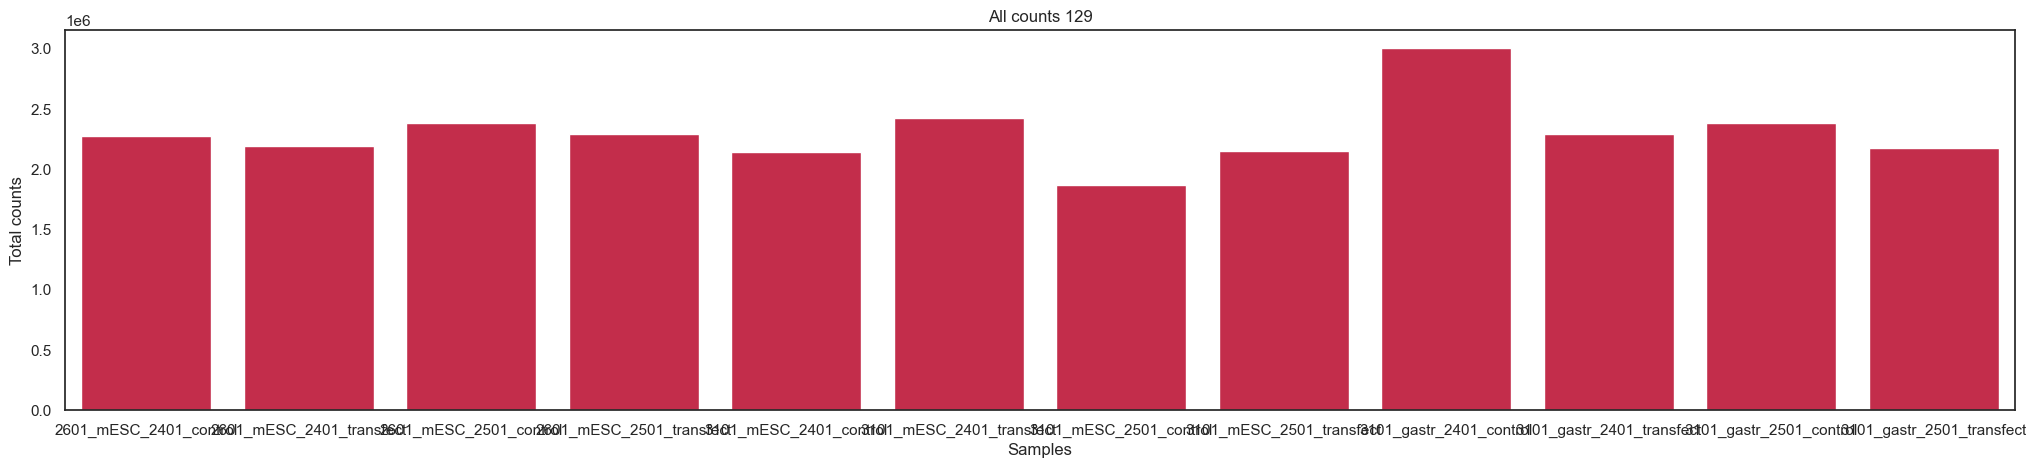

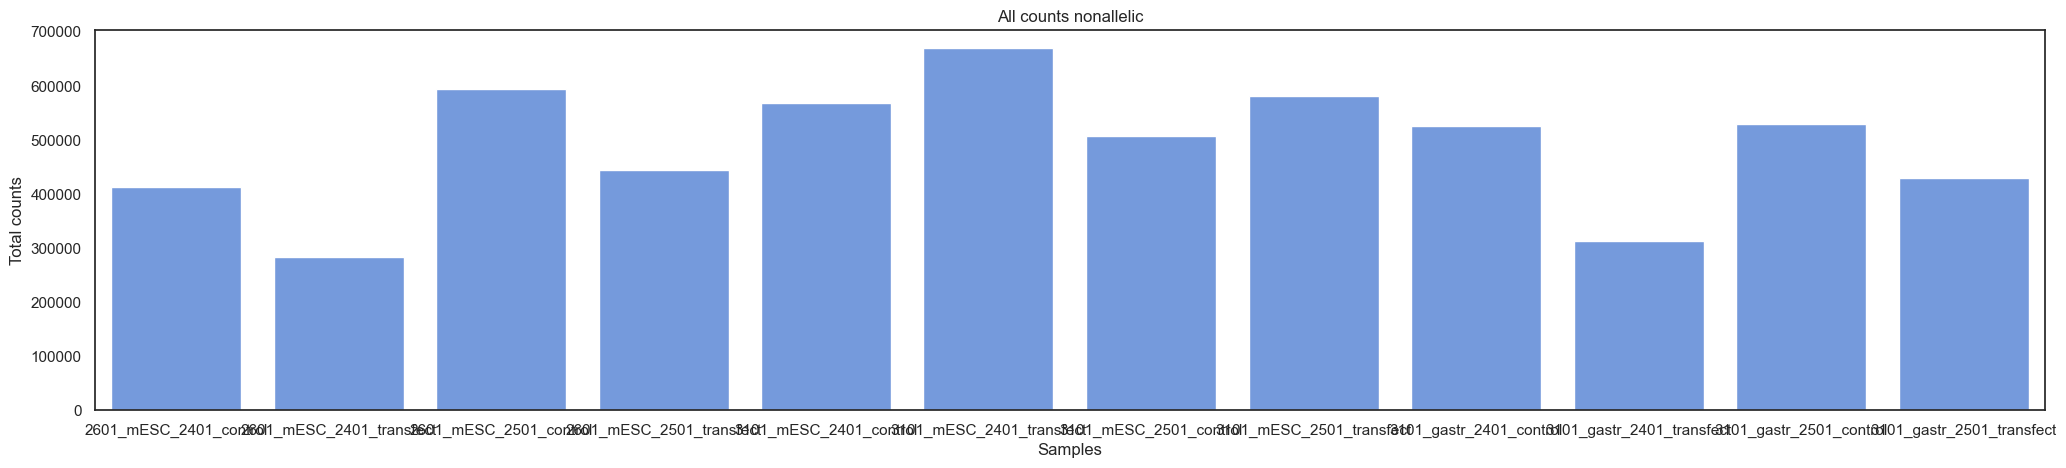

In [16]:
sums_cells_all = df.sum(axis=0)
sums_cells_12 = sf.sum(axis=0)
sums_cells_B6 = sf_B6.sum(axis=0)
sums_cells_129 = sf_129.sum(axis=0)
sums_cells_NA = sf_nonallelic.sum(axis=0)


#all counts total
sns.set(style="white")
plt.figure(figsize=(25,5))
ax = sns.barplot(x=sums_cells_all.index, y=sums_cells_all, color='mediumseagreen')
ax.set_title('All counts total')
ax.set(xlabel='Samples', ylabel='Total counts')
plt.show()

#all counts chromosome 12
sns.set(style="white")
plt.figure(figsize=(25,5))
ax = sns.barplot(x=sums_cells_12.index, y=sums_cells_12, color="coral")
ax.set_title('All counts chr12')
ax.set(xlabel='Samples', ylabel='Total counts')
plt.show()

# all counts per allele
#sf.loc['C57BL_6NJ']
sns.set(style="white")
plt.figure(figsize=(25,5))
ax = sns.barplot(x=sums_cells_B6.index, y=sums_cells_B6, color='black')
ax.set_title('All counts B6')
ax.set(xlabel='Samples', ylabel='Total counts')
plt.show()

#sf.loc['129S1_SvImJ'].sum(axis=0)
sns.set(style="white")
plt.figure(figsize=(25,5))
ax = sns.barplot(x=sums_cells_129.index, y=sums_cells_129, color='crimson')
ax.set_title('All counts 129')
ax.set(xlabel='Samples', ylabel='Total counts')
plt.show()

sns.set(style="white")
plt.figure(figsize=(25,5))
ax = sns.barplot(x=sums_cells_NA.index, y=sums_cells_NA, color='cornflowerblue')
ax.set_title('All counts nonallelic')
ax.set(xlabel='Samples', ylabel='Total counts')
plt.show()

In [17]:
df.sum(level=(1,2)).head()

/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_34166/1254225062.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df.sum(level=(1,2)).head()


2601_mESC_2401_control  2601_mESC_2401_transfect  \
allele site                                                          
None   11261037                      0.0                       0.0   
       54893095                      0.0                       0.0   
       58941247                      0.0                       0.0   
       84164597                      0.0                       0.0   
       134126827                     0.0                       0.0   

                  2601_mESC_2501_control  2601_mESC_2501_transfect  \
allele site                                                          
None   11261037                      0.0                       0.0   
       54893095                      0.0                       0.0   
       58941247                      0.0                       0.0   
       84164597                      0.0                       0.0   
       134126827                     0.0                       0.0   

                  3101_mESC_2401_control  3101_mESC_2401_transfect  \
allele site                                                          
None   11261037                      0.0                       1.0   
       54893095                      0.0                       1.0   
       58941247                      0.0                       1.0   
       84164597                      0.0                       2.0   
       134126827                     0.0                       1.0   

                  3101_mESC_2501_control  3101_mESC_2501_transfect  \
allele site                                                          
None   11261037                      0.0                       0.0   
       54893095                      0.0                       0.0   
       58941247                      0.0                       0.0   
       84164597                      0.0                       0.0   
       134126827                     0.0                       0.0   

                  3101_gastr_2401_control  3101_gastr_2401_transfect  \
allele site                                                            
None   11261037                       0.0                        0.0   
       54893095                       0.0                        0.0   
       58941247                       0.0                        0.0   
       84164597                       0.0                        0.0   
       134126827                      0.0                        0.0   

                  3101_gastr_2501_control  3101_gastr_2501_transfect  
allele site                                                           
None   11261037                       0.0                        0.0  
       54893095                       0.0                        0.0  
       58941247                       0.0                        0.0  
       84164597                       0.0                        0.0  
       134126827                      0.0                        0.0

In [18]:
targetsites = [114682729, 14708745, 114723869, 114740505,114746371, 114788470, 114843748, 114851288,
          114879985,114896335,114910108,114914696,114736342]

In [19]:
#dropping levels chr12 allele specific
index129 = sf_129.index.droplevel(1)
totalcountspersite_129 = sf_129.copy()
totalcountspersite_129.index = index129
sums_cells_129 = totalcountspersite_129.sum(axis=1)
sums_cells_129_merged = sums_cells_129.groupby('site').sum()

indexB6 = sf_B6.index.droplevel(1)
totalcountspersite_B6 = sf_B6.copy()
totalcountspersite_B6.index = indexB6
sums_cells_B6 = totalcountspersite_B6.sum(axis=1)
sums_cells_B6_merged = sums_cells_B6.groupby('site').sum()

indexNA = sf_nonallelic.index.droplevel(1)
totalcountspersite_NA = sf_nonallelic.copy()
totalcountspersite_NA.index = indexNA
sums_cells_NA = totalcountspersite_NA.sum(axis=1)
sums_cells_NA_merged = sums_cells_NA.groupby('site').sum()

sums_cells_B6_merged = sums_cells_B6_merged[sorted(sums_cells_B6_merged.index)]
sums_cells_B6_merged_pd = pd.DataFrame(sums_cells_B6_merged)
sums_cells_129_merged = sums_cells_129_merged[sorted(sums_cells_129_merged.index)]
sums_cells_129_merged_pd = pd.DataFrame(sums_cells_129_merged)
sums_cells_NA_merged = sums_cells_NA_merged[sorted(sums_cells_NA_merged.index)]
sums_cells_NA_merged_pd = pd.DataFrame(sums_cells_NA_merged)

#B6_129_countspersite = sums_cells_B6_merged_pd.merge(sums_cells_129_merged_pd, on='site')
B6_129_countspersite = pd.concat([sums_cells_B6_merged_pd,sums_cells_129_merged_pd, sums_cells_NA_merged_pd], axis=1, sort=True)
B6_129_countspersite.columns = ['B6', '129', 'NA']
B6_129_countspersite = B6_129_countspersite.fillna(0)

In [20]:
df.sum(level=(1,2)).filter(regex=r'11468272', axis=0)

/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_34166/2087976107.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  df.sum(level=(1,2)).filter(regex=r'11468272', axis=0)


2601_mESC_2401_control  2601_mESC_2401_transfect  \
allele      site                                                          
129S1_SvImJ 114682728                     0.0                       0.0   

                       2601_mESC_2501_control  2601_mESC_2501_transfect  \
allele      site                                                          
129S1_SvImJ 114682728                     0.0                       0.0   

                       3101_mESC_2401_control  3101_mESC_2401_transfect  \
allele      site                                                          
129S1_SvImJ 114682728                     0.0                       0.0   

                       3101_mESC_2501_control  3101_mESC_2501_transfect  \
allele      site                                                          
129S1_SvImJ 114682728                     1.0                       0.0   

                       3101_gastr_2401_control  3101_gastr_2401_transfect  \
allele      site                                                            
129S1_SvImJ 114682728                      0.0                        1.0   

                       3101_gastr_2501_control  3101_gastr_2501_transfect  
allele      site                                                           
129S1_SvImJ 114682728                      2.0                        0.0

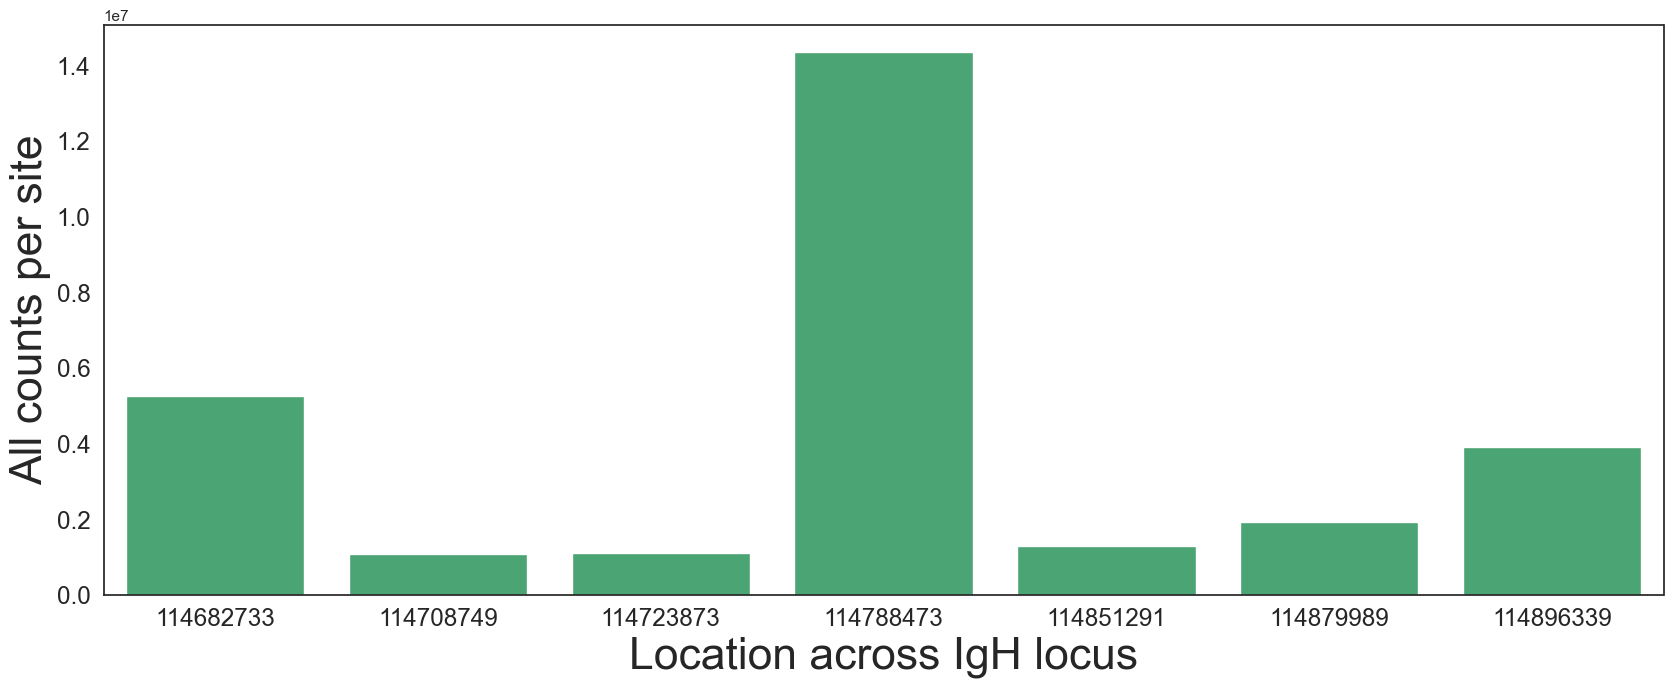

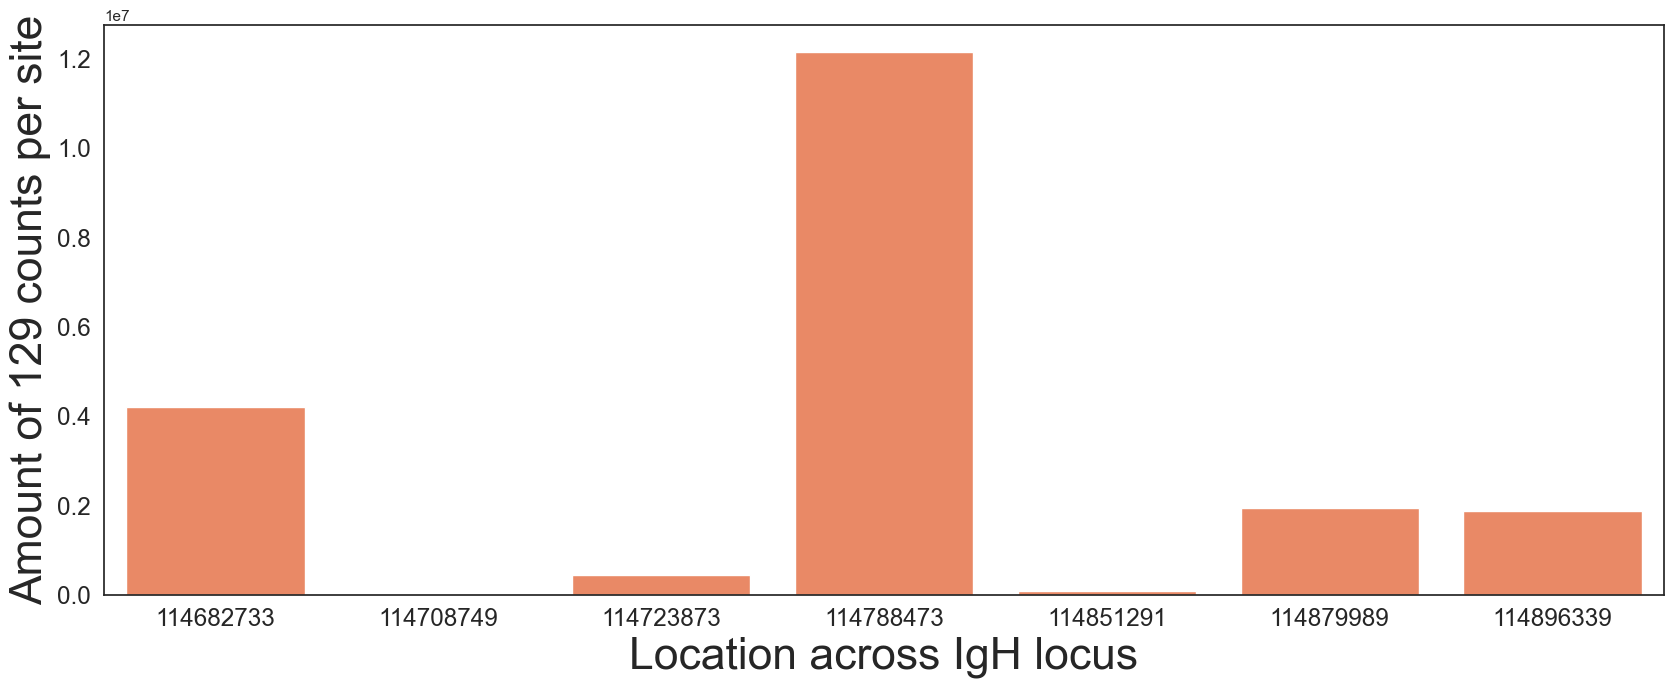

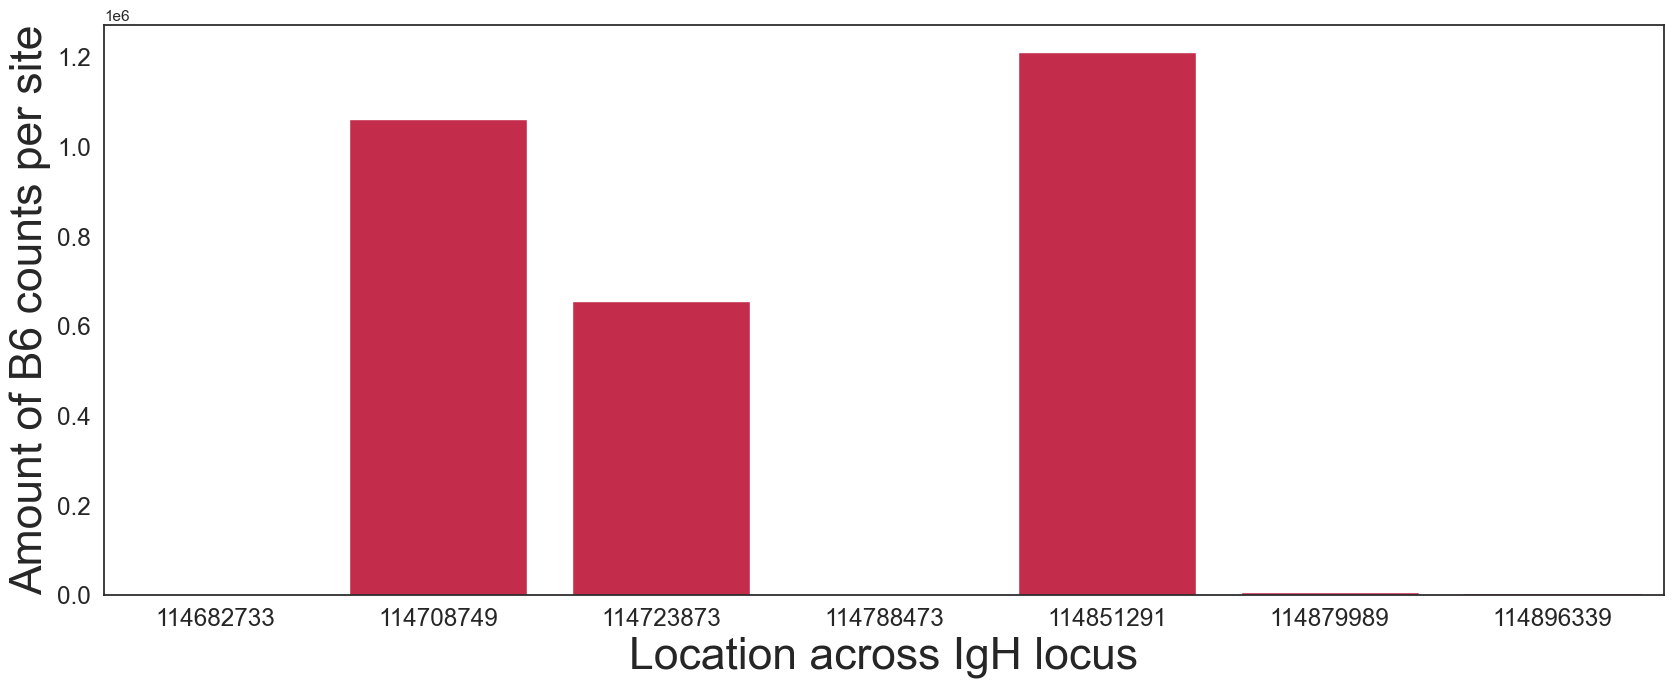

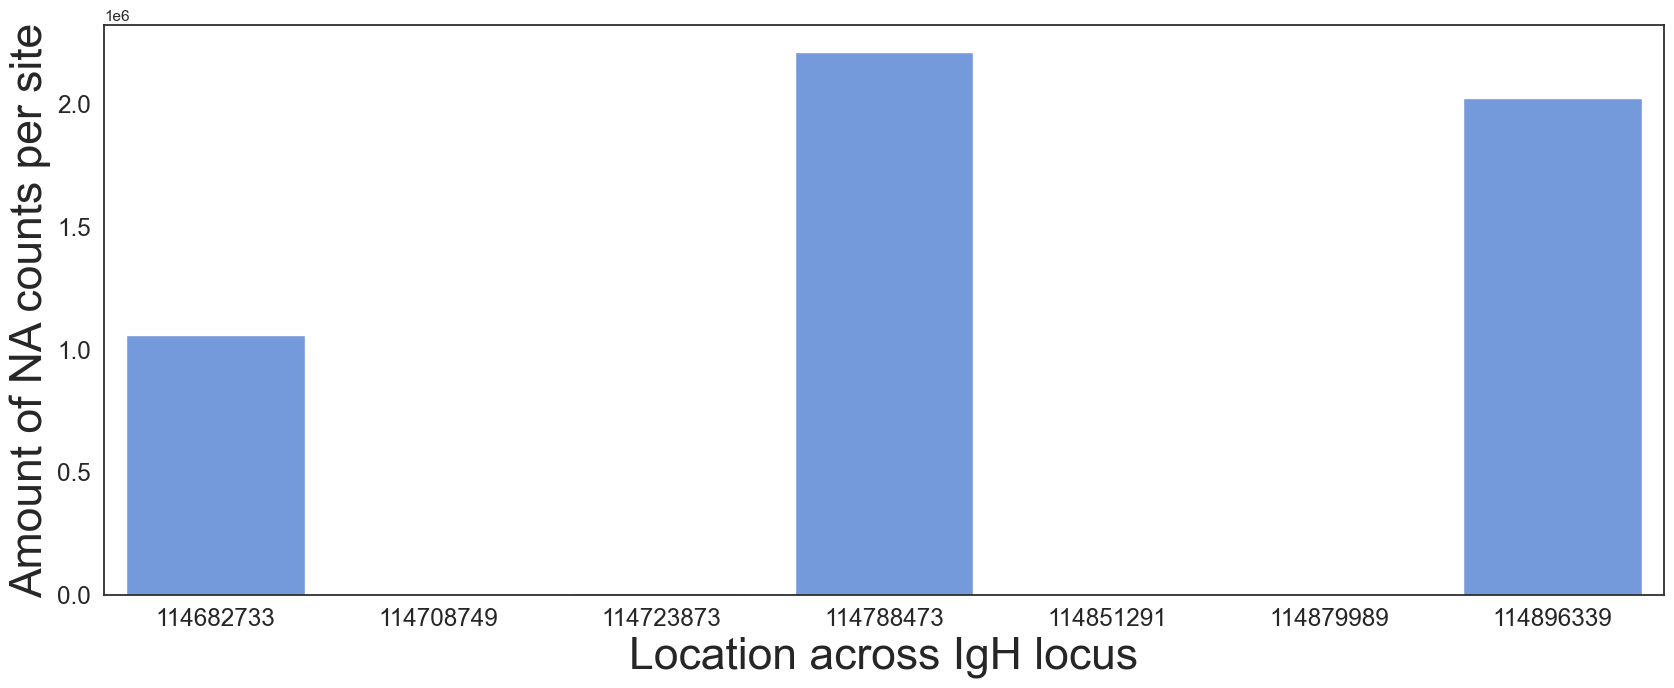

In [21]:

selectedrawcounts = B6_129_countspersite.loc[['114682733','114708749', '114723873','114788473', 
                                              '114851291','114879989', '114896339']]
       
#### All counts for scarred sites
indexAllSites12 = sf.index.droplevel(0)
allSites12 = sf.copy()
allSites12.index = indexAllSites12

indexAllSitesChr12 = allSites12.index.droplevel(1)
allSitesChr12 = allSites12.copy()
allSitesChr12.index = indexAllSitesChr12
allSitesChr12

sums_cells_all = allSitesChr12.sum(axis=1)
sums_cells_all
sums_cells_all_merged = sums_cells_all.groupby('site').sum()

sums_cells_all_merged = sums_cells_all_merged[sorted(sums_cells_all_merged.index)]
sums_cells_all_merged_pd = pd.DataFrame(sums_cells_all_merged)

selectedrawcountsforall = sums_cells_all_merged_pd.loc[['114682733','114708749', '114723873','114788473', 
                                              '114851291','114879989', '114896339']]
selectedrawcountsforall.columns = ['All']

sns.set(style="white")
plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedrawcountsforall.index, y=selectedrawcountsforall['All'], color='mediumseagreen')

plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('All counts per site', fontsize=32)
ax.tick_params(labelsize=17.5)
plt.show()

#### All counts per allele for scarred sites
sns.set(style="white")
plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedrawcounts.index, y=selectedrawcounts['129'], color='coral')
ax.tick_params(labelsize=17.5)
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('Amount of 129 counts per site', fontsize=32)
plt.show()

sns.set(style="white")
plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedrawcounts.index, y=selectedrawcounts['B6'], color='crimson')
ax.tick_params(labelsize=17.5)
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('Amount of B6 counts per site', fontsize=32)
plt.show()

sns.set(style="white")
plt.figure(figsize=(20,7.5))
ax = sns.barplot(x=selectedrawcounts.index, y=selectedrawcounts['NA'], color='cornflowerblue')
ax.tick_params(labelsize=17.5)
plt.xlabel('Location across IgH locus', fontsize=32); plt.ylabel('Amount of NA counts per site', fontsize=32)
plt.show()

/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_34166/1067480357.py:2: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  sums_cells = df.sum(axis=0, level=0)


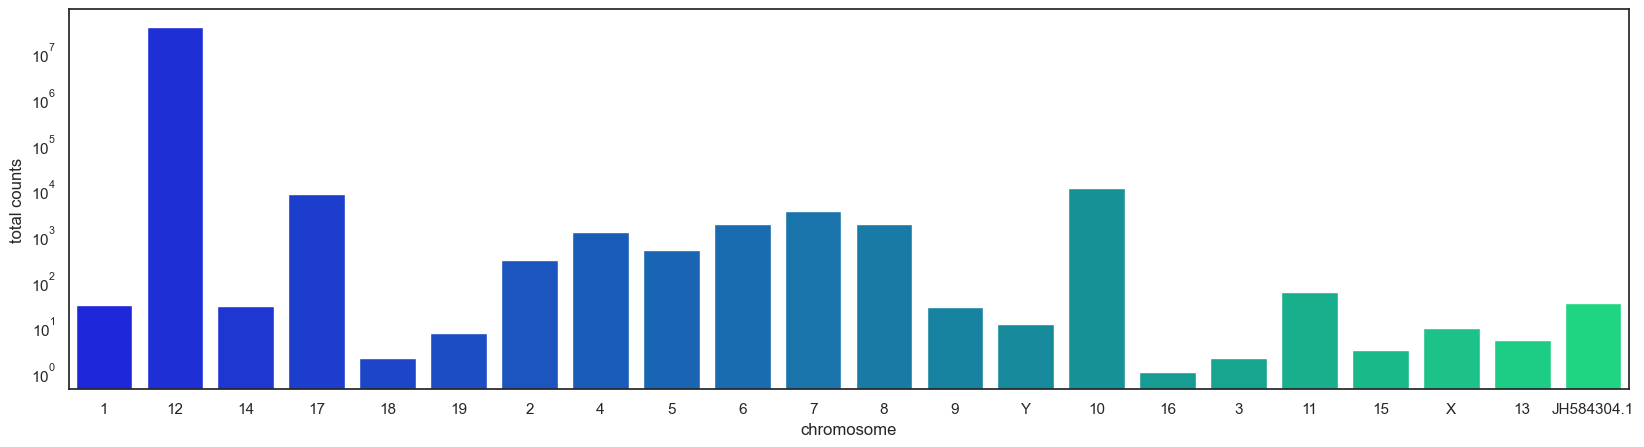

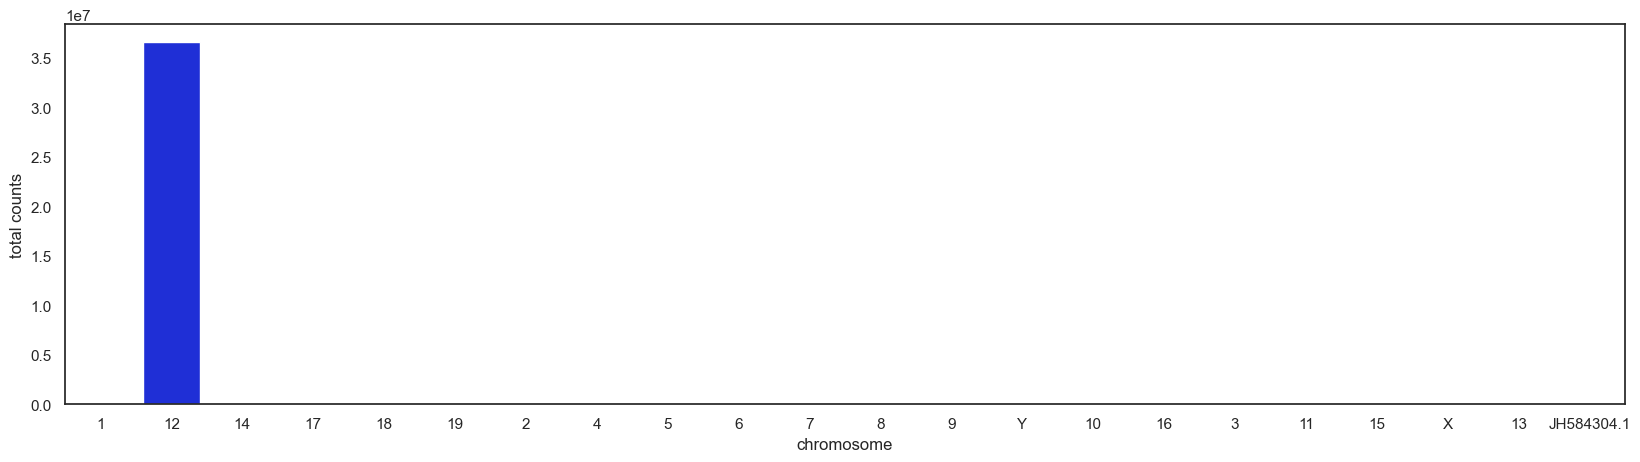

In [22]:
#Plot raw counts per chromosome
sums_cells = df.sum(axis=0, level=0)
countsPerChrom = sums_cells.sum(axis=1)

sns.set(style="white")
plt.figure(figsize=(20,5))
ax = sns.barplot(x=countsPerChrom.index, y=countsPerChrom, palette="winter", log = 'y')
ax.set(xlabel='chromosome', ylabel='total counts')
plt.show()

sns.set(style="white")
plt.figure(figsize=(20,5))
ax = sns.barplot(x=countsPerChrom.index, y=countsPerChrom, palette="winter")
ax.set(xlabel='chromosome', ylabel='total counts')
plt.show()


# Calculate percentages per allele for chromosome 12

#### This should only be necessary once. If this has been computed and saved already, move down to 'load computed datasets'.

here we also filter on the amount of reads per cell/site/allele by continuing when totalReadsForThisSite < 4.
To be considered for conversion to percentages, a cell/site/allele must contain 4 or more reads.

In [23]:
sitesB6 = []
sites129 = []
sitesNA = []
for (chrom,allele,site,scar) in df.index:
    if chrom == '12':
        if allele == 'C57BL_6NJ':
            if site not in sitesB6:
                sitesB6.append(site)
        if allele == '129S1_SvImJ':
            if site not in sites129:
                sites129.append(site)
        if allele == 'None':
            if site not in sitesNA:
                sitesNA.append(site)

In [24]:
#129
sf_129 = sf_129.fillna(0)
cellToSiteToScarPercentage129 = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))
for sample in sf_129.columns:
    for site in sites129:
        totalReadsForThisSite = sf_129.loc[site, sample].sum()
        if totalReadsForThisSite < 1:
            continue
        for scar, amountOfReads in sf_129.loc[site, sample].iteritems():
            percentage = (amountOfReads / totalReadsForThisSite)*100.0
            #if percentage > 5:
            cellToSiteToScarPercentage129[sample][int(site)][scar] += percentage

percentagesChrom12 = collections.defaultdict(dict) # sample ->(site,scar)-> value (.. ,1,2)

for sample, allSitesForThisCell in cellToSiteToScarPercentage129.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(8000000):
            percentagesChrom12[sample][(site,scar)] = percentage

percentagesChr12_129 = pd.DataFrame(percentagesChrom12)

In [25]:
#B6
sf_B6 = sf_B6.fillna(0)
cellToSiteToScarPercentageB6 = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))
for sample in sf_B6.columns:
    for site in sitesB6:
        totalReadsForThisSite = sf_B6.loc[site, sample].sum()
        if totalReadsForThisSite < 1:
            continue
        for scar, amountOfReads in sf_B6.loc[site, sample].iteritems():
            percentage = (amountOfReads / totalReadsForThisSite)*100.0
            #if percentage > 5:
            cellToSiteToScarPercentageB6[sample][int(site)][scar] += percentage

percentagesChr12B6 = collections.defaultdict(dict) # sample ->(site,scar)-> value (.. ,1,2)

for sample, allSitesForThisCell in cellToSiteToScarPercentageB6.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(8000000):
            percentagesChr12B6[sample][(site,scar)] = percentage

percentagesChr12_B6 = pd.DataFrame(percentagesChr12B6)

In [26]:
#nonallelic
sf_nonallelic = sf_nonallelic.fillna(0)                
cellToSiteToScarPercentageNA = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))
for sample in sf_nonallelic.columns:
    for site in sitesNA:
        totalReadsForThisSite = sf_nonallelic.loc[site, sample].sum()
        if totalReadsForThisSite < 1:
            continue
        for scar, amountOfReads in sf_nonallelic.loc[site, sample].iteritems():
            percentage = (amountOfReads / totalReadsForThisSite)*100.0
            #if percentage > 5:
            cellToSiteToScarPercentageNA[sample][int(site)][scar] += percentage

percentagesChr12NA = collections.defaultdict(dict) # sample ->(site,scar)-> value (.. ,1,2)

for sample, allSitesForThisCell in cellToSiteToScarPercentageNA.items():
    for site, allScarsForThisSite in allSitesForThisCell.items():
        for scar, percentage in allScarsForThisSite.most_common(8000000):
            percentagesChr12NA[sample][(site,scar)] = percentage

percentagesChr12_NA = pd.DataFrame(percentagesChr12NA)

In [27]:
#to save dataframes
percentagesChr12_129.to_pickle(pathToData + 'OUD4175_clonallines_dataFramepercentagesChr12_129.pickle.gz')
percentagesChr12_B6.to_pickle(pathToData + 'OUD4175_clonallines_dataFramepercentagesChr12_B6.pickle.gz')
percentagesChr12_NA.to_pickle(pathToData + 'OUD4175_clonallines_dataFramepercentagesChr12_NA.pickle.gz')

# Load computed datasets

In [28]:
#pathToData = '/Users/m.blotenburg/Documents/Projects/Mouse_Scartrace/Data_analysis/clonalLines/20200117_clonalLinesScars/'

In [29]:
percentagesChr12_129 = pd.read_pickle(pathToData +'OUD4175_clonallines_dataFramepercentagesChr12_129.pickle.gz')
percentagesChr12_B6 = pd.read_pickle(pathToData +'OUD4175_clonallines_dataFramepercentagesChr12_B6.pickle.gz')
percentagesChr12_NA = pd.read_pickle(pathToData +'OUD4175_clonallines_dataFramepercentagesChr12_NA.pickle.gz')

# Plotting percentages

Plot all sites per clone.

In [30]:
targetsites = [114682733,
               114708749,
               114723873,
               114788473,
               114851291,
               114879989,
               114896339,
              
              114740509,
              114746374,
              114843752,
              114910112,
              114914700,
              114736346
              ]



#[114682729, 14708745, 114723869, 114740505, 114746371, 114788470, 114843748, 114851288, 114879985, 114896335, 114910108, 114914696, 114736342]

found_targetsites = []
for site in targetsites:
    if site in percentagesChr12_129.index.droplevel(1):
            found_targetsites.append(site)
found_targetsites2 = []
for site in targetsites:
    if site in percentagesChr12_NA.index.droplevel(1):
            found_targetsites2.append(site)

In [31]:
selectedpercentagesChr12_NA = percentagesChr12_NA.loc[found_targetsites2]
selectedpercentagesChr12_B6 = percentagesChr12_B6.loc[found_targetsites]
selectedpercentagesChr12_129 = percentagesChr12_129.loc[found_targetsites]

In [32]:
dfs_all = [selectedpercentagesChr12_NA,selectedpercentagesChr12_B6,selectedpercentagesChr12_129]
all_dfs = pd.concat(dfs_all, keys=['NA', 'B6', '129'], sort = True)
dfs_2 = [selectedpercentagesChr12_B6,selectedpercentagesChr12_129]
B6_129 = pd.concat(dfs_2, keys=[ 'B6', '129'], sort = True)

In [33]:
percentageWT = pd.DataFrame(B6_129.sum(level=2).loc['WT']/B6_129.sum()*100)
percentageWT['sum'] = pd.DataFrame(B6_129.sum())

/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_34166/1499079873.py:1: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  percentageWT = pd.DataFrame(B6_129.sum(level=2).loc['WT']/B6_129.sum()*100)


In [34]:
def dataFrameAllSites(clone):
    allSitesForOneClone = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))
    for site, scar in selectedpercentagesChr12_129[clone].index:
        allSitesForOneClone[scar][('129', site)] = selectedpercentagesChr12_129[clone].loc[(site,scar)]
    for site, scar in selectedpercentagesChr12_B6[clone].index:
        allSitesForOneClone[scar][('B6', site)] = selectedpercentagesChr12_B6[clone].loc[(site,scar)]
    return pd.DataFrame(allSitesForOneClone)

In [35]:
cols=["black", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#006FA6", "#A30059", "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87","#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80","#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100", "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F", "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09","#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66","#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C","#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81","#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00","#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700","#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329","#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C","#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800","#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51","#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58","#7A7BFF", "#D68E01", "#353339", "#78AFA1", "#FEB2C6", "#75797C", "#837393", "#943A4D","#B5F4FF", "#D2DCD5", "#9556BD", "#6A714A", "#001325", "#02525F", "#0AA3F7", "#E98176","#DBD5DD", "#5EBCD1", "#3D4F44", "#7E6405", "#02684E", "#962B75", "#8D8546", "#9695C5","#E773CE", "#D86A78", "#3E89BE", "#CA834E", "#518A87", "#5B113C", "#55813B", "#E704C4","#00005F", "#A97399", "#4B8160", "#59738A", "#FF5DA7", "#F7C9BF", "#643127", "#513A01","#6B94AA", "#51A058", "#A45B02", "#1D1702", "#E20027", "#E7AB63", "#4C6001", "#9C6966","#64547B", "#97979E", "#006A66", "#391406", "#F4D749", "#0045D2", "#006C31", "#DDB6D0","#7C6571", "#9FB2A4", "#00D891", "#15A08A", "#BC65E9", "#FFFFFE", "#C6DC99", "#203B3C","#671190", "#6B3A64", "#F5E1FF", "#FFA0F2", "#CCAA35", "#374527", "#8BB400", "#797868","#C6005A", "#3B000A", "#C86240", "#29607C", "#402334", "#7D5A44", "#CCB87C", "#B88183","#AA5199", "#B5D6C3", "#A38469", "#9F94F0", "#A74571", "#B894A6", "#71BB8C", "#00B433","#789EC9", "#6D80BA", "#953F00", "#5EFF03", "#E4FFFC", "#1BE177", "#BCB1E5", "#76912F","#003109", "#0060CD", "#D20096", "#895563", "#29201D", "#5B3213", "#A76F42", "#89412E","#1A3A2A", "#494B5A", "#A88C85", "#F4ABAA", "#A3F3AB", "#00C6C8", "#EA8B66", "#958A9F","#BDC9D2", "#9FA064", "#BE4700", "#658188", "#83A485", "#453C23", "#47675D", "#3A3F00","#061203", "#DFFB71", "#868E7E", "#98D058", "#6C8F7D", "#D7BFC2", "#3C3E6E", "#D83D66","#2F5D9B", "#6C5E46", "#D25B88", "#5B656C", "#00B57F", "#545C46", "#866097", "#365D25","#252F99", "#00CCFF", "#674E60", "#FC009C", "#92896B", "#1E2324", "#DEC9B2", "#9D4948","#85ABB4", "#342142", "#D09685", "#A4ACAC", "#00FFFF", "#AE9C86", "#742A33", "#0E72C5","#AFD8EC", "#C064B9", "#91028C", "#FEEDBF", "#FFB789", "#9CB8E4", "#AFFFD1", "#2A364C","#4F4A43", "#647095", "#34BBFF", "#807781", "#920003", "#B3A5A7", "#018615", "#F1FFC8","#976F5C", "#FF3BC1", "#FF5F6B", "#077D84", "#F56D93", "#5771DA", "#4E1E2A", "#830055","#02D346", "#BE452D", "#00905E", "#BE0028", "#6E96E3", "#007699", "#FEC96D", "#9C6A7D","#3FA1B8", "#893DE3", "#79B4D6", "#7FD4D9", "#6751BB", "#B28D2D", "#E27A05", "#DD9CB8","#AABC7A", "#980034", "#561A02", "#8F7F00", "#635000", "#CD7DAE", "#8A5E2D", "#FFB3E1","#6B6466", "#C6D300", "#0100E2", "#88EC69", "#8FCCBE", "#21001C", "#511F4D", "#E3F6E3","#FF8EB1", "#6B4F29", "#A37F46", "#6A5950", "#1F2A1A", "#04784D", "#101835", "#E6E0D0","#FF74FE", "#00A45F", "#8F5DF8", "#4B0059", "#412F23", "#D8939E", "#DB9D72", "#604143","#B5BACE", "#989EB7", "#D2C4DB", "#A587AF", "#77D796", "#7F8C94", "#FF9B03", "#555196","#31DDAE", "#74B671", "#802647", "#2A373F", "#014A68", "#696628", "#4C7B6D", "#002C27","#7A4522", "#3B5859", "#E5D381", "#FFF3FF", "#679FA0", "#261300", "#2C5742", "#9131AF","#AF5D88", "#C7706A", "#61AB1F", "#8CF2D4", "#C5D9B8", "#9FFFFB", "#BF45CC", "#493941","#863B60", "#B90076", "#003177", "#C582D2", "#C1B394", "#602B70", "#887868", "#BABFB0","#030012", "#D1ACFE", "#7FDEFE", "#4B5C71", "#A3A097", "#E66D53", "#637B5D", "#92BEA5","#00F8B3", "#BEDDFF", "#3DB5A7", "#DD3248", "#B6E4DE", "#427745", "#598C5A", "#B94C59","#8181D5", "#94888B", "#FED6BD", "#536D31", "#6EFF92", "#E4E8FF", "#20E200", "#FFD0F2","#4C83A1", "#BD7322", "#915C4E", "#8C4787", "#025117", "#A2AA45", "#2D1B21", "#A9DDB0","#FF4F78", "#528500", "#009A2E", "#17FCE4", "#71555A", "#525D82", "#00195A", "#967874","#555558", "#0B212C", "#1E202B", "#EFBFC4", "#6F9755", "#6F7586", "#501D1D", "#372D00","#741D16", "#5EB393", "#B5B400", "#DD4A38", "#363DFF", "#AD6552", "#6635AF", "#836BBA","#98AA7F", "#464836", "#322C3E", "#7CB9BA", "#5B6965", "#707D3D", "#7A001D", "#6E4636","#443A38", "#AE81FF", "#489079", "#897334", "#009087", "#DA713C", "#361618", "#FF6F01","#006679", "#370E77", "#4B3A83", "#C9E2E6", "#C44170", "#FF4526", "#73BE54", "#C4DF72","#ADFF60", "#00447D", "#DCCEC9", "#BD9479", "#656E5B", "#EC5200", "#FF6EC2", "#7A617E","#DDAEA2", "#77837F", "#A53327", "#608EFF", "#B599D7", "#A50149", "#4E0025", "#C9B1A9","#03919A", "#1B2A25", "#E500F1", "#982E0B", "#B67180", "#E05859", "#006039", "#578F9B","#305230", "#CE934C", "#B3C2BE", "#C0BAC0", "#B506D3", "#170C10", "#4C534F", "#224451","#3E4141", "#78726D", "#B6602B", "#200441", "#DDB588", "#497200", "#C5AAB6", "#033C61","#71B2F5", "#A9E088", "#4979B0", "#A2C3DF", "#784149", "#2D2B17", "#3E0E2F", "#57344C","#0091BE", "#E451D1", "#4B4B6A", "#5C011A", "#7C8060", "#FF9491", "#4C325D", "#005C8B","#E5FDA4", "#68D1B6", "#032641", "#140023", "#8683A9", "#CFFF00", "#A72C3E", "#34475A","#B1BB9A", "#B4A04F", "#8D918E", "#A168A6", "#813D3A", "#425218", "#DA8386", "#776133","#563930", "#8498AE", "#90C1D3", "#B5666B", "#9B585E", "#856465", "#AD7C90", "#E2BC00","#E3AAE0", "#B2C2FE", "#FD0039", "#009B75", "#FFF46D", "#E87EAC", "#DFE3E6", "#848590","#AA9297", "#83A193", "#577977", "#3E7158", "#C64289", "#EA0072", "#C4A8CB", "#55C899","#E78FCF", "#004547", "#F6E2E3", "#966716", "#378FDB", "#435E6A", "#DA0004", "#1B000F","#5B9C8F", "#6E2B52", "#011115", "#E3E8C4", "#AE3B85", "#EA1CA9", "#FF9E6B", "#457D8B","#92678B", "#00CDBB", "#9CCC04", "#002E38", "#96C57F", "#CFF6B4", "#492818", "#766E52","#20370E", "#E3D19F", "#2E3C30", "#B2EACE", "#F3BDA4", "#A24E3D", "#976FD9", "#8C9FA8","#7C2B73", "#4E5F37", "#5D5462", "#90956F", "#6AA776", "#DBCBF6", "#DA71FF", "#987C95","#52323C", "#BB3C42", "#584D39", "#4FC15F", "#A2B9C1", "#79DB21", "#1D5958", "#BD744E","#160B00", "#20221A", "#6B8295", "#00E0E4", "#102401", "#1B782A", "#DAA9B5", "#B0415D","#859253", "#97A094", "#06E3C4", "#47688C", "#7C6755", "#075C00", "#7560D5", "#7D9F00","#C36D96", "#4D913E", "#5F4276", "#FCE4C8", "#303052", "#4F381B", "#E5A532", "#706690","#AA9A92", "#237363", "#73013E", "#FF9079", "#A79A74", "#029BDB", "#FF0169", "#C7D2E7","#CA8869", "#80FFCD", "#BB1F69", "#90B0AB", "#7D74A9", "#FCC7DB", "#99375B", "#00AB4D","#ABAED1", "#BE9D91", "#E6E5A7", "#332C22", "#DD587B", "#F5FFF7", "#5D3033", "#6D3800","#FF0020", "#B57BB3", "#D7FFE6", "#C535A9", "#260009", "#6A8781", "#A8ABB4", "#D45262","#794B61", "#4621B2", "#8DA4DB", "#C7C890", "#6FE9AD", "#A243A7", "#B2B081", "#181B00","#286154", "#4CA43B", "#6A9573", "#A8441D", "#5C727B", "#738671", "#D0CFCB", "#897B77","#1F3F22", "#4145A7", "#DA9894", "#A1757A", "#63243C", "#ADAAFF", "#00CDE2", "#DDBC62","#698EB1", "#208462", "#00B7E0", "#614A44", "#9BBB57", "#7A5C54", "#857A50", "#766B7E","#014833", "#FF8347", "#7A8EBA", "#274740", "#946444", "#EBD8E6", "#646241", "#373917","#6AD450", "#81817B", "#D499E3", "#979440", "#011A12", "#526554", "#B5885C", "#A499A5","#03AD89", "#B3008B", "#E3C4B5", "#96531F", "#867175", "#74569E", "#617D9F", "#E70452","#067EAF", "#A697B6", "#B787A8", "#9CFF93", "#311D19", "#3A9459", "#6E746E", "#B0C5AE","#84EDF7", "#ED3488", "#754C78", "#384644", "#C7847B", "#00B6C5", "#7FA670", "#C1AF9E","#2A7FFF", "#72A58C", "#FFC07F", "#9DEBDD", "#D97C8E", "#7E7C93", "#62E674", "#B5639E","#FFA861", "#C2A580", "#8D9C83", "#B70546", "#372B2E", "#0098FF", "#985975", "#20204C","#FF6C60", "#445083", "#8502AA", "#72361F", "#9676A3", "#484449", "#CED6C2", "#3B164A","#CCA763", "#2C7F77", "#02227B", "#A37E6F", "#CDE6DC", "#CDFFFB", "#BE811A", "#F77183","#EDE6E2", "#CDC6B4", "#FFE09E", "#3A7271", "#FF7B59", "#4E4E01", "#4AC684", "#8BC891","#BC8A96", "#CF6353", "#DCDE5C", "#5EAADD", "#F6A0AD", "#E269AA", "#A3DAE4", "#436E83","#002E17", "#ECFBFF", "#A1C2B6", "#50003F", "#71695B", "#67C4BB", "#536EFF", "#5D5A48","#890039", "#969381", "#371521", "#5E4665", "#AA62C3", "#8D6F81", "#2C6135", "#410601","#564620", "#E69034", "#6DA6BD", "#E58E56", "#E3A68B", "#48B176", "#D27D67", "#B5B268","#7F8427", "#FF84E6", "#435740", "#EAE408", "#F4F5FF", "#325800", "#4B6BA5", "#ADCEFF","#9B8ACC", "#885138", "#5875C1", "#7E7311", "#FEA5CA", "#9F8B5B", "#A55B54", "#89006A","#AF756F", "#2A2000", "#7499A1", "#FFB550", "#00011E", "#D1511C", "#688151", "#BC908A","#78C8EB", "#8502FF", "#483D30", "#C42221", "#5EA7FF", "#785715", "#0CEA91", "#FFFAED","#B3AF9D", "#3E3D52", "#5A9BC2", "#9C2F90", "#8D5700", "#ADD79C", "#00768B", "#337D00","#C59700", "#3156DC", "#944575", "#ECFFDC", "#D24CB2", "#97703C", "#4C257F", "#9E0366","#88FFEC", "#B56481", "#396D2B", "#56735F", "#988376", "#9BB195", "#A9795C", "#E4C5D3","#9F4F67", "#1E2B39", "#664327", "#AFCE78", "#322EDF", "#86B487", "#C23000", "#ABE86B","#96656D", "#250E35", "#A60019", "#0080CF", "#CAEFFF", "#323F61", "#A449DC", "#6A9D3B","#FF5AE4", "#636A01", "#D16CDA", "#736060", "#FFBAAD", "#D369B4", "#FFDED6", "#6C6D74","#927D5E", "#845D70", "#5B62C1", "#2F4A36", "#E45F35", "#FF3B53", "#AC84DD", "#762988","#70EC98", "#408543", "#2C3533", "#2E182D", "#323925", "#19181B", "#2F2E2C", "#023C32","#9B9EE2", "#58AFAD", "#5C424D", "#7AC5A6", "#685D75", "#B9BCBD", "#834357", "#1A7B42","#2E57AA", "#E55199", "#316E47", "#CD00C5", "#6A004D", "#7FBBEC", "#F35691", "#D7C54A","#62ACB7", "#CBA1BC", "#A28A9A", "#6C3F3B", "#FFE47D", "#DCBAE3", "#5F816D", "#3A404A","#7DBF32", "#E6ECDC", "#852C19", "#285366", "#B8CB9C", "#0E0D00", "#4B5D56", "#6B543F","#E27172", "#0568EC", "#2EB500", "#D21656", "#EFAFFF", "#682021", "#2D2011", "#DA4CFF","#70968E", "#FF7B7D", "#4A1930", "#E8C282", "#E7DBBC", "#A68486", "#1F263C", "#36574E","#52CE79", "#ADAAA9", "#8A9F45", "#6542D2", "#00FB8C", "#5D697B", "#CCD27F", "#94A5A1","#790229", "#E383E6", "#7EA4C1", "#4E4452", "#4B2C00", "#620B70", "#314C1E", "#874AA6","#E30091", "#66460A", "#EB9A8B", "#EAC3A3", "#98EAB3", "#AB9180", "#B8552F", "#1A2B2F","#94DDC5", "#9D8C76", "#9C8333", "#94A9C9", "#392935", "#8C675E", "#CCE93A", "#917100","#01400B", "#449896", "#1CA370", "#E08DA7", "#8B4A4E", "#667776", "#4692AD", "#67BDA8","#69255C", "#D3BFFF", "#4A5132", "#7E9285", "#77733C", "#E7A0CC", "#51A288", "#2C656A","#4D5C5E", "#C9403A", "#DDD7F3", "#005844", "#B4A200", "#488F69", "#858182", "#D4E9B9","#3D7397", "#CAE8CE", "#D60034", "#AA6746", "#9E5585", "#BA6200"]

# def plotAllSites(name_df, clone = 'clone'):
#    ax = pd.DataFrame(name_df).plot.bar(stacked=True,figsize=(15,5),fontsize = 15,width=0.90, color=cols)
#    ax.set_xlabel("Target sites",fontsize=15)
#    ax.set_title(('All sites for ' + clone), fontsize=15)
#    ax.set_ylabel("Percentage",fontsize=15)
#    ax.tick_params(axis='x', rotation=90)
 #   ax.legend([],frameon=False)  
 #   axlegend = pd.DataFrame(name_df).plot.bar(stacked=True,figsize=(1,1),fontsize = 15,width=0.90, color=cols)
 #   axlegend.legend(bbox_to_anchor=(0.9,-0.1))
  #  return ax
  #  return axlegend
  

def plotAllSites(name_df = dataFrameAllSites, clone = 'clone'):
    test = []
    for x in pd.DataFrame(name_df):
        if pd.DataFrame(name_df)[str(x)].sum() != 0:
            test.append(name_df[str(x)])
    ax = pd.DataFrame(test).T.plot.bar(stacked=True,figsize=(15,5),fontsize = 15,width=0.90, color=cols)
    ax.set_title(('Sample: ' + str(clone)), fontsize=15)
    ax.legend([])#(bbox_to_anchor=(0.8,-0.6))
    return ax

def plotPerSite(df_129orB6,site, allele=''):
    ax = df_129orB6.T[site].plot.bar(stacked=True,figsize=(25,5),fontsize = 15,width=0.90)
    ax.set_xlabel("Clonal line",fontsize=15)
    ax.set_title((allele + 'Site ' + str(site)), fontsize=15)
    ax.set_ylabel("Percentage",fontsize=15)
    ax.legend([])#(bbox_to_anchor=(0.8,-0.6))
    #ax.legend(bbox_to_anchor=(0.9,-0.3))
    

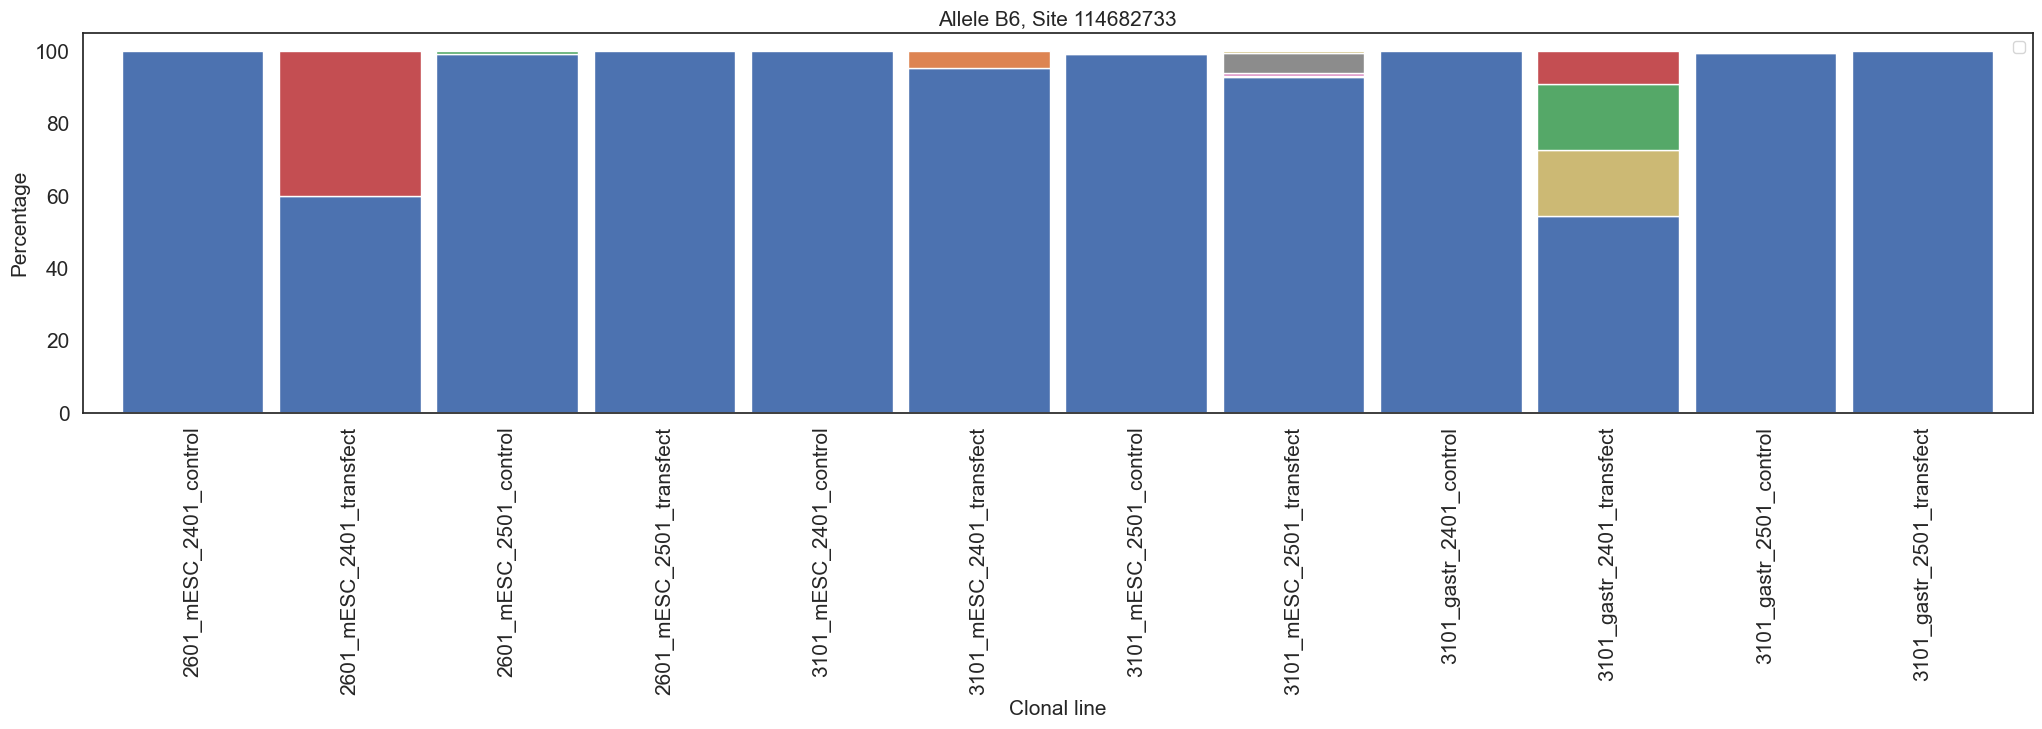

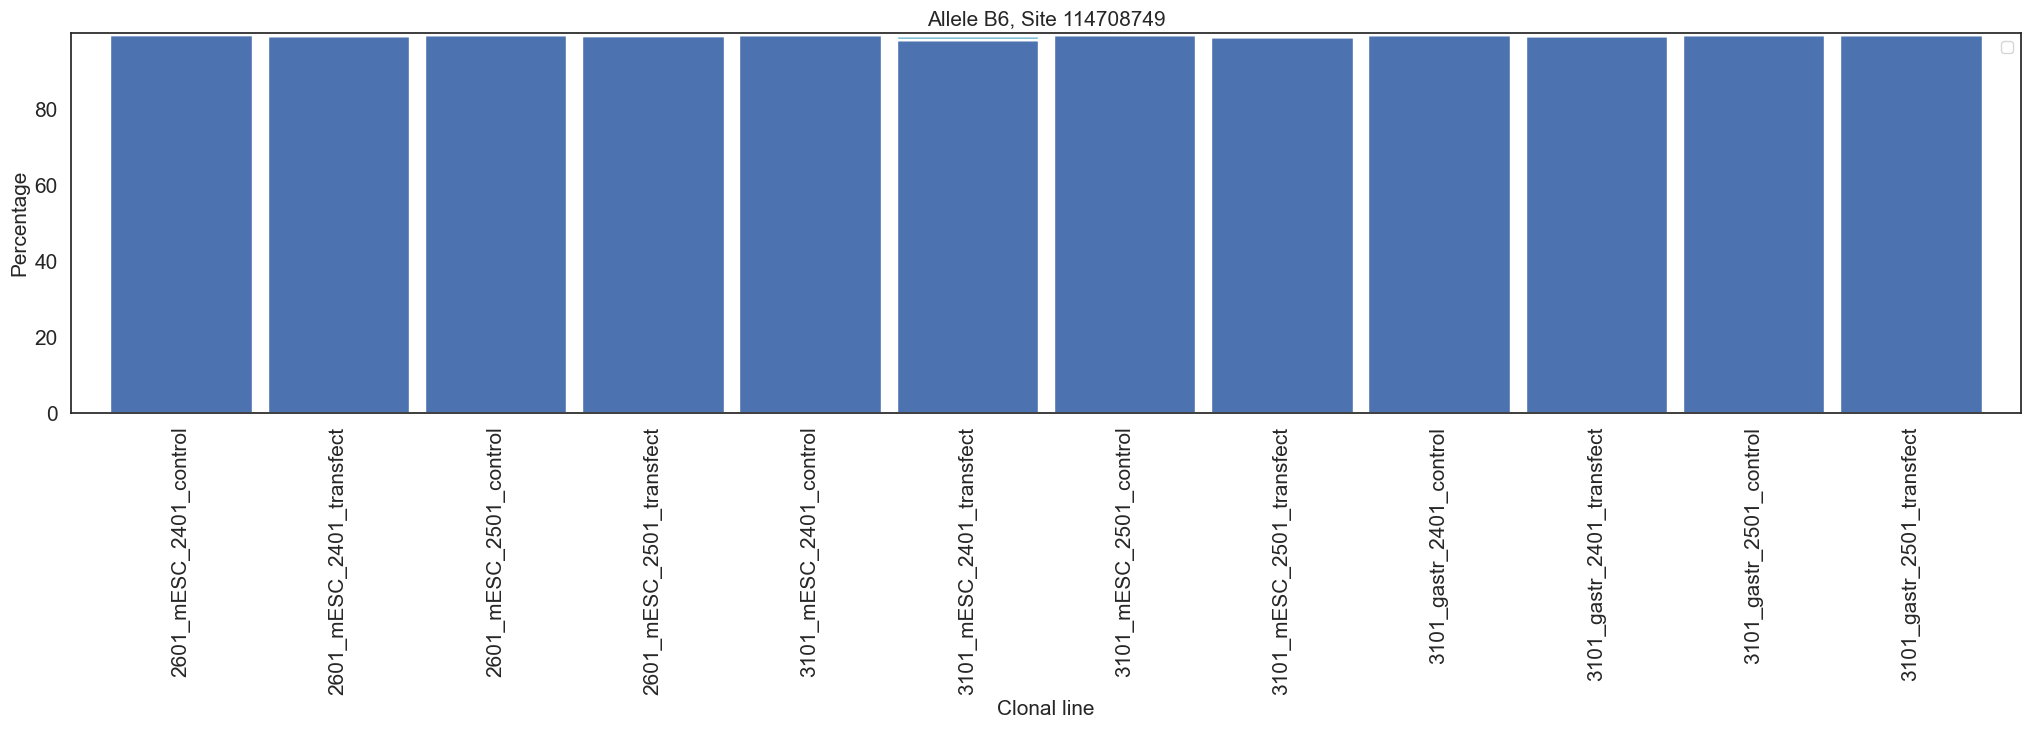

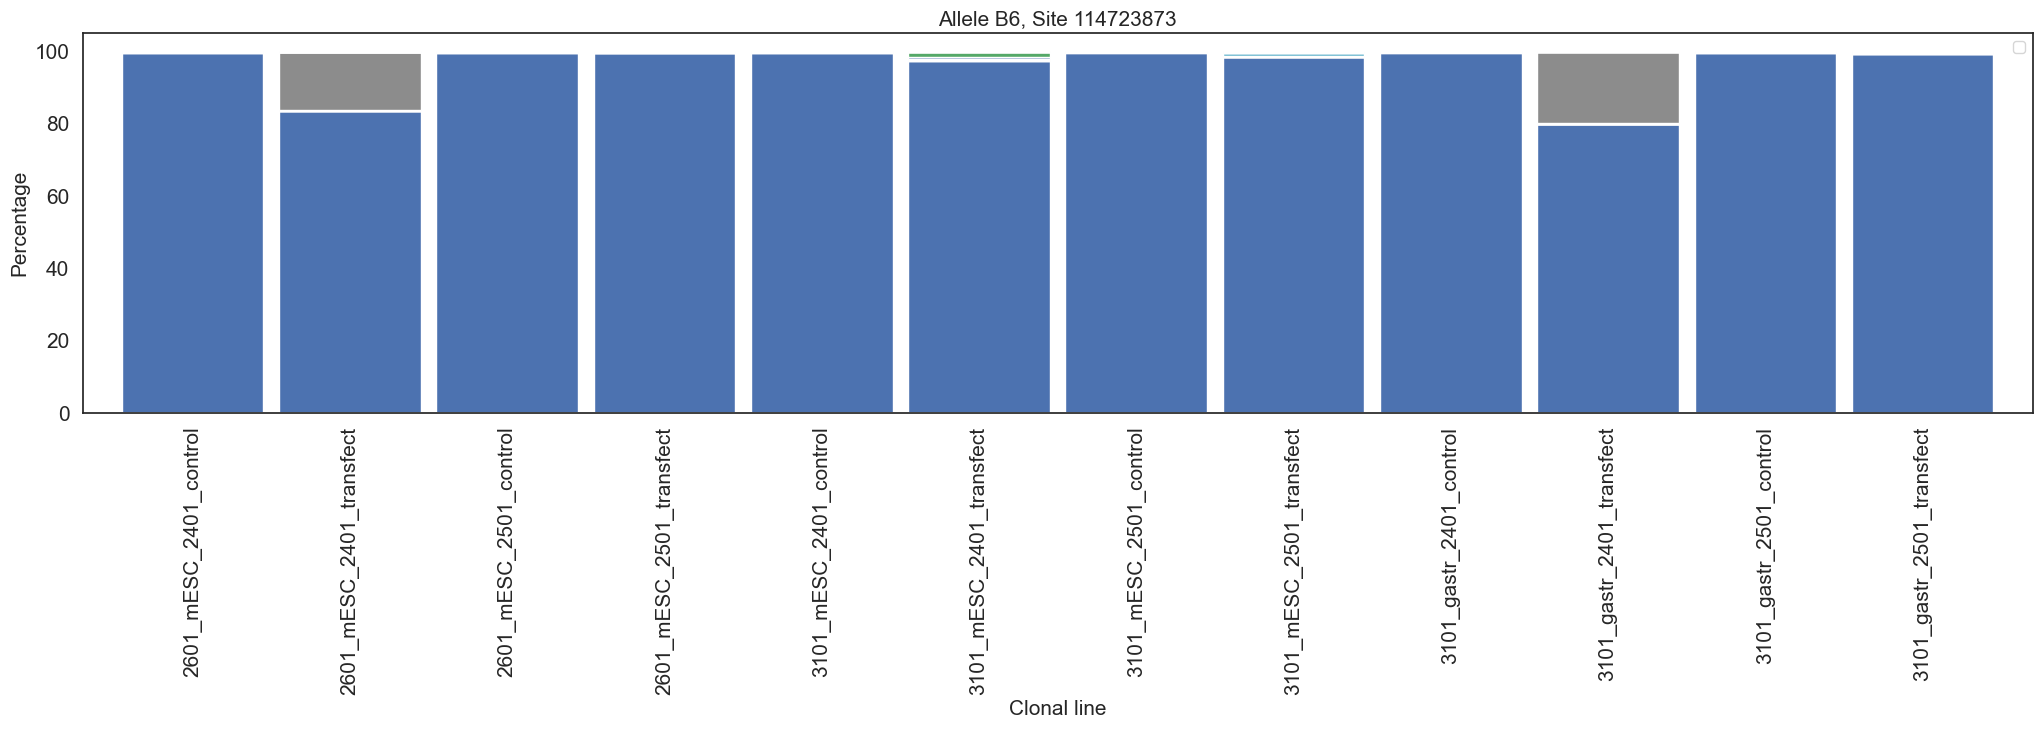

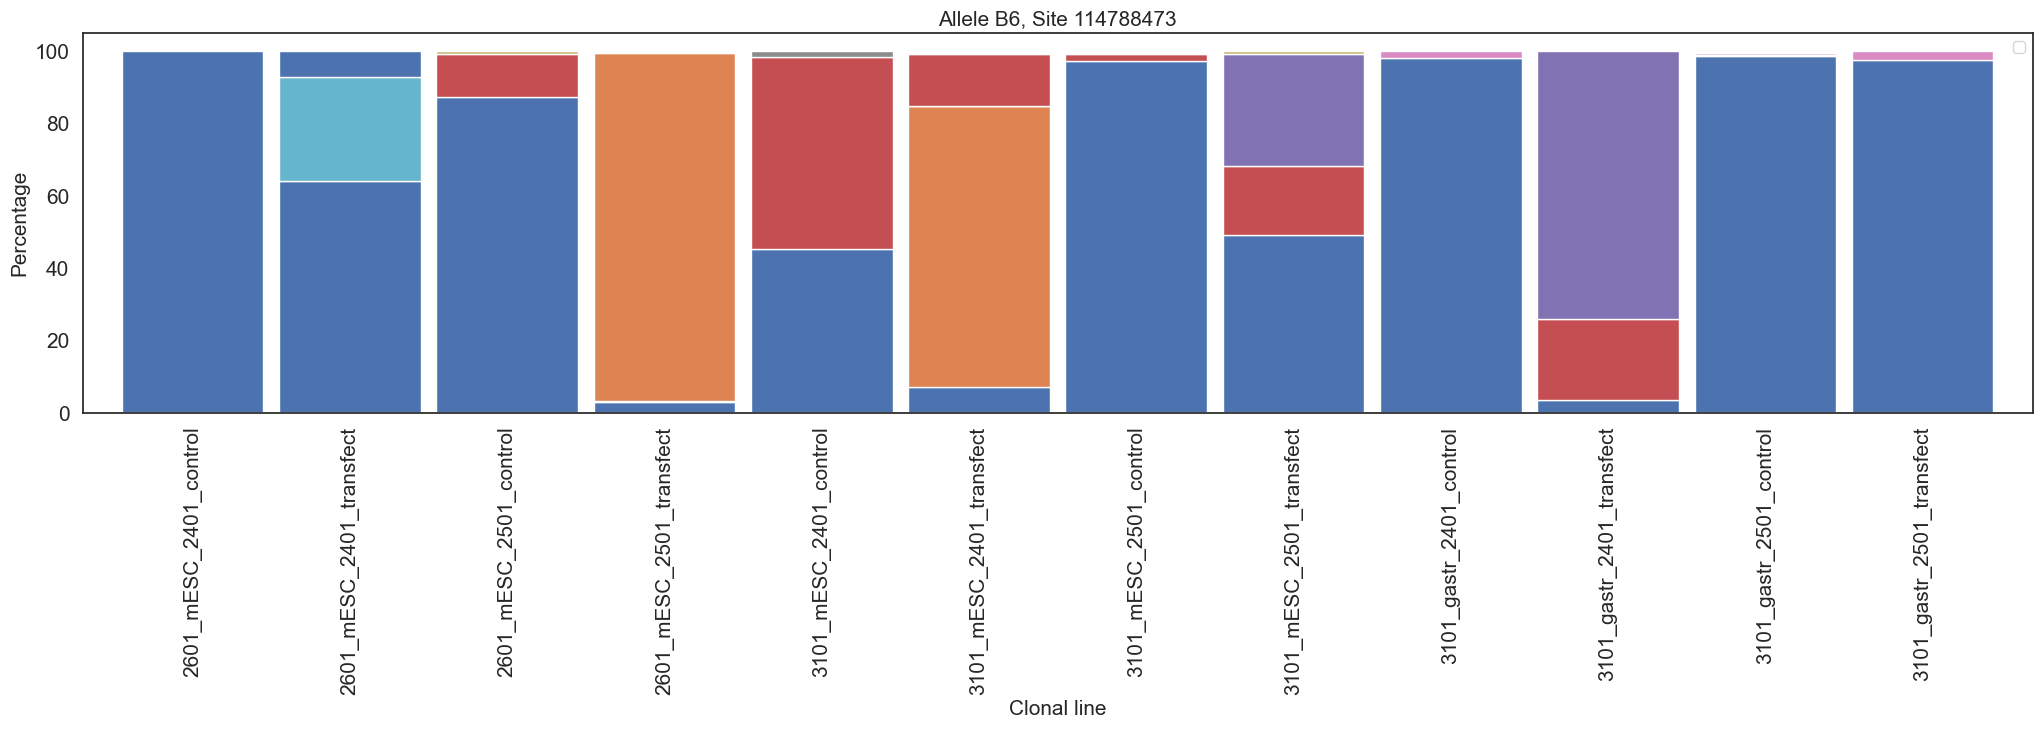

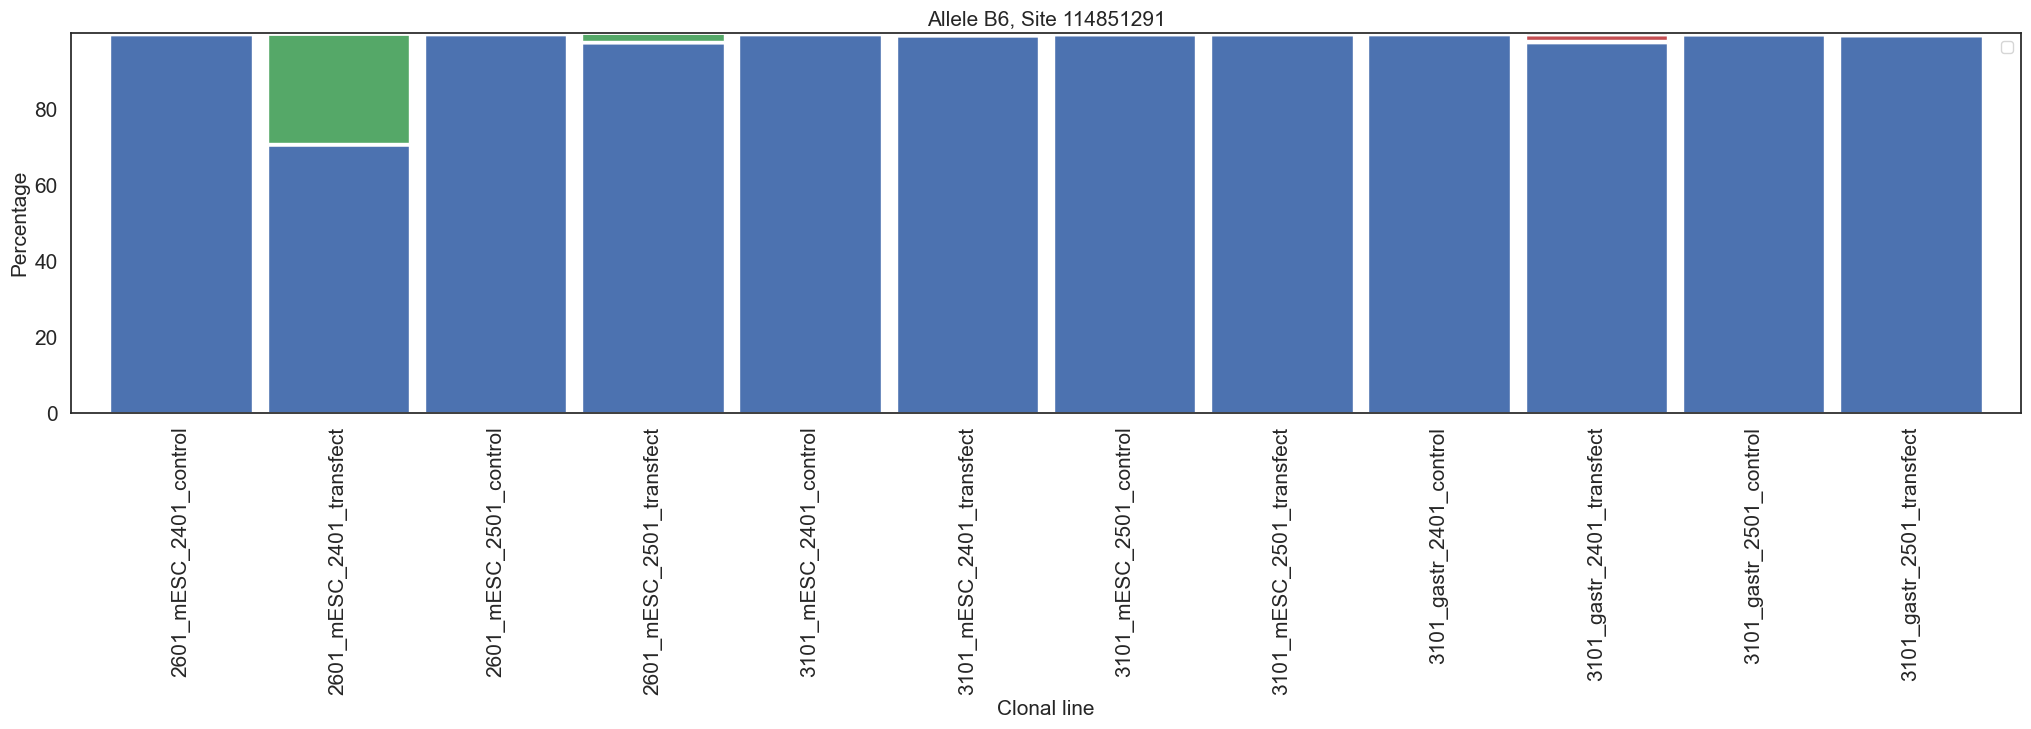

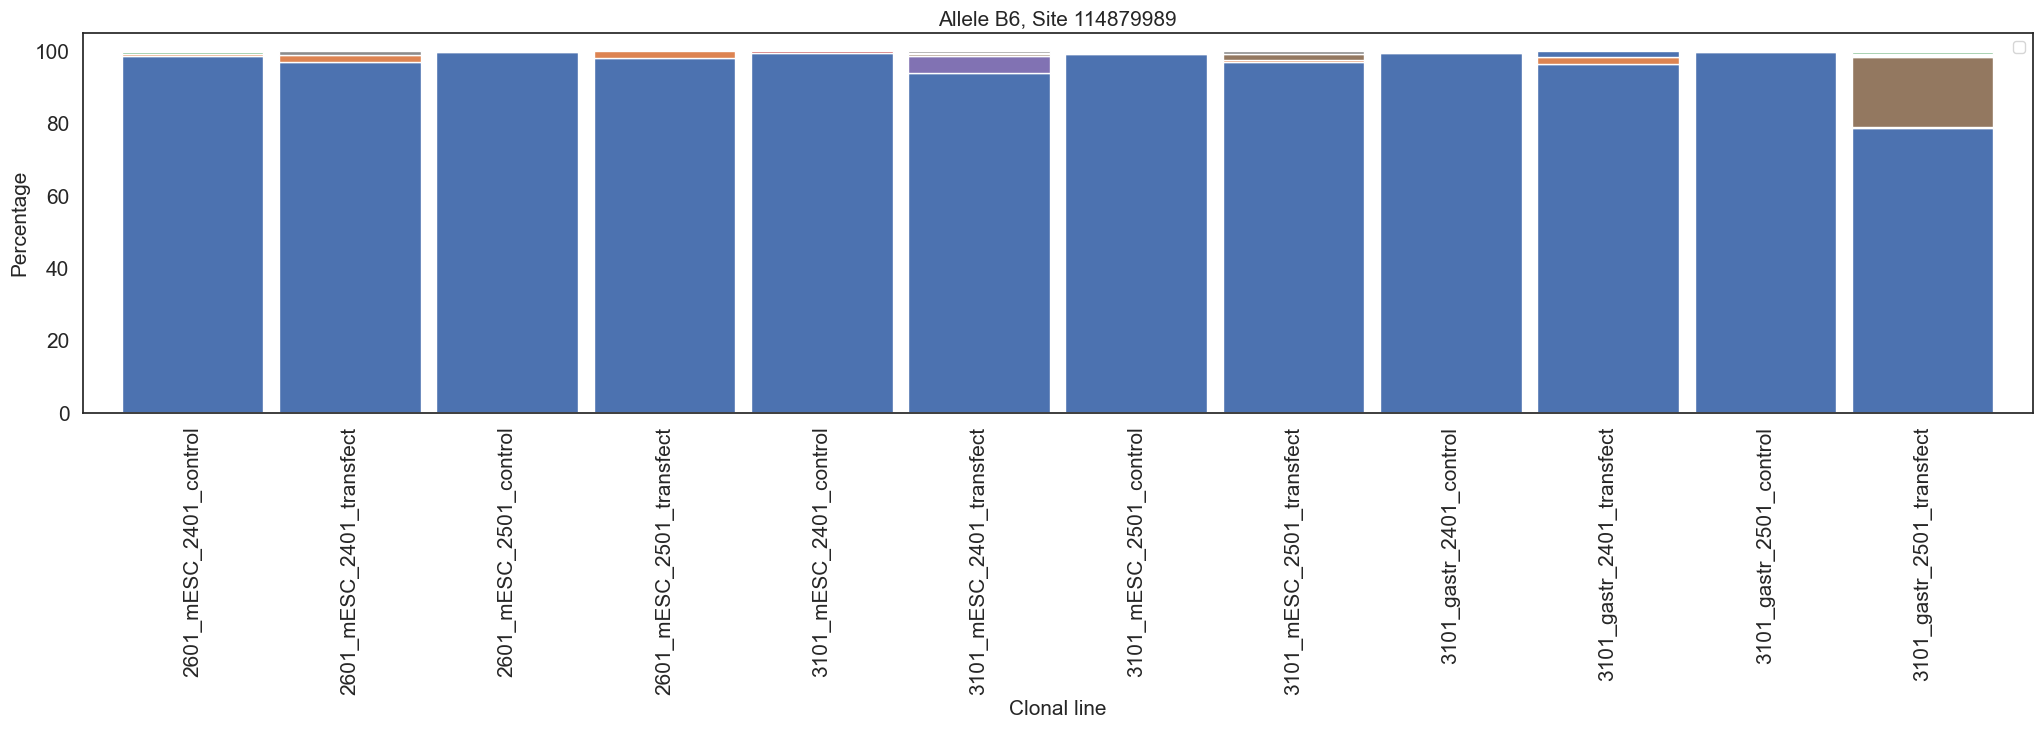

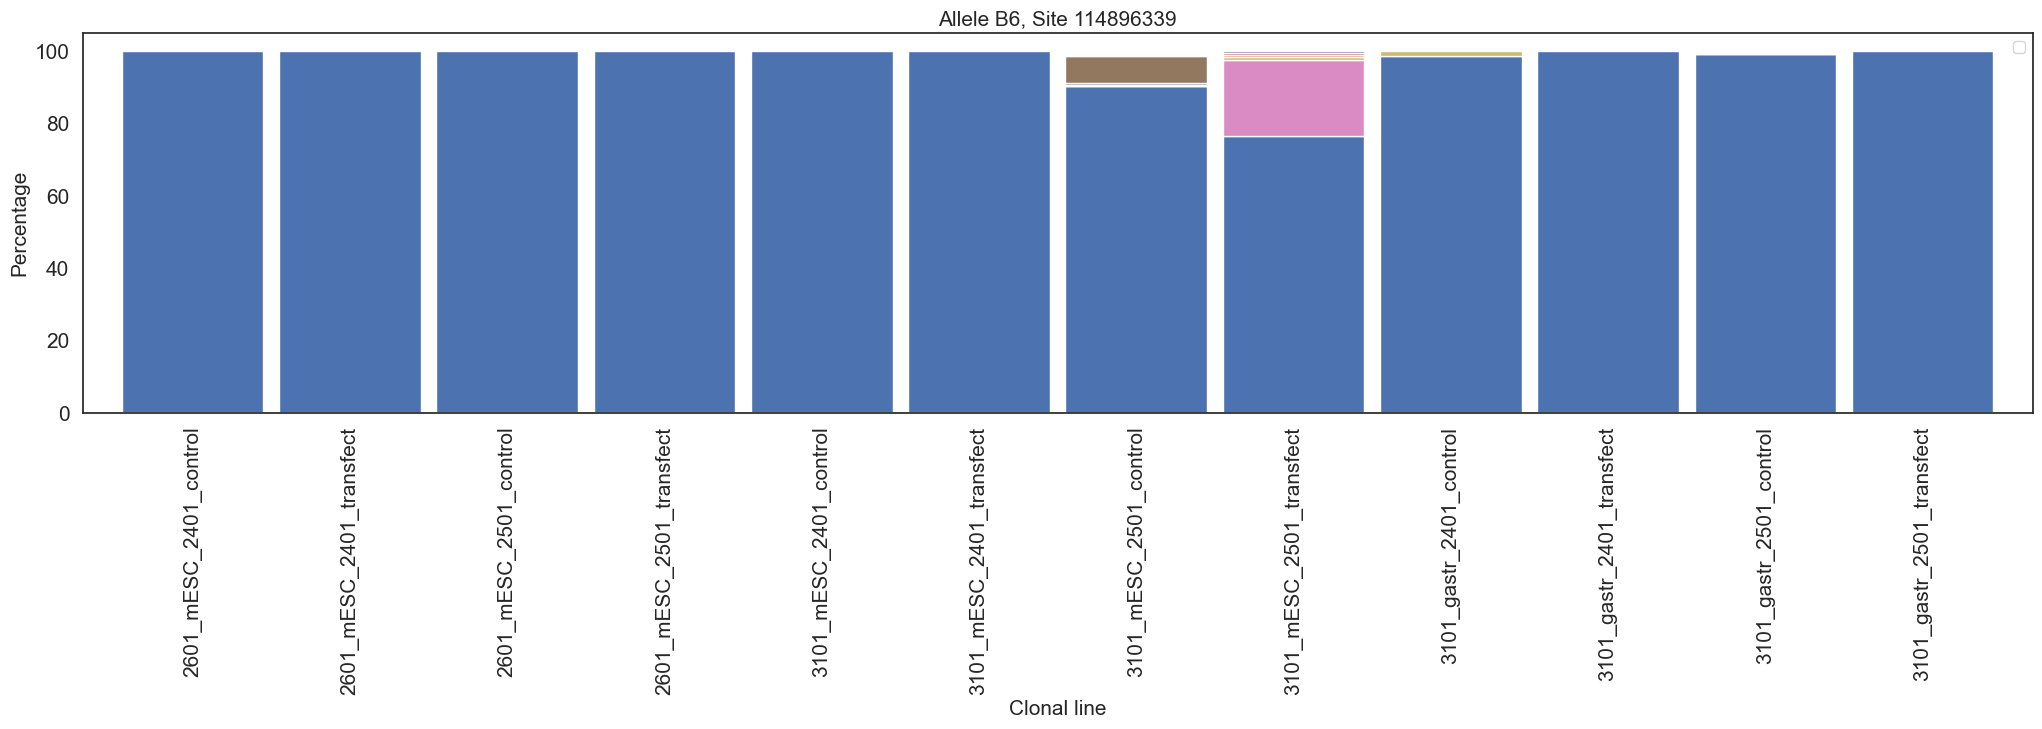

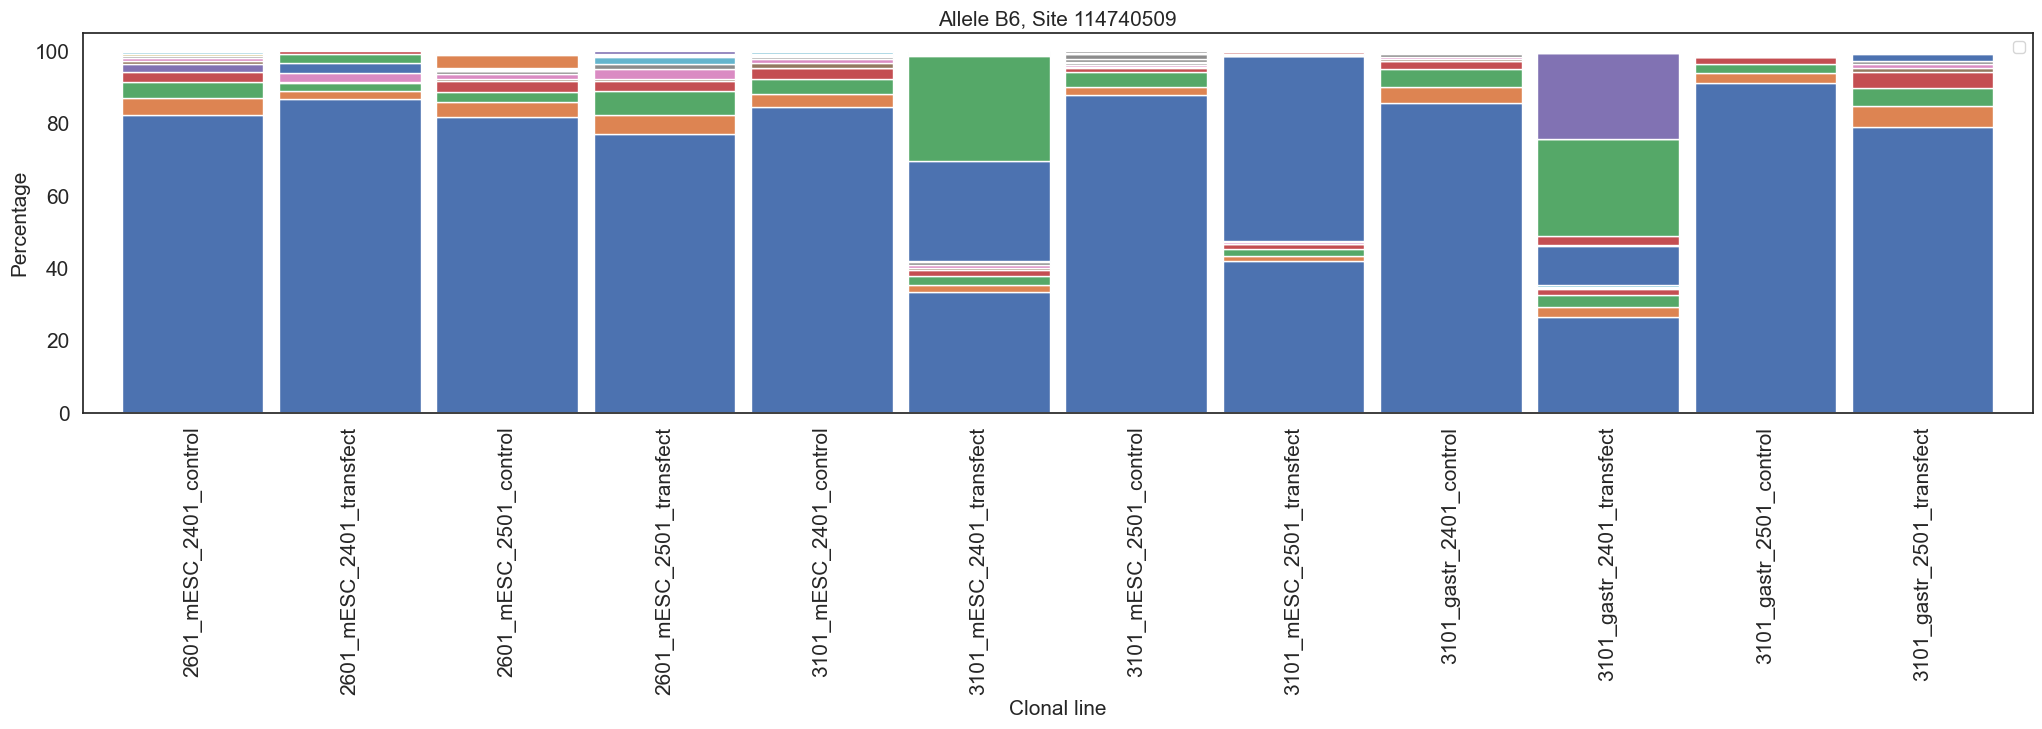

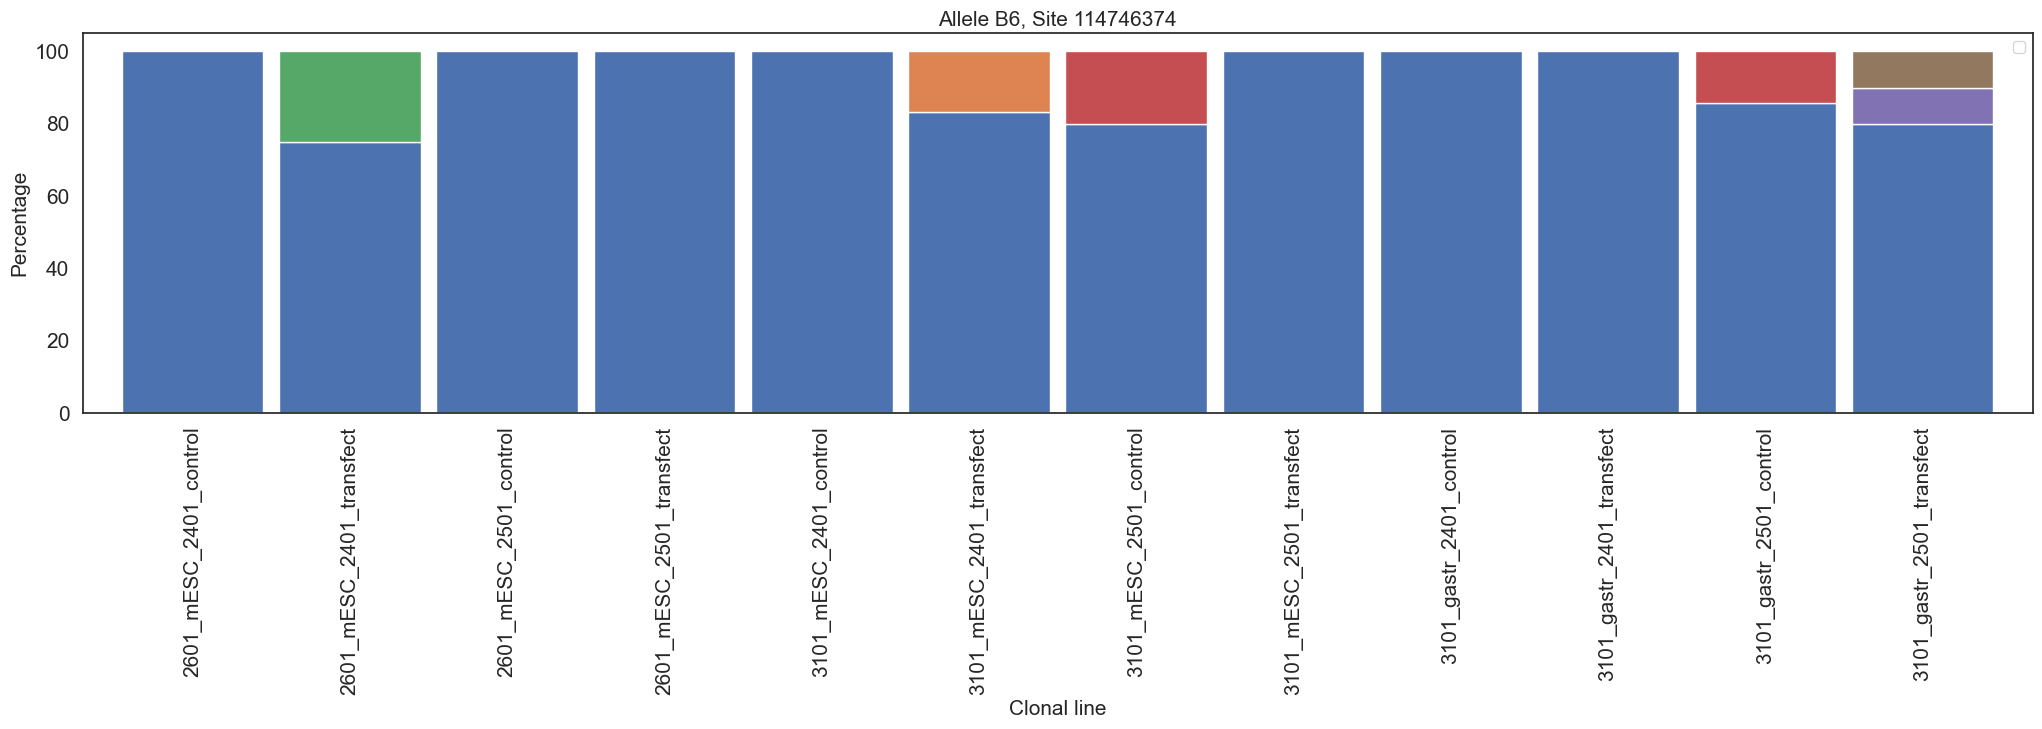

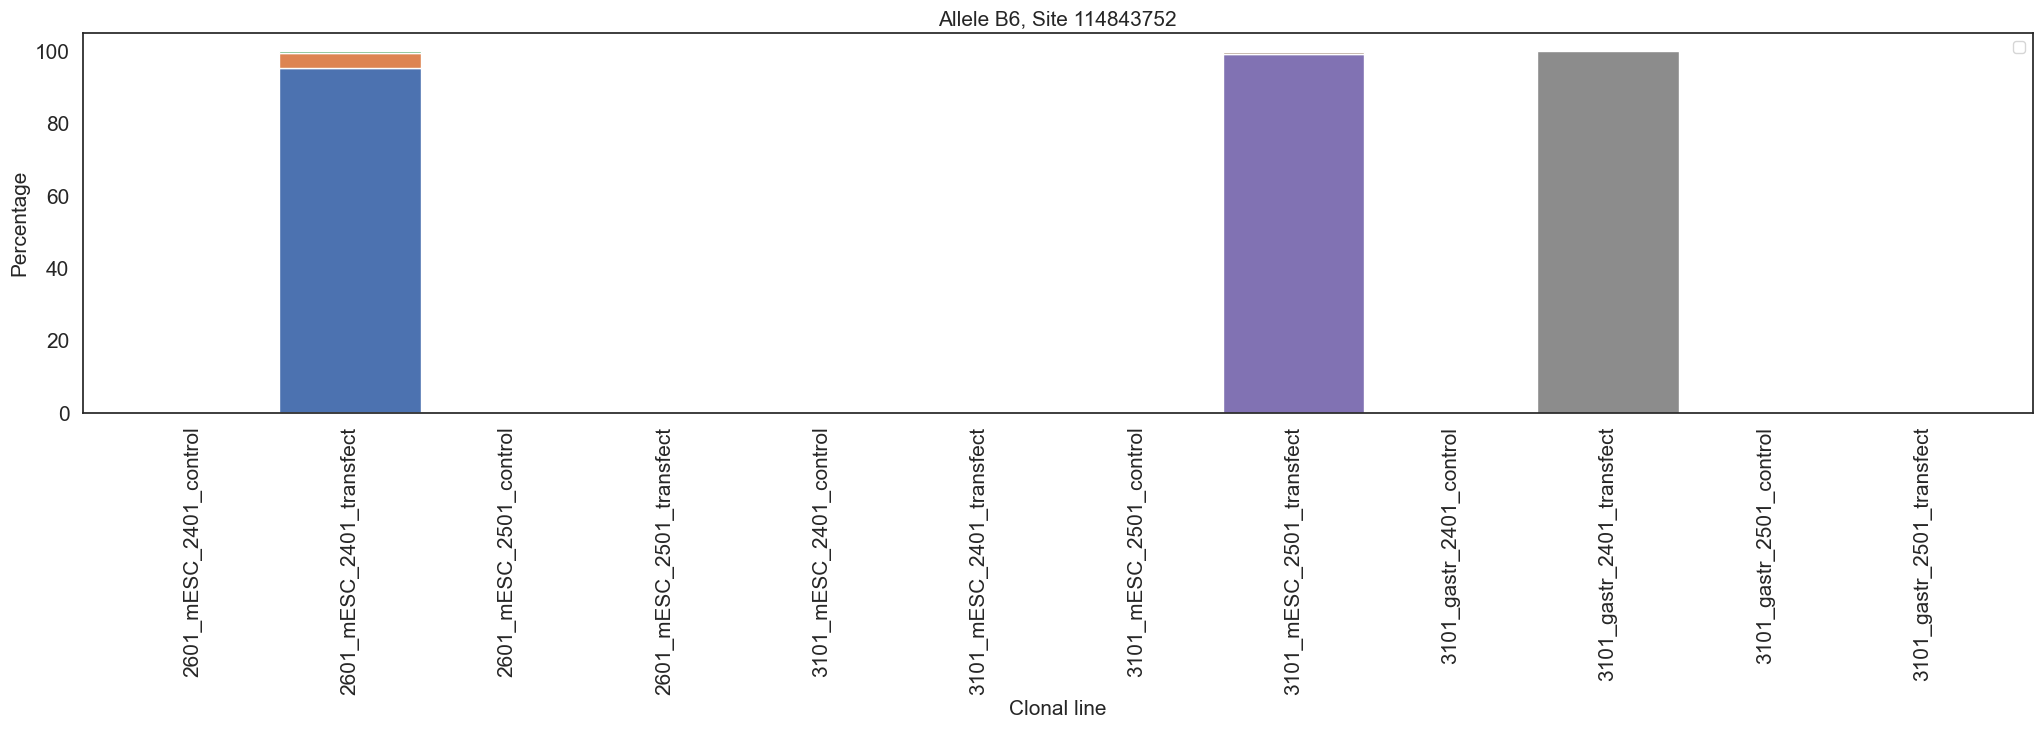

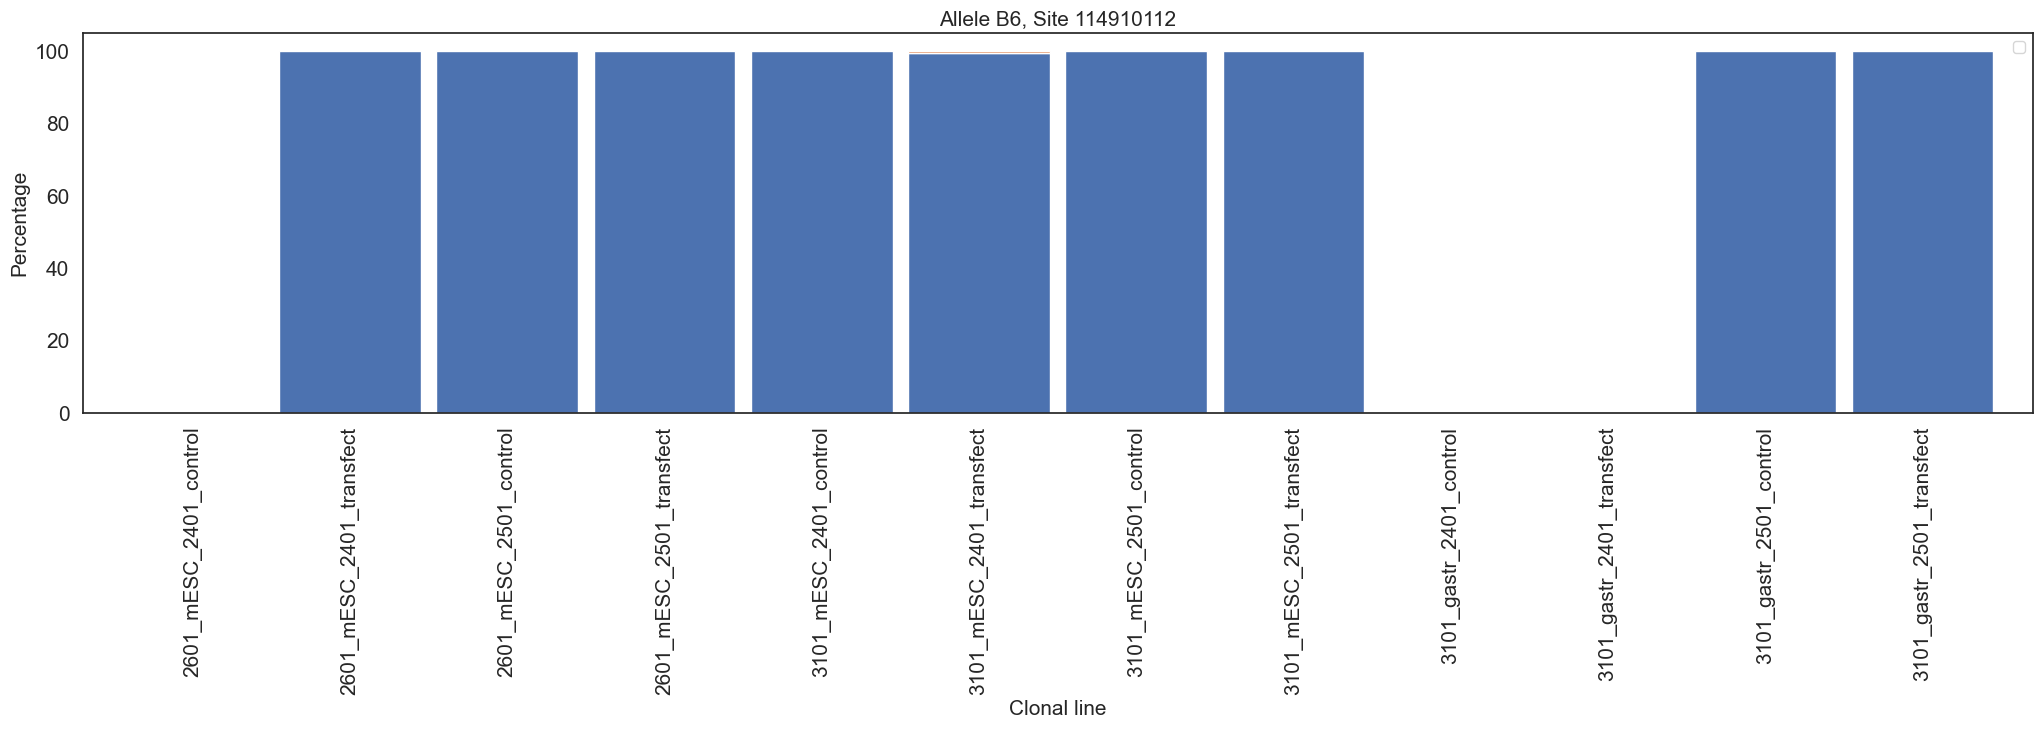

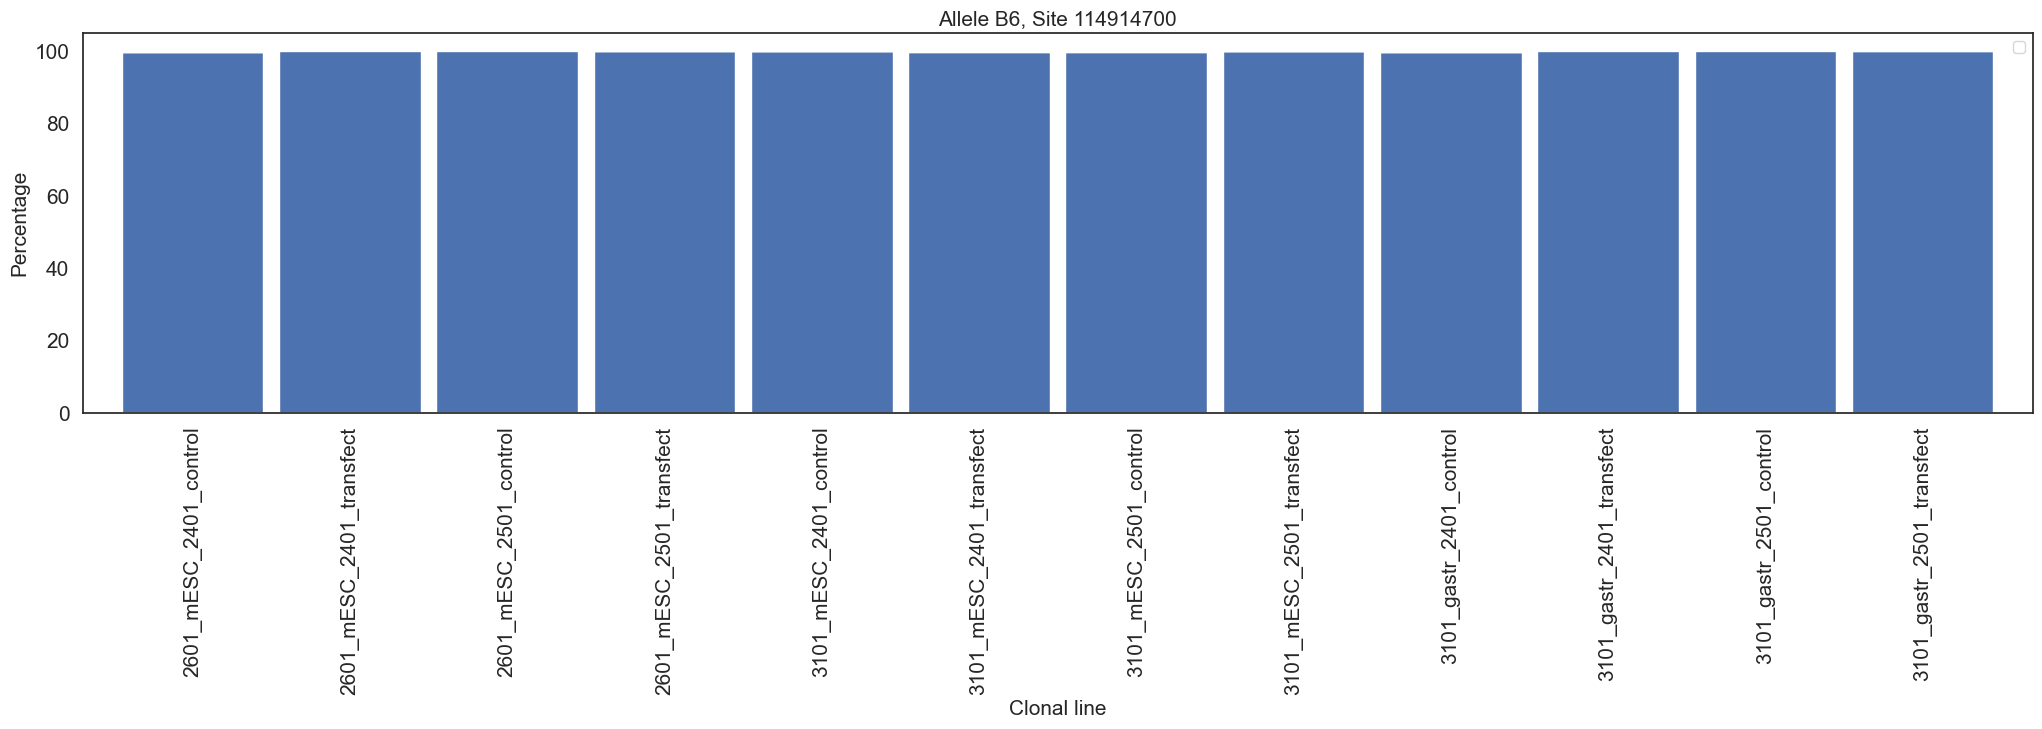

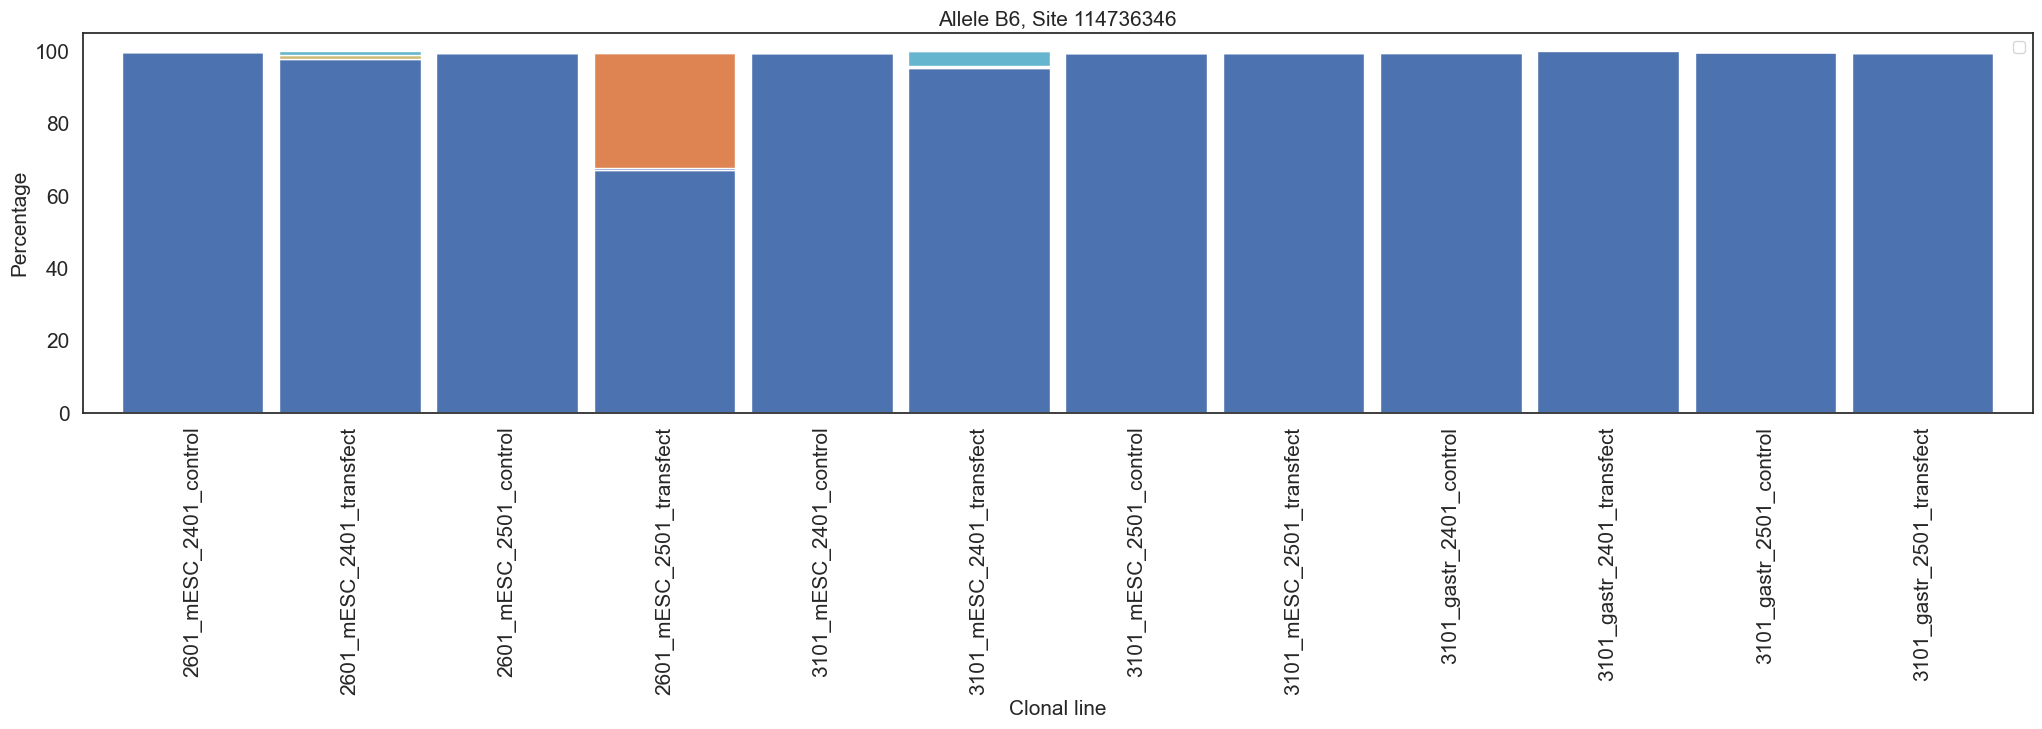

In [36]:
sitesB6 = targetsites

#[114723869, 114788470,  114879985,114736342]
#114682729,114896335,14708745,114843748,114910108
#114740505,114746371,114851288,114914696
for site in sitesB6:
    plotPerSite(selectedpercentagesChr12_B6,site, allele = 'Allele B6, ')

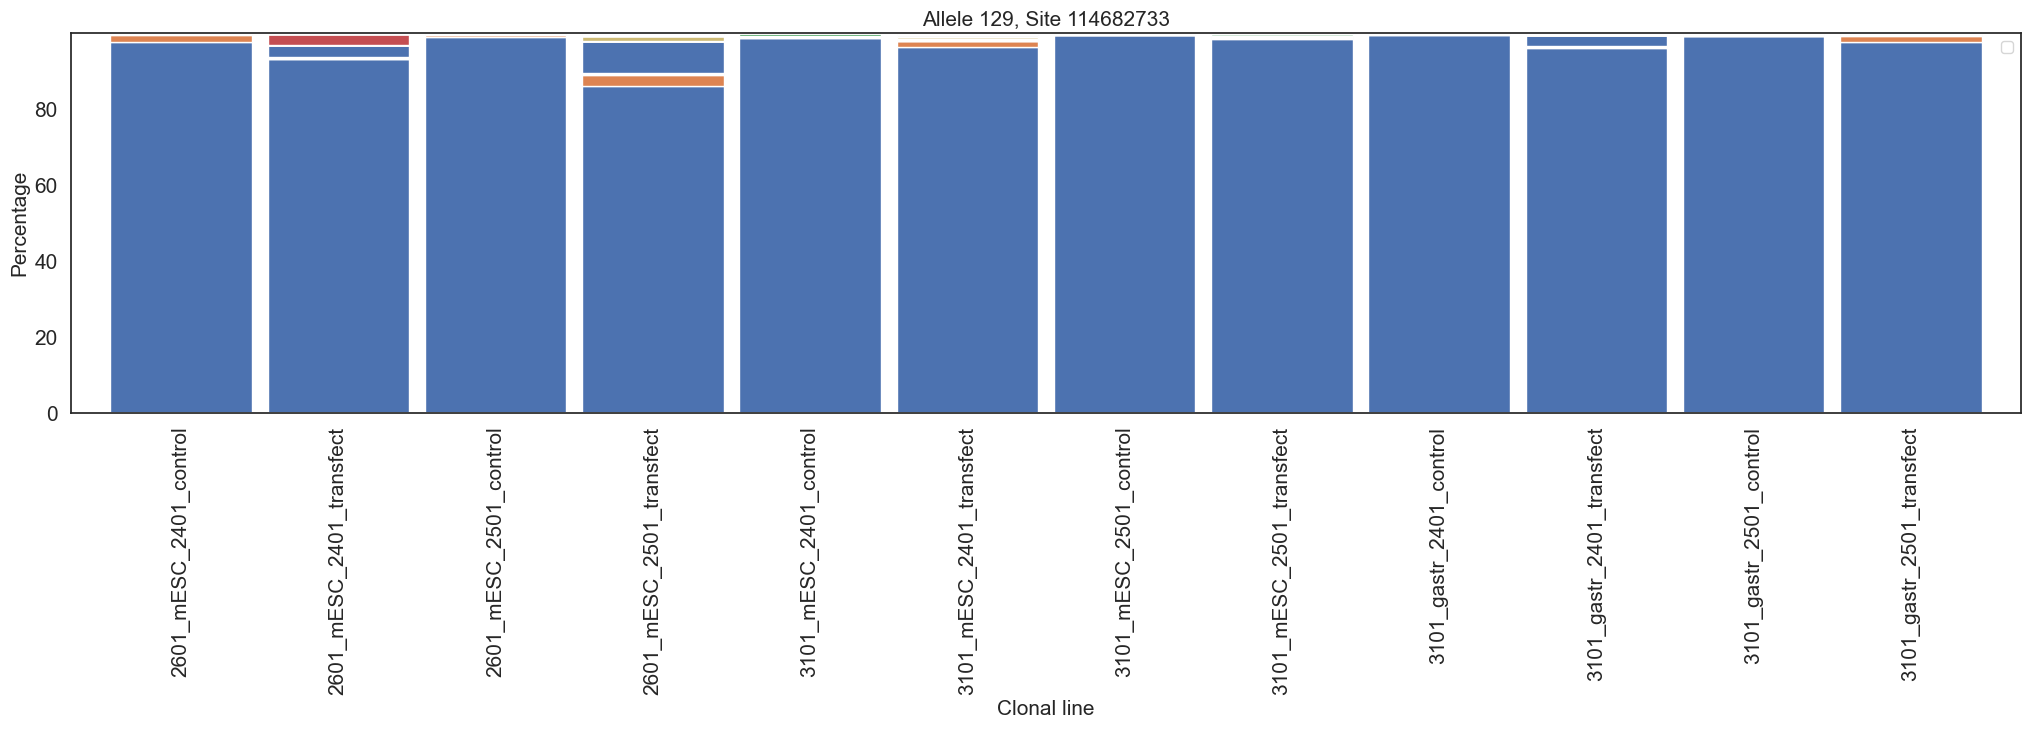

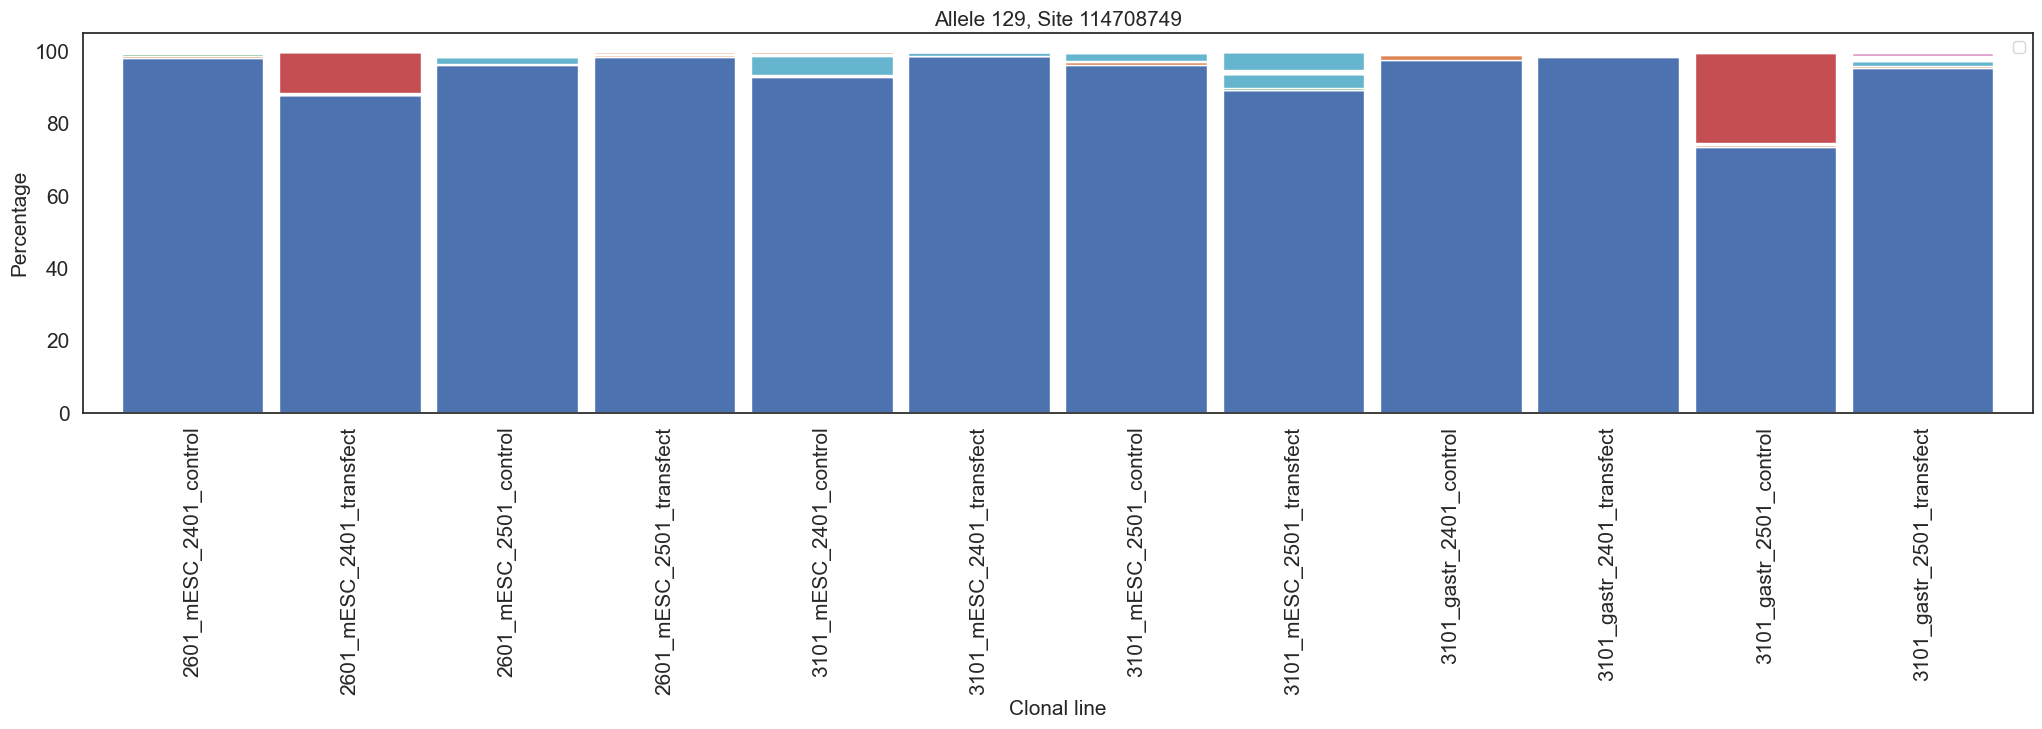

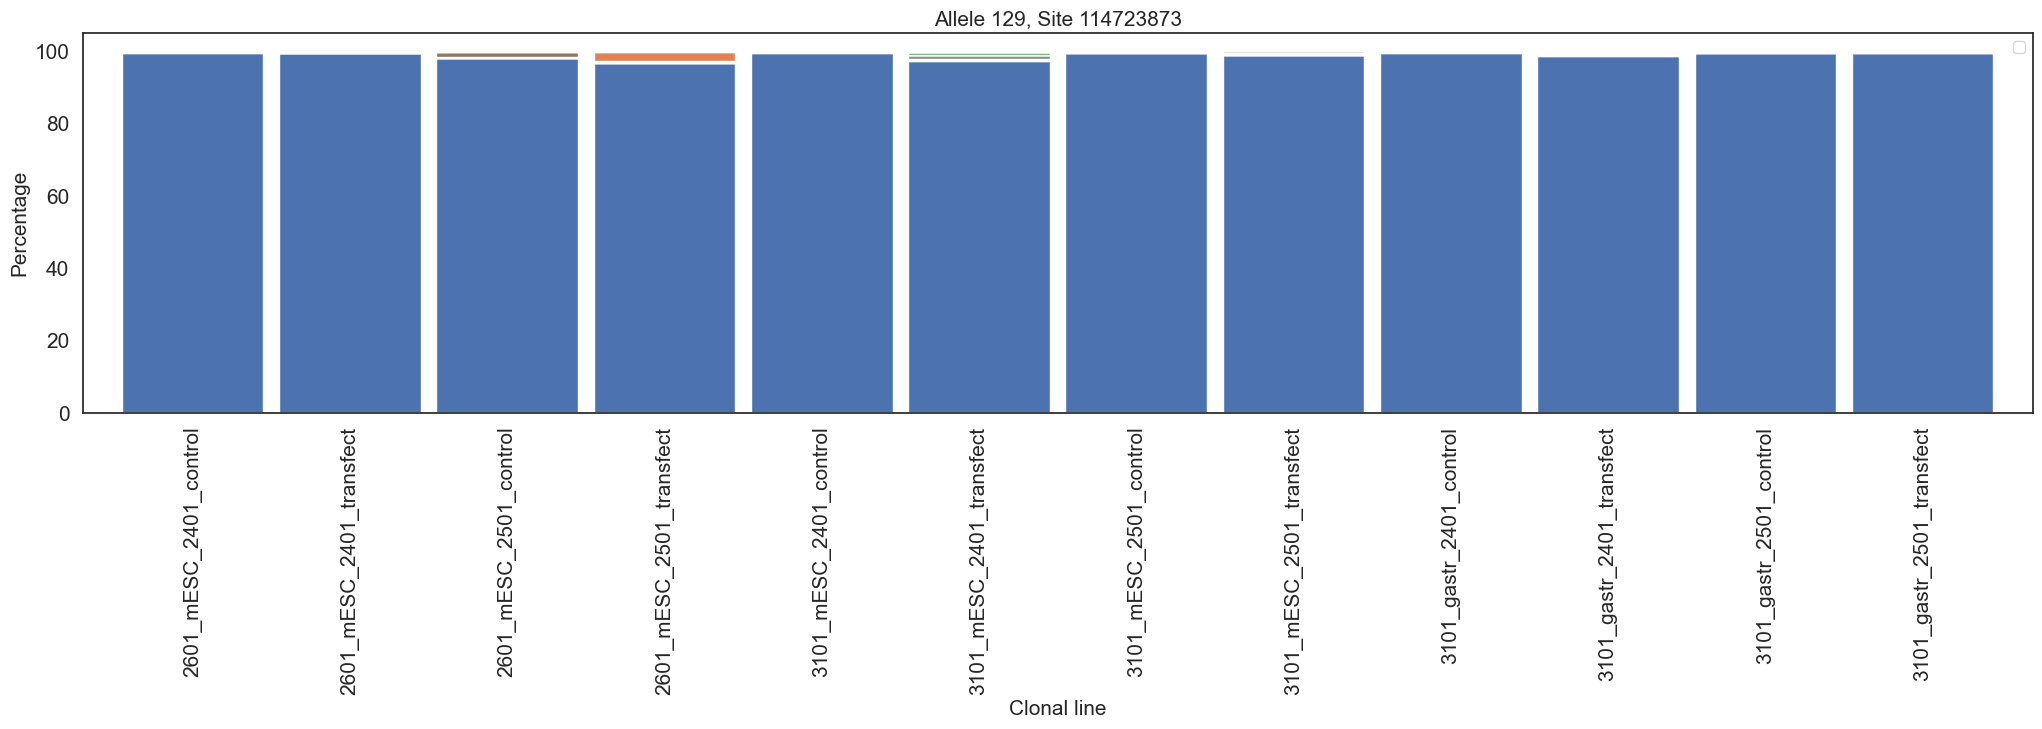

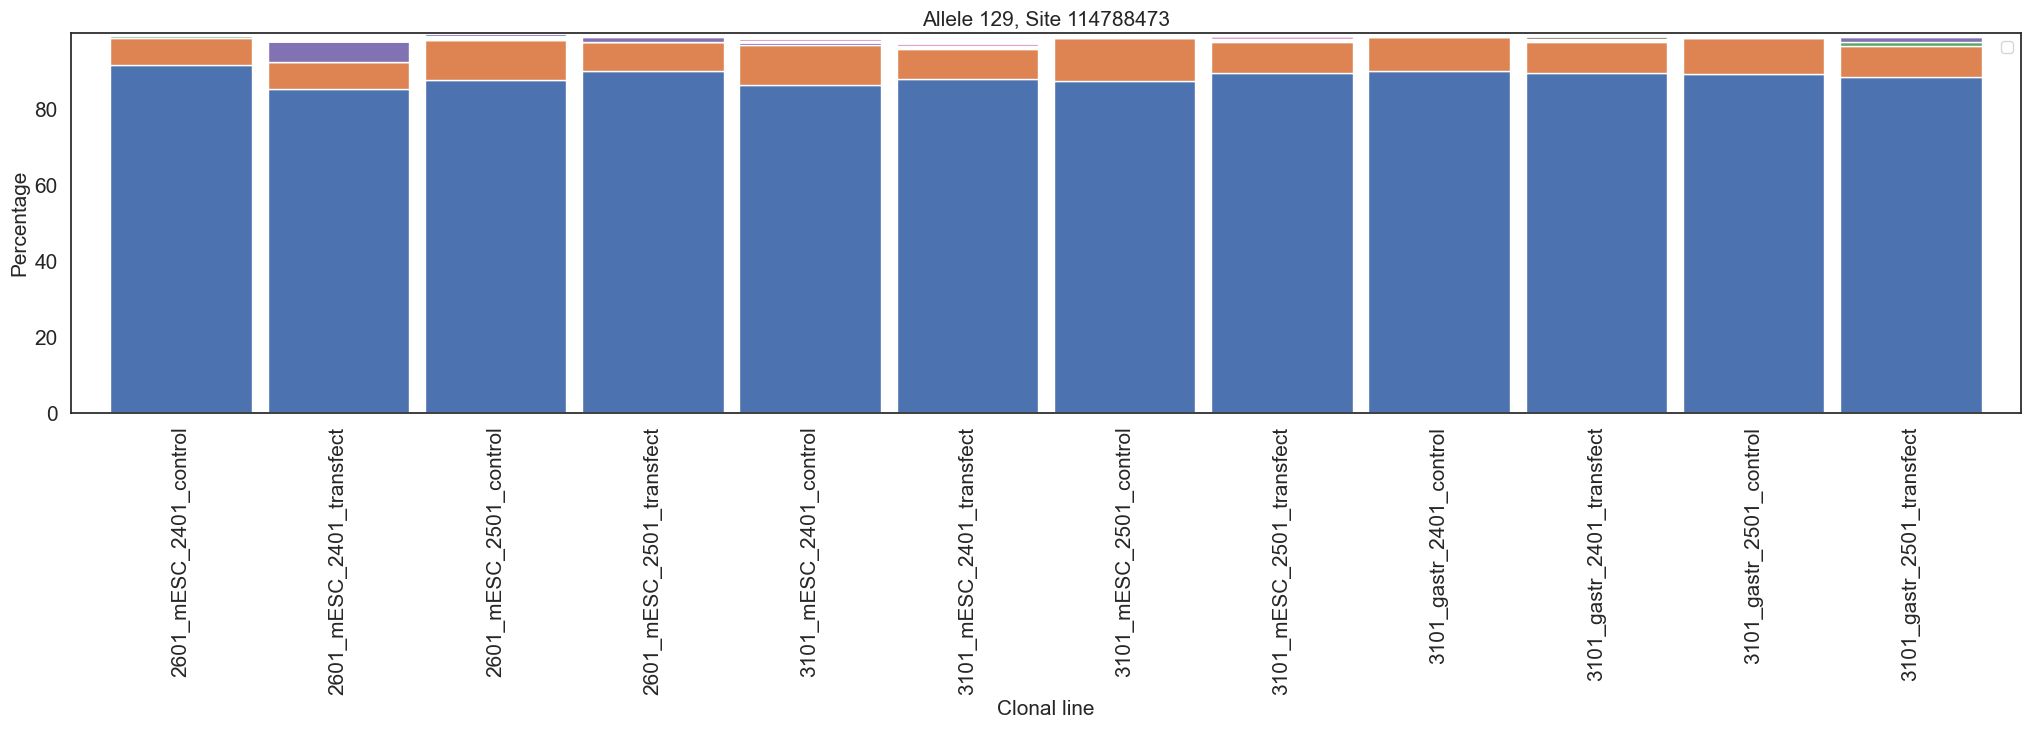

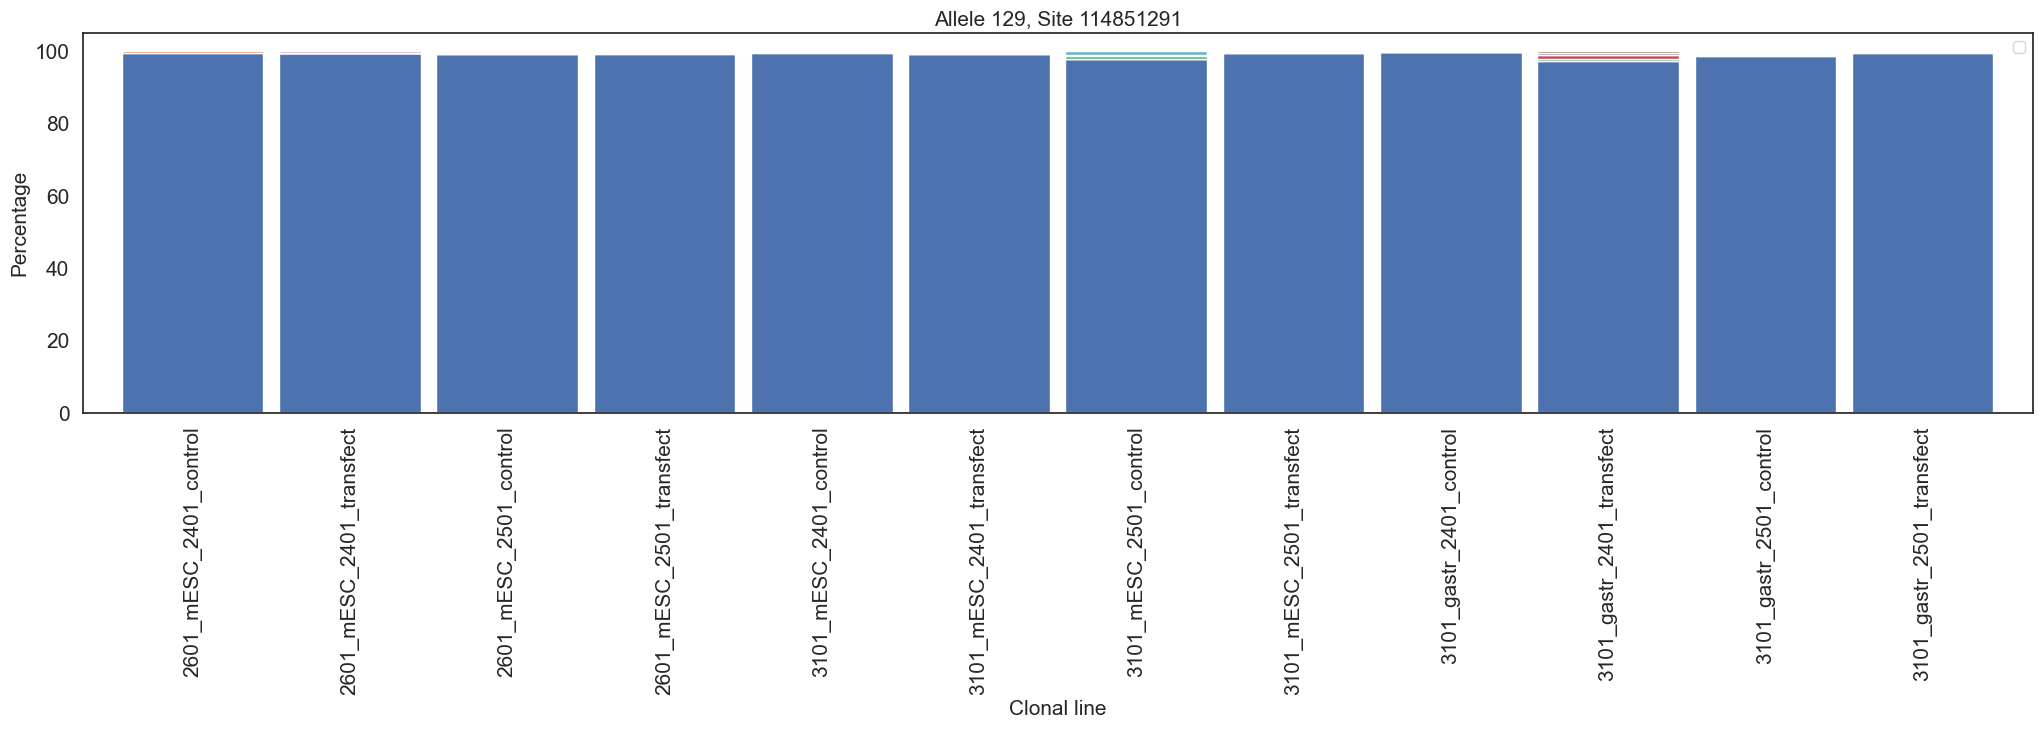

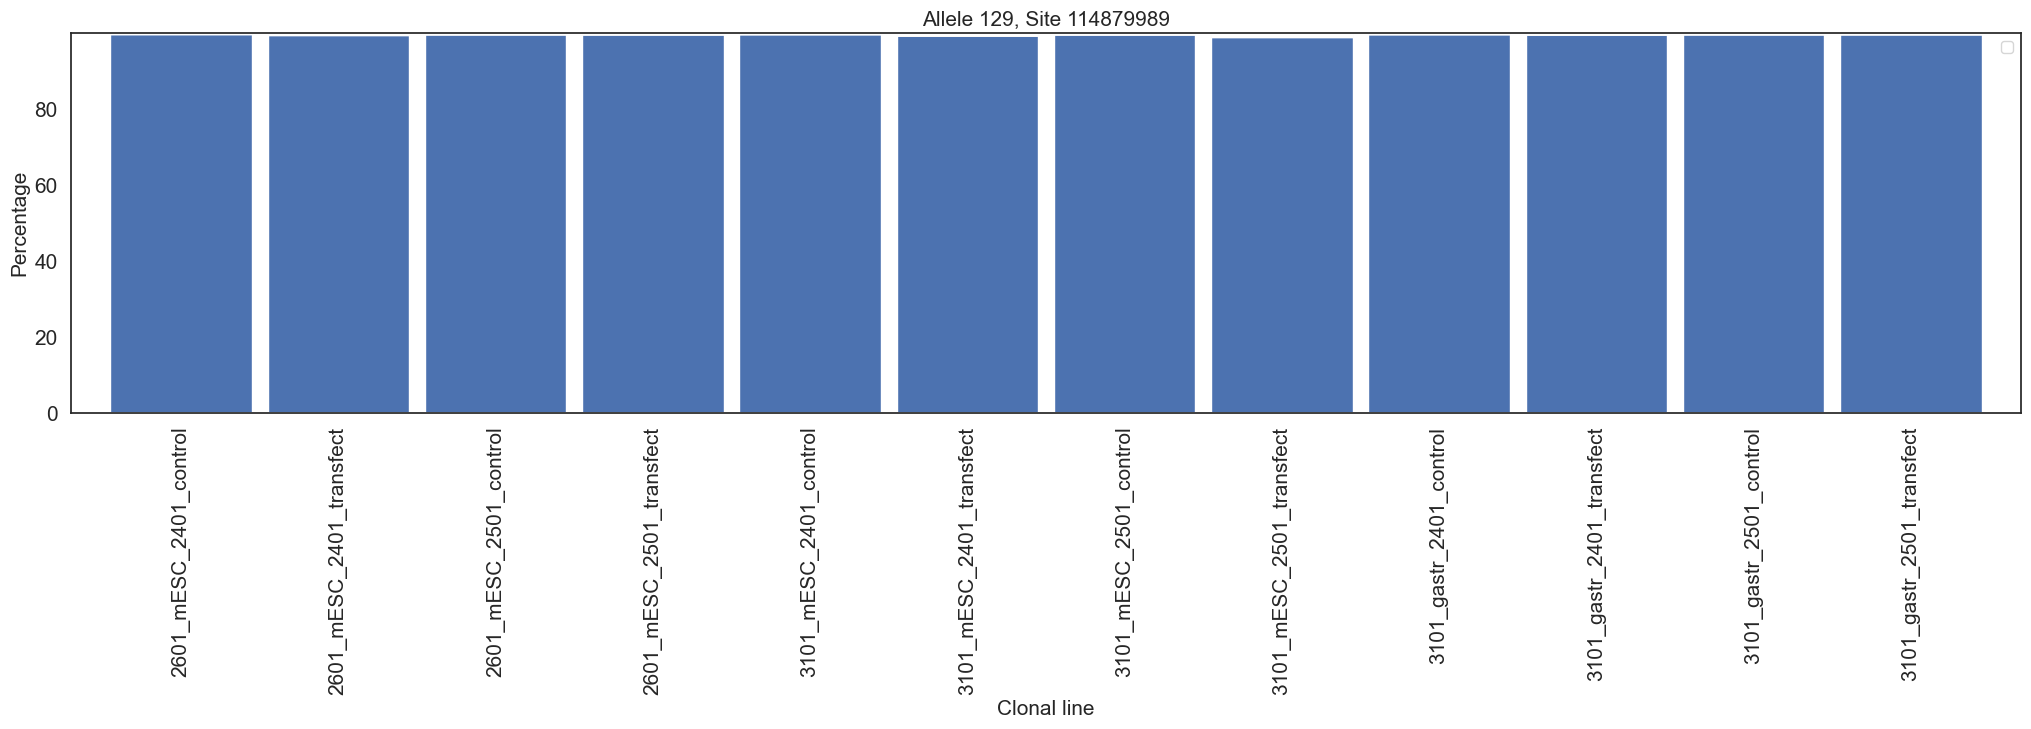

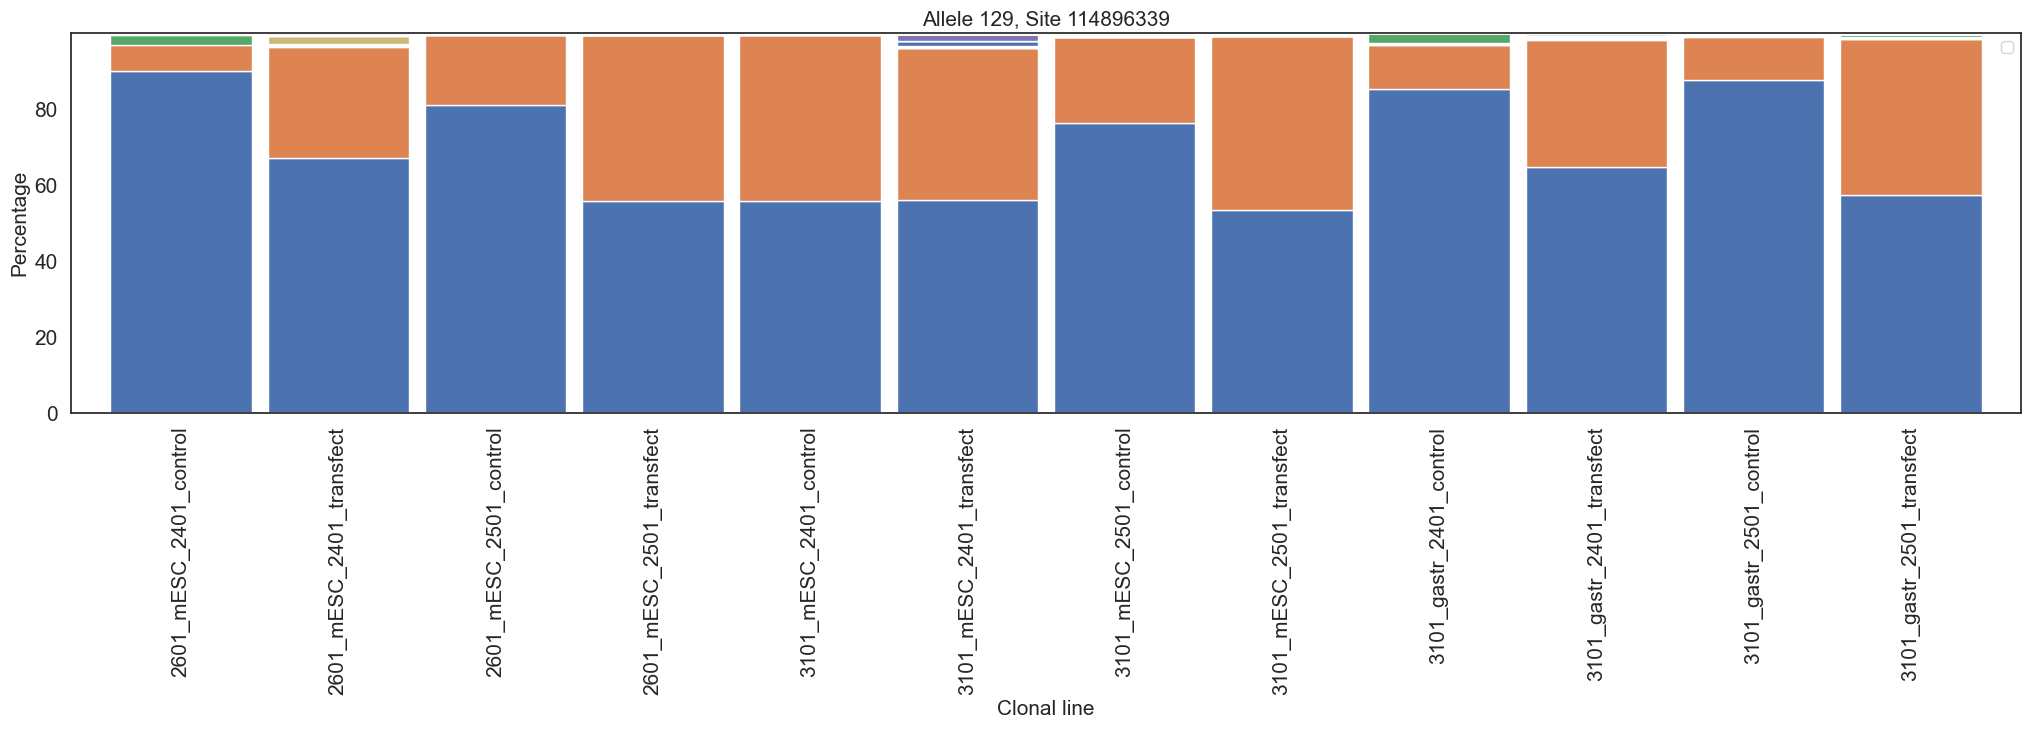

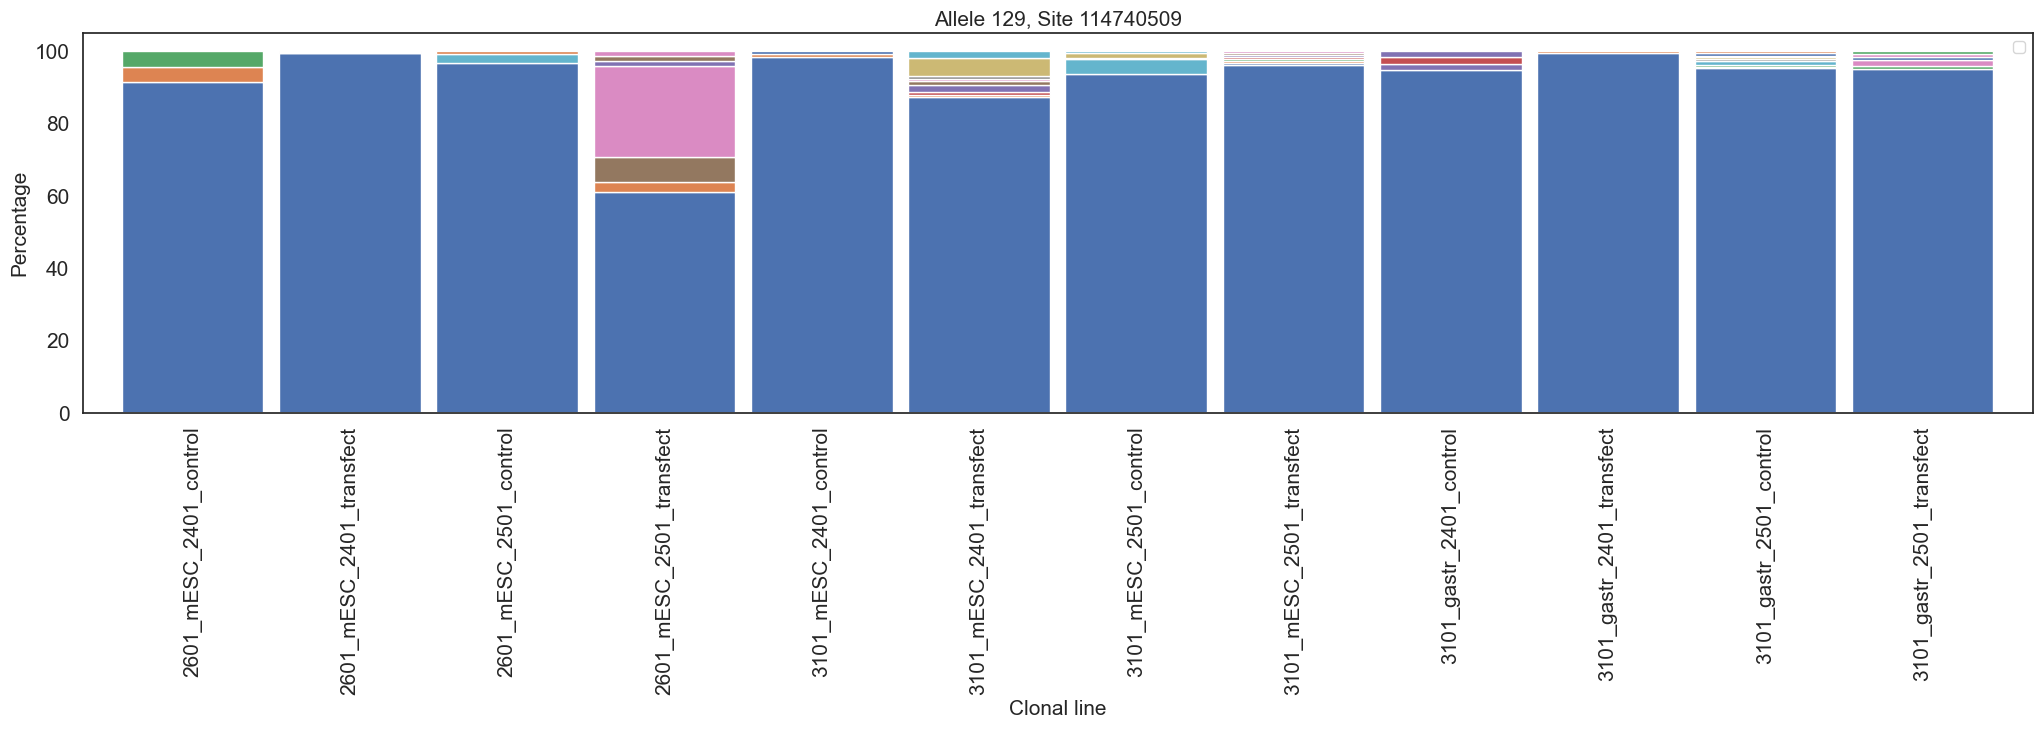

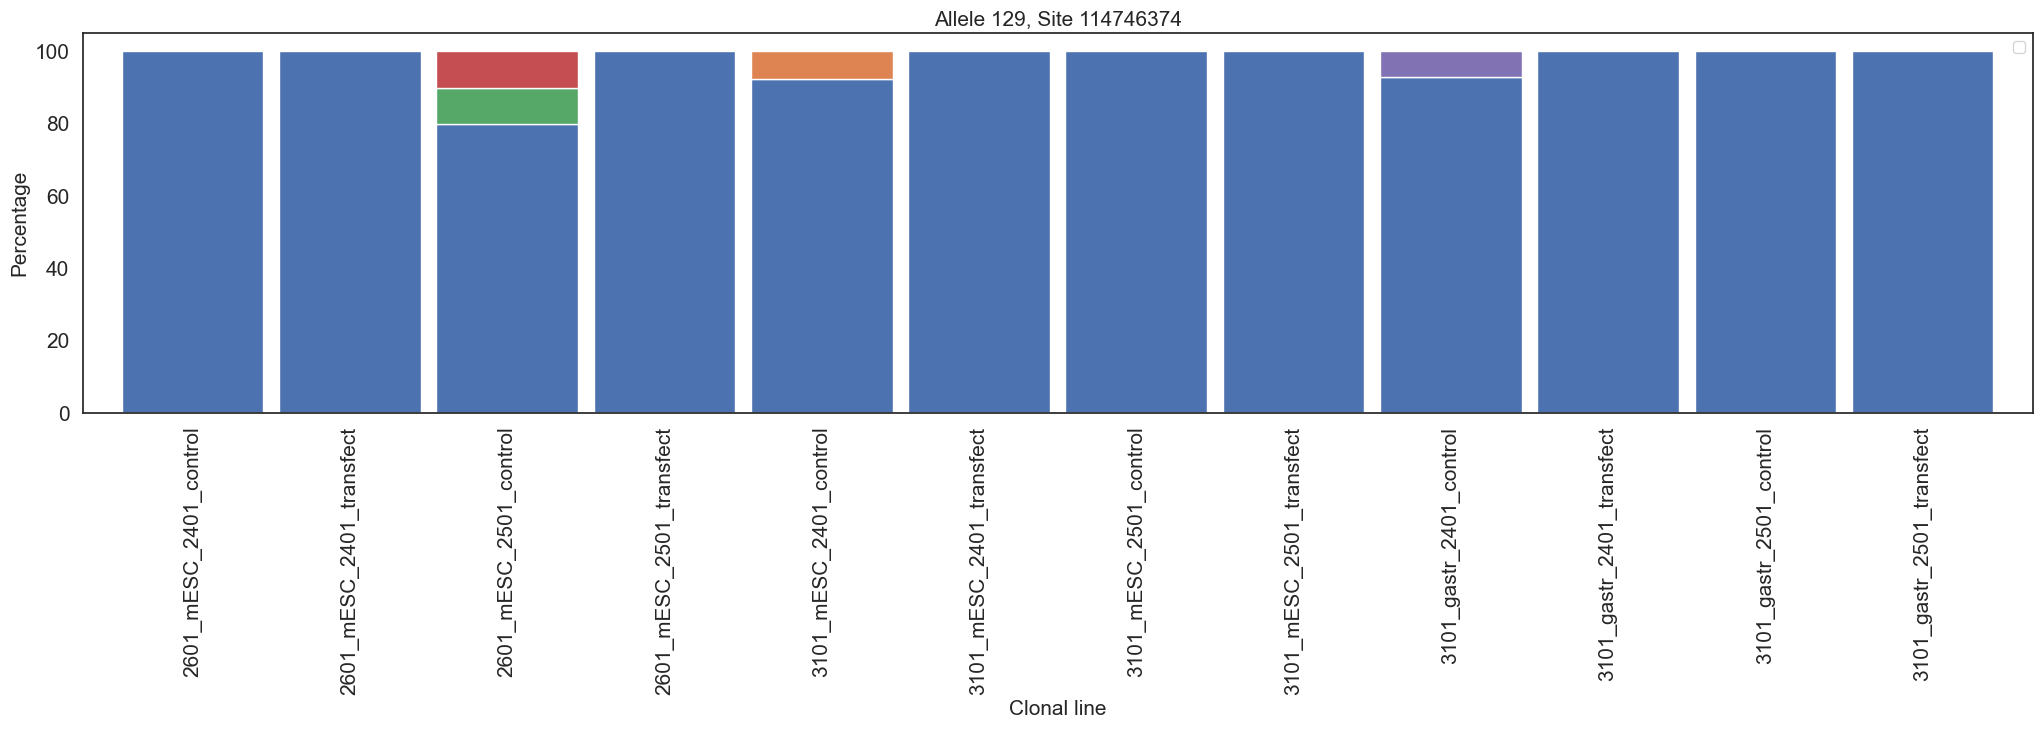

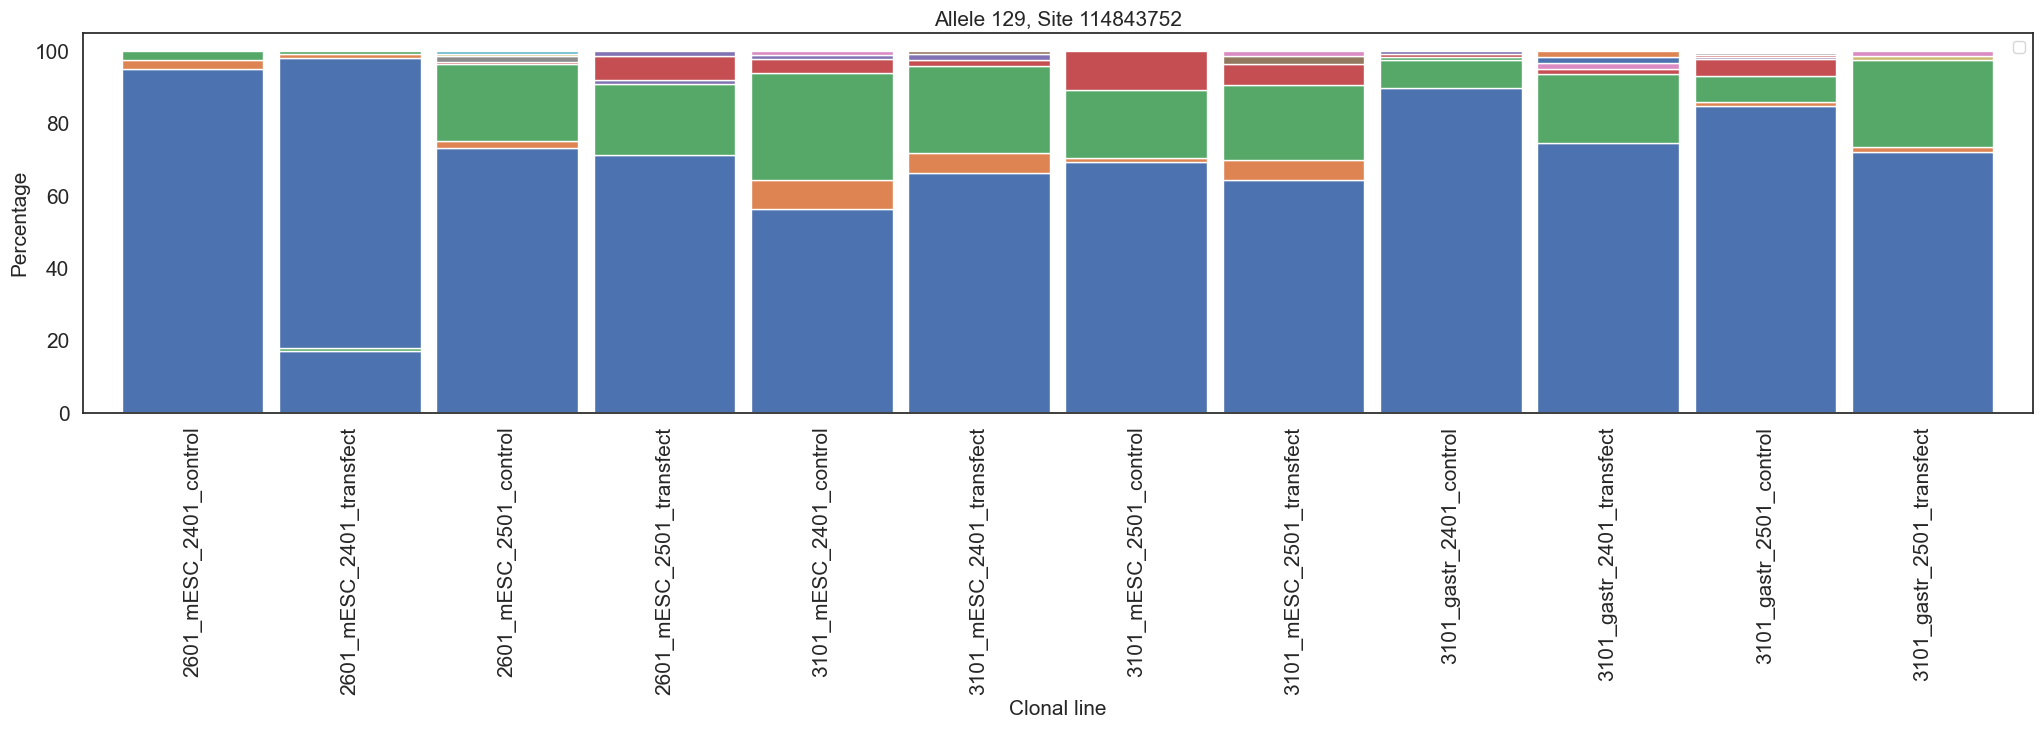

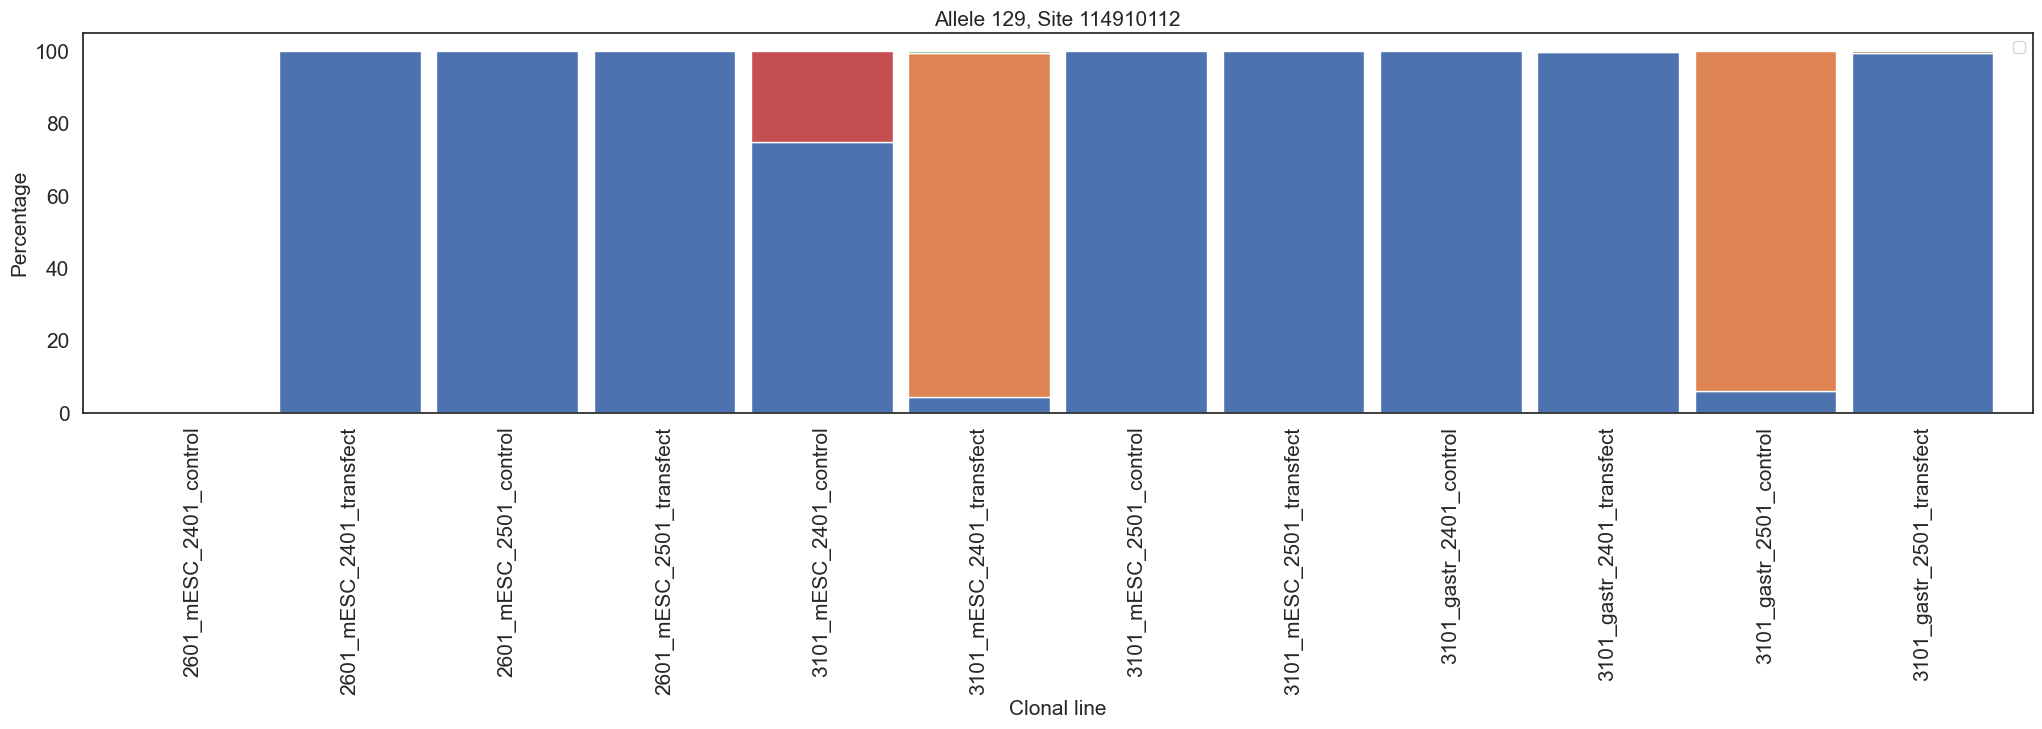

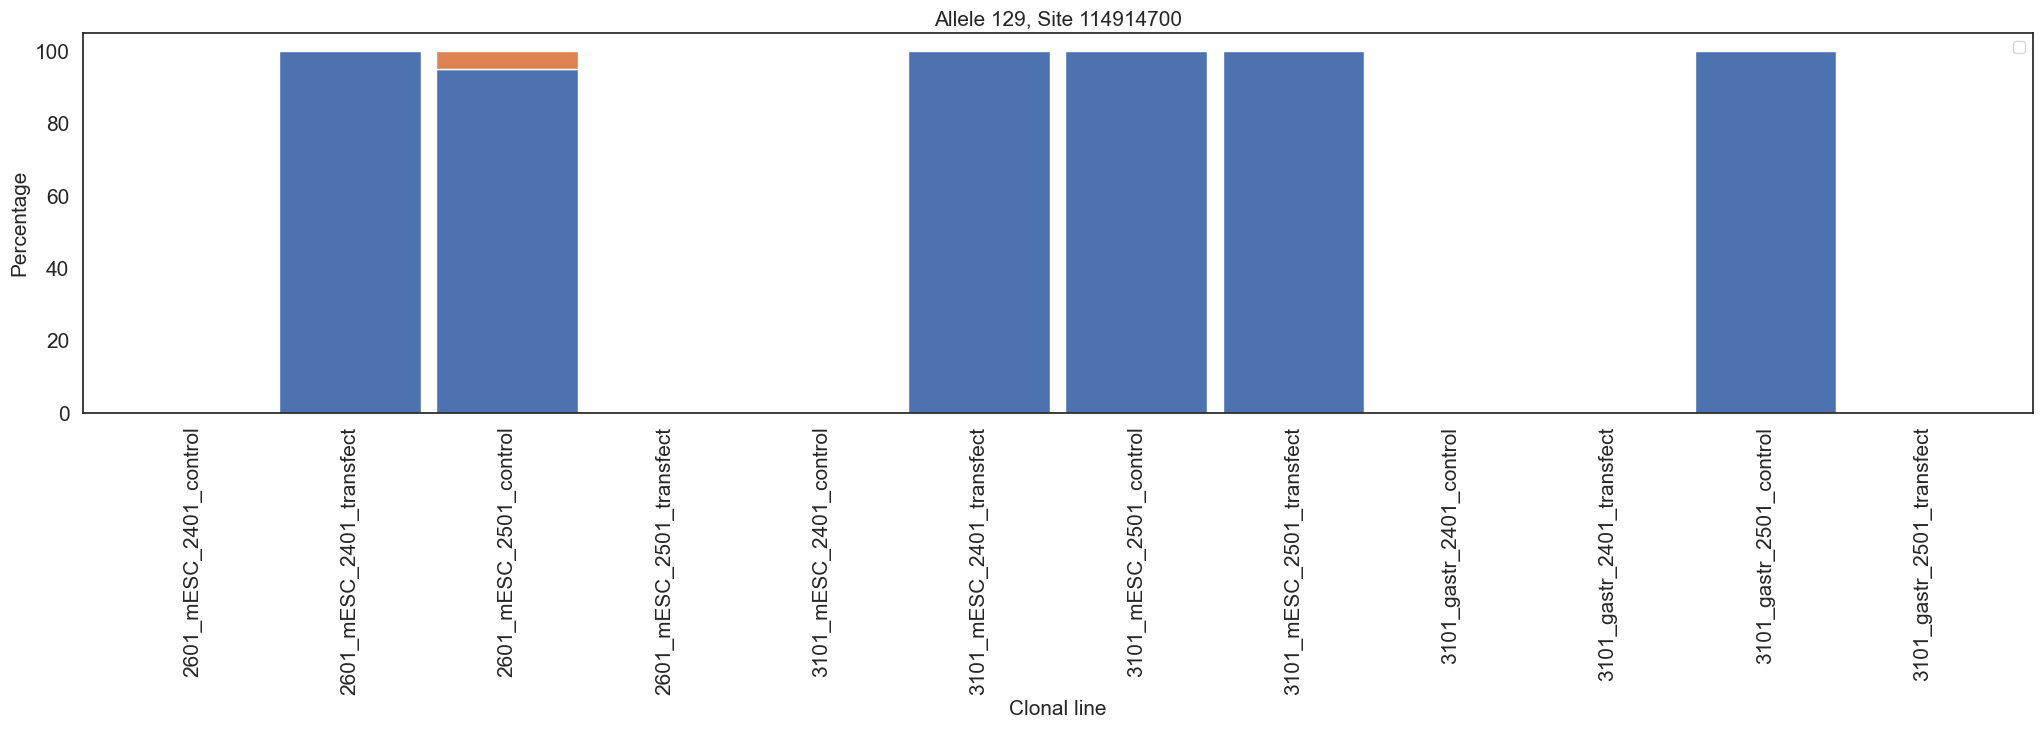

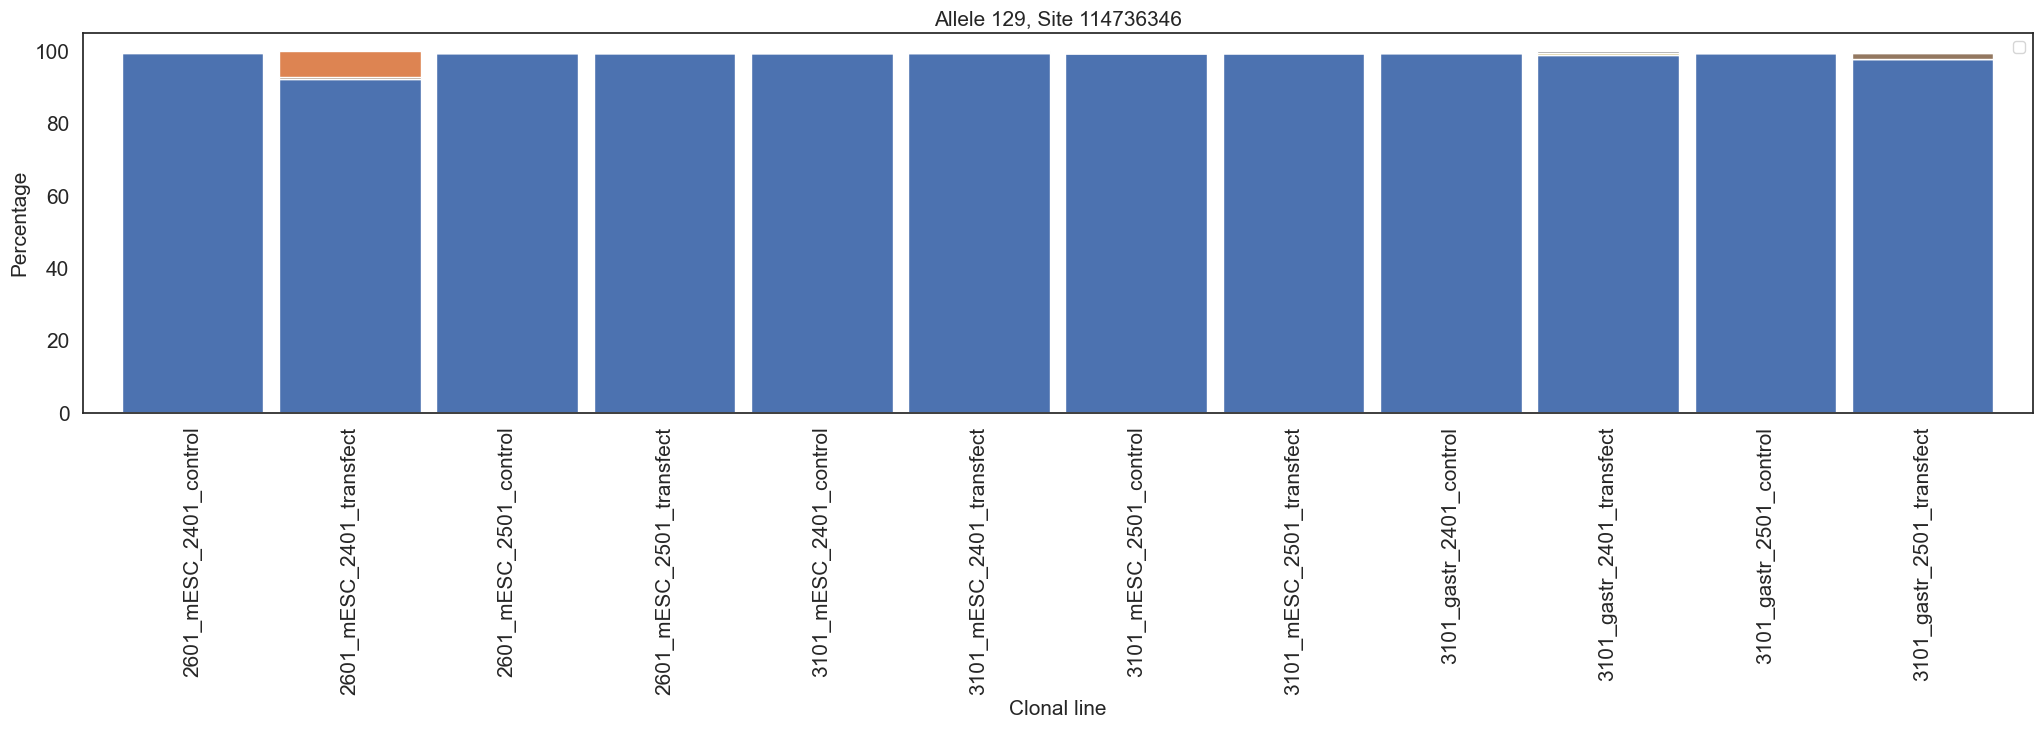

In [37]:
sites129 = targetsites

#[114682729, 114723869,114746371, 114788470, 114851288, 114879985,114896335,114736342]
#14708745,114843748,114910108
for site in sites129:
    plotPerSite(selectedpercentagesChr12_129,site, allele = 'Allele 129, ')

In [38]:
allSamples = list(selectedpercentagesChr12_129.columns)
allSamples

['2601_mESC_2401_control',
 '2601_mESC_2401_transfect',
 '2601_mESC_2501_control',
 '2601_mESC_2501_transfect',
 '3101_mESC_2401_control',
 '3101_mESC_2401_transfect',
 '3101_mESC_2501_control',
 '3101_mESC_2501_transfect',
 '3101_gastr_2401_control',
 '3101_gastr_2401_transfect',
 '3101_gastr_2501_control',
 '3101_gastr_2501_transfect']

In [39]:
sample = ''
# to plot all target sites for 1 sample:
def plotTargetSites(sample, legend = 'no', title = 'Scar profile of ' + str(sample)):

    allSites4 = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))

    for site, scar in selectedpercentagesChr12_129[sample].index:
        allSites4[scar][('129', site)] = percentagesChr12_129[sample].loc[(site,scar)]
    for site, scar in selectedpercentagesChr12_B6[sample].index:
        allSites4[scar][('B6', site)] = percentagesChr12_B6[sample].loc[(site,scar)]

    allSites4 = pd.DataFrame(allSites4)

    sns.set_style('white')
    sns.set_context("talk")
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['font.family'] = 'Arial'
    fontsize = 30
    ax = pd.DataFrame(allSites4).plot.bar(stacked=True,figsize=(15,5),fontsize = 25,width=0.90, color=cols)
    ax.set_xlabel("Target sites",fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.set_ylabel("Percentage of scars",fontsize=fontsize)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticklabels("")
    sns.despine()
    sns.set_style('white')
    sns.set_context("talk")
    #'ax.legend(bbox_to_anchor=(0.9,-0.1))
    if legend == 'no':
        ax.legend([],frameon=False)
    elif legend == 'yes':
        ax.legend(bbox_to_anchor=(0.9,-0.1))
    plt.show()

In [40]:
allSitesPerSample = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))

dict2 = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))
for sample in selectedpercentagesChr12_129.columns:
    for site, scar in selectedpercentagesChr12_129[sample].index:
        allSitesPerSample[scar][('129', site)] = percentagesChr12_129[sample].loc[(site,scar)]
    for site, scar in selectedpercentagesChr12_B6[sample].index:
        allSitesPerSample[scar][('B6', site)] = percentagesChr12_B6[sample].loc[(site,scar)]

    allSitesPerSample = pd.DataFrame(allSitesPerSample)
    allSitesPerSample = allSitesPerSample[allSitesPerSample.sum(axis=1) > 0]
    #collapsed = pd.DataFrame((allSitesPerSample/len(allSitesPerSample)).sum(axis=0)).T.rename(index = {0:sample})

    dict2[sample] = (allSitesPerSample/len(allSitesPerSample)).sum(axis=0)
    collapsed = pd.DataFrame(dict2)

In [41]:
def plotAllSamples(df, title = 'Scar profile', x = 'Days after induction',xticks = 'rotate', rotation = 45):
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['font.family'] = 'Arial'
    fontsize = 30
    ax = df.plot.bar(stacked=True,figsize=(15,5),fontsize = 25,width=0.90, color=cols)
    ax.set_xlabel(x,fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.set_ylabel("Percentage of scars",fontsize=fontsize)
    #ax.set_xticklabels("")
    #ax.set_xticklabels(rotation=45, ha='right')
    #ax.tick_params(axis = 'x',rotation=0)
    if xticks == 'rotate':
        plt.setp(ax.xaxis.get_majorticklabels(), ha='right')
        ax.tick_params(axis='x', rotation=rotation)
    if xticks == 'straight':
            ax.tick_params(axis='x', rotation=0)
    ax.set_ylim([0,100])
    sns.despine()
    #'ax.legend(bbox_to_anchor=(0.9,-0.1))
    ax.legend([],frameon=False)

In [42]:
sample = '2601_mESC_2401_control'
allSites4 = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))

for site, scar in selectedpercentagesChr12_129[sample].index:
    allSites4[scar][('129', site)] = percentagesChr12_129[sample].loc[(site,scar)]
for site, scar in selectedpercentagesChr12_B6[sample].index:
    allSites4[scar][('B6', site)] = percentagesChr12_B6[sample].loc[(site,scar)]

allSites4 = pd.DataFrame(allSites4)

allSites4

WT  \
129 114682733   97.816637   
    114708749   98.056156   
    114723873   99.674542   
    114788473   91.585963   
    114851291   99.514563   
    114879989   99.831753   
    114896339   89.992697   
    114740509   91.489362   
    114746374  100.000000   
    114843752   95.121951   
    114910112         NaN   
    114914700         NaN   
    114736346   99.654435   
B6  114682733  100.000000   
    114708749   99.590155   
    114723873   99.600116   
    114788473  100.000000   
    114851291   99.599356   
    114879989   98.735955   
    114896339  100.000000   
    114740509   82.472138   
    114746374  100.000000   
    114910112         NaN   
    114914700   99.852071   
    114736346   99.819495   
    114843752         NaN   

               114682783.D,114682784.D,114682785.D,114682786.D,114682787.D  \
129 114682733                                             1.7838             
    114708749                                                NaN             
    114723873                                                NaN             
    114788473                                                NaN             
    114851291                                                NaN             
    114879989                                                NaN             
    114896339                                                NaN             
    114740509                                                NaN             
    114746374                                                NaN             
    114843752                                                NaN             
    114910112                                                NaN             
    114914700                                                NaN             
    114736346                                                NaN             
B6  114682733                                                NaN             
    114708749                                                NaN             
    114723873                                                NaN             
    114788473                                                NaN             
    114851291                                                NaN             
    114879989                                                NaN             
    114896339                                                NaN             
    114740509                                                NaN             
    114746374                                                NaN             
    114910112                                                NaN             
    114914700                                                NaN             
    114736346                                                NaN             
    114843752                                                NaN             

               114682941.D  114682943.D  114682945.D  114682944.D  \
129 114682733     0.111626     0.056183     0.050269     0.036593   
    114708749          NaN          NaN          NaN          NaN   
    114723873          NaN          NaN          NaN          NaN   
    114788473          NaN          NaN          NaN          NaN   
    114851291          NaN          NaN          NaN          NaN   
    114879989          NaN          NaN          NaN          NaN   
    114896339          NaN          NaN          NaN          NaN   
    114740509          NaN          NaN          NaN          NaN   
    114746374          NaN          NaN          NaN          NaN   
    114843752          NaN          NaN          NaN          NaN   
    114910112          NaN          NaN          NaN          NaN   
    114914700          NaN          NaN          NaN          NaN   
    114736346          NaN          NaN          NaN          NaN   
B6  114682733          NaN          NaN          NaN          NaN   
    114708749          NaN          NaN          NaN          NaN   
    114723873          NaN  

In [43]:
sample = ''
# to plot all target sites for 1 sample:
def plotTargetSites(sample, legend = 'no', title = 'Scar profile of ' + str(sample)):

    allSites4 = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))

    for site, scar in selectedpercentagesChr12_129[sample].index:
        allSites4[scar][('129', site)] = percentagesChr12_129[sample].loc[(site,scar)]
    for site, scar in selectedpercentagesChr12_B6[sample].index:
        allSites4[scar][('B6', site)] = percentagesChr12_B6[sample].loc[(site,scar)]

    allSites4 = pd.DataFrame(allSites4)

    sns.set_style('white')
    sns.set_context("talk")
    mpl.rcParams['pdf.fonttype'] = 42
    mpl.rcParams['ps.fonttype'] = 42
    mpl.rcParams['font.family'] = 'Arial'
    fontsize = 30
    ax = pd.DataFrame(allSites4).plot.bar(stacked=True,figsize=(15,5),fontsize = 25,width=0.90, color=cols)
    ax.set_xlabel("Target sites",fontsize=fontsize)
    ax.set_title(title, fontsize=fontsize)
    ax.set_ylabel("Percentage of scars",fontsize=fontsize)
    ax.tick_params(axis='x', rotation=90)
    ax.set_xticklabels("")
    sns.despine()
    sns.set_style('white')
    sns.set_context("talk")
    #'ax.legend(bbox_to_anchor=(0.9,-0.1))
    if legend == 'no':
        ax.legend([],frameon=False)
    elif legend == 'yes':
        ax.legend(bbox_to_anchor=(0.9,-0.1))
    plt.show()

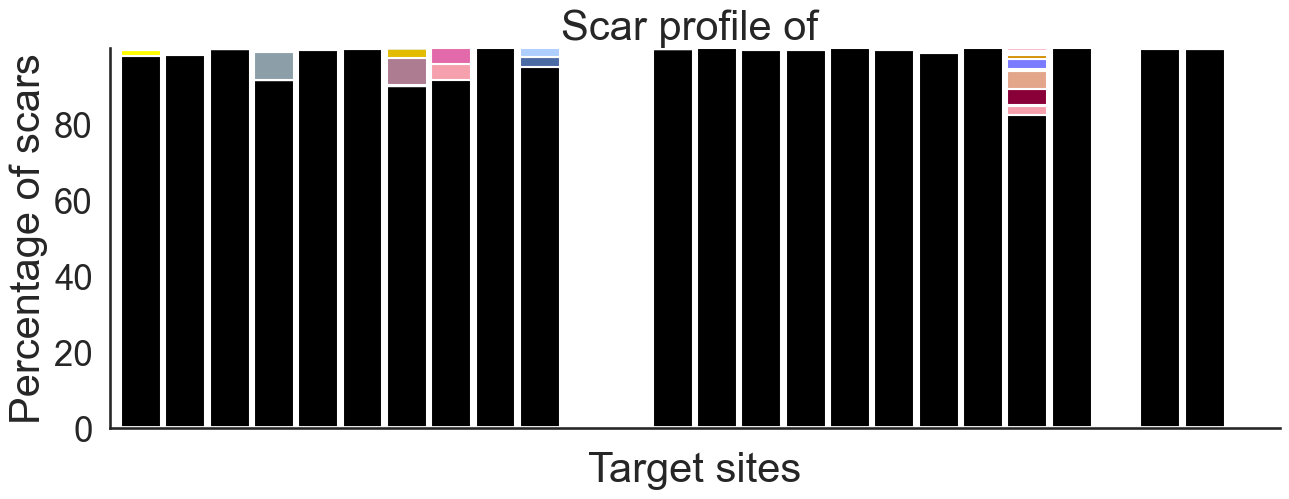

/Users/m.blotenburg/miniconda3/envs/scanpy2/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


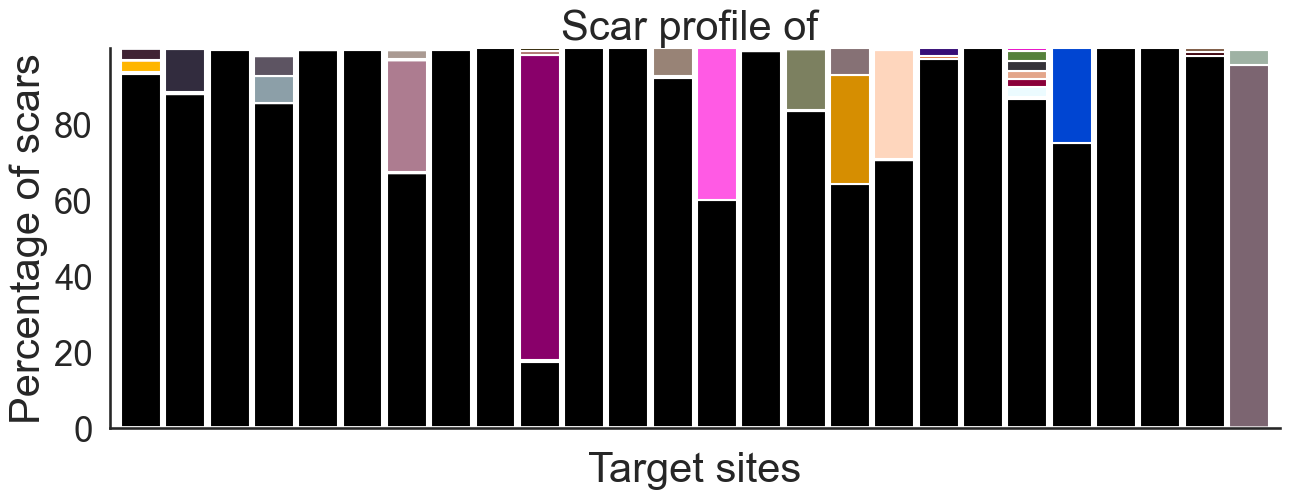

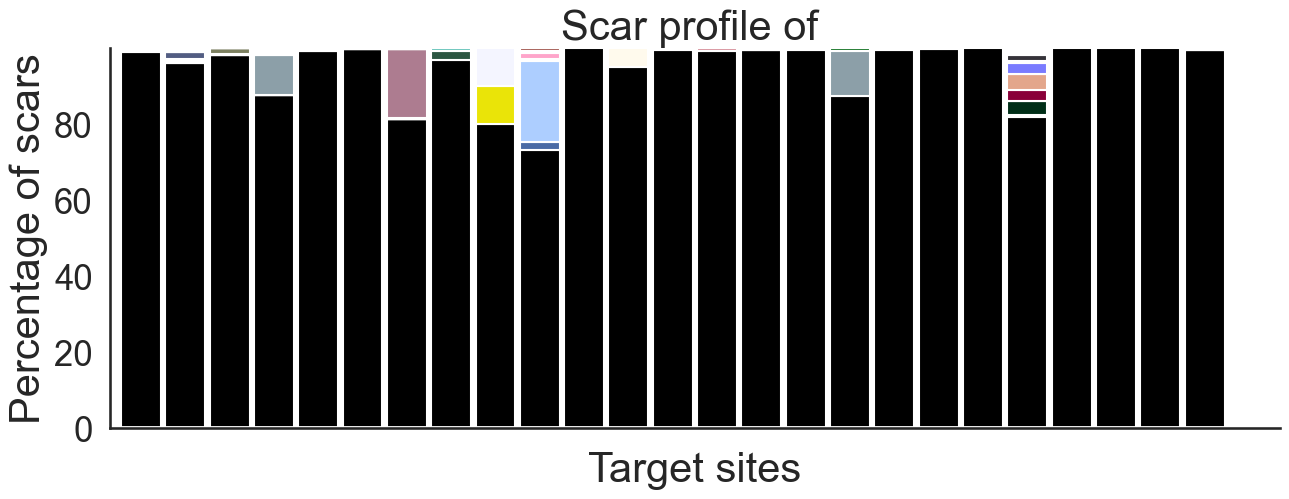

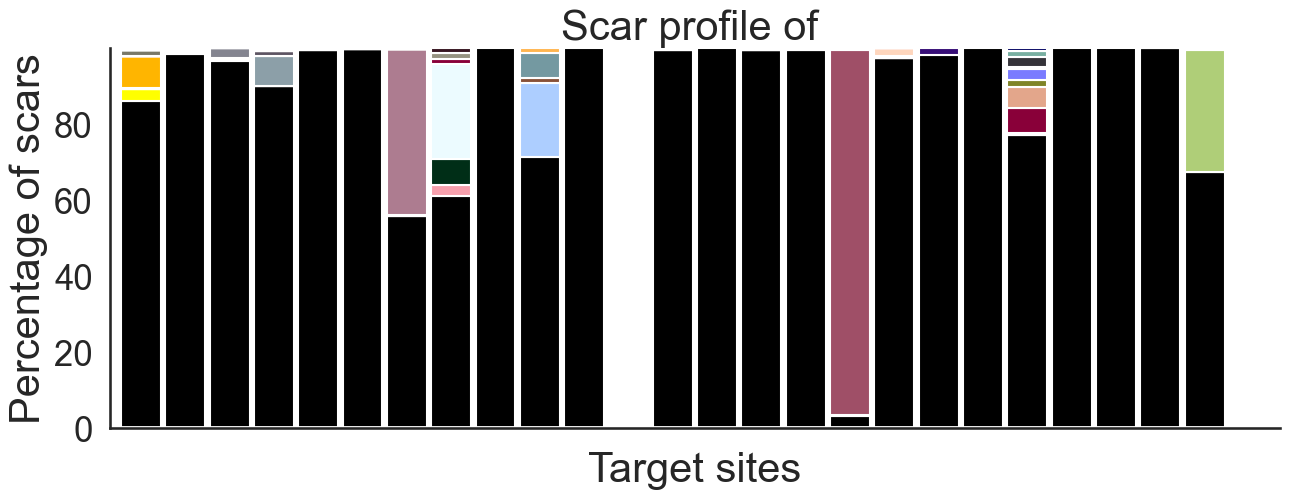

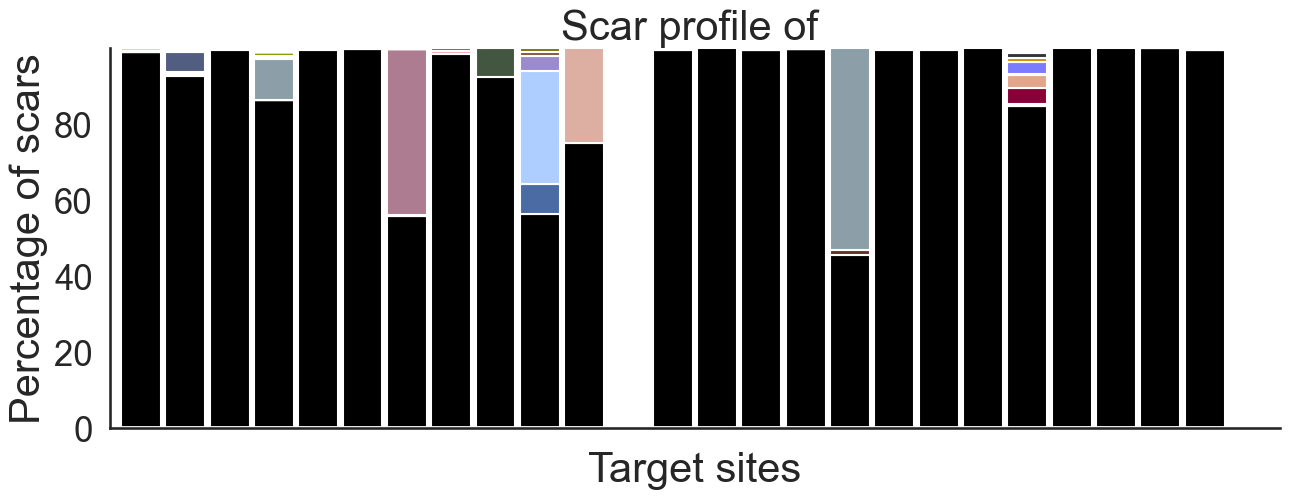

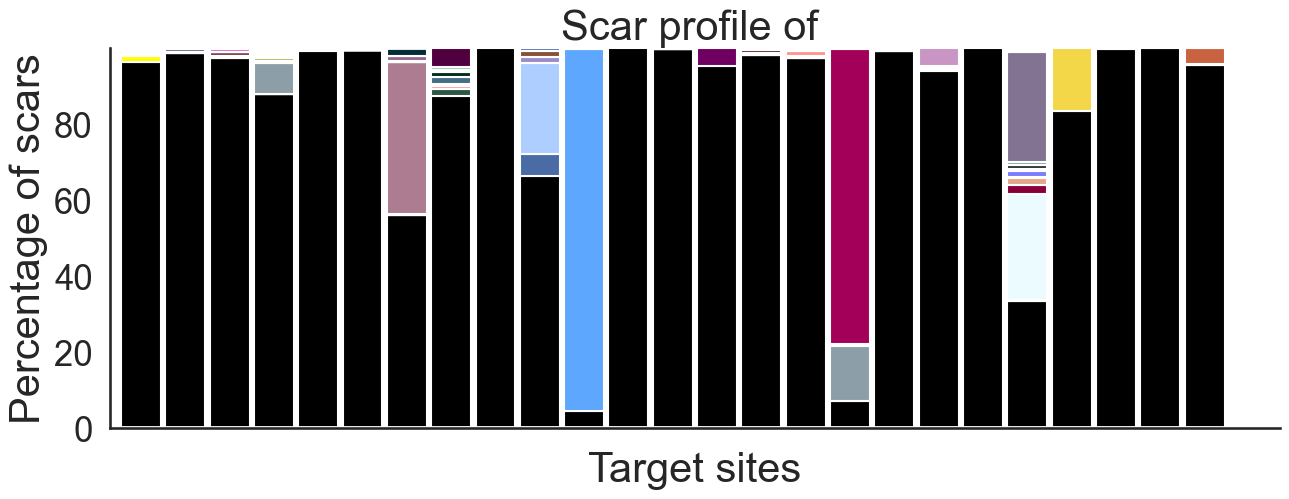

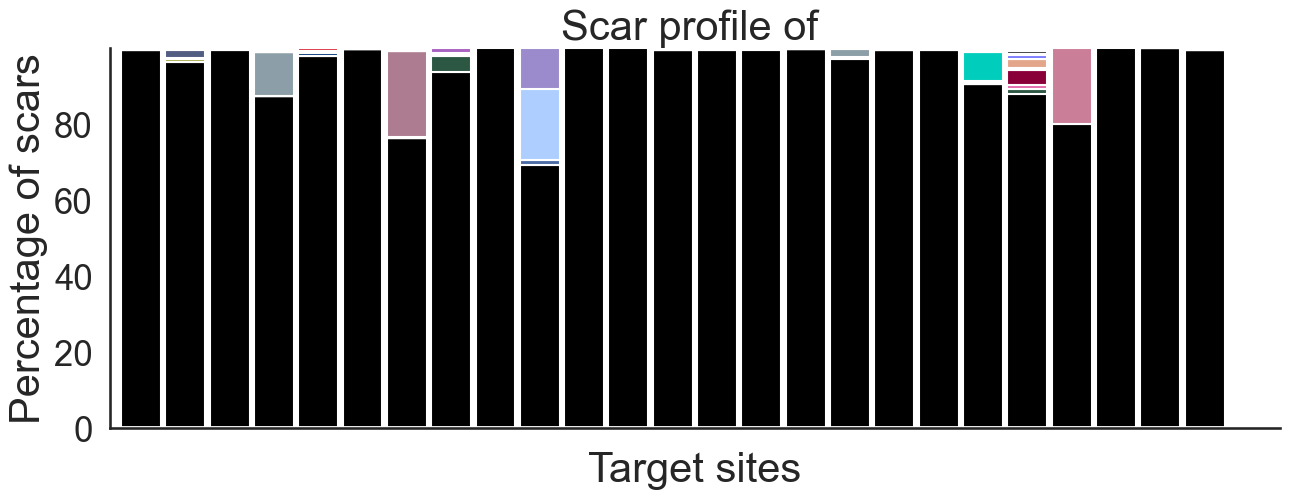

/Users/m.blotenburg/miniconda3/envs/scanpy2/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


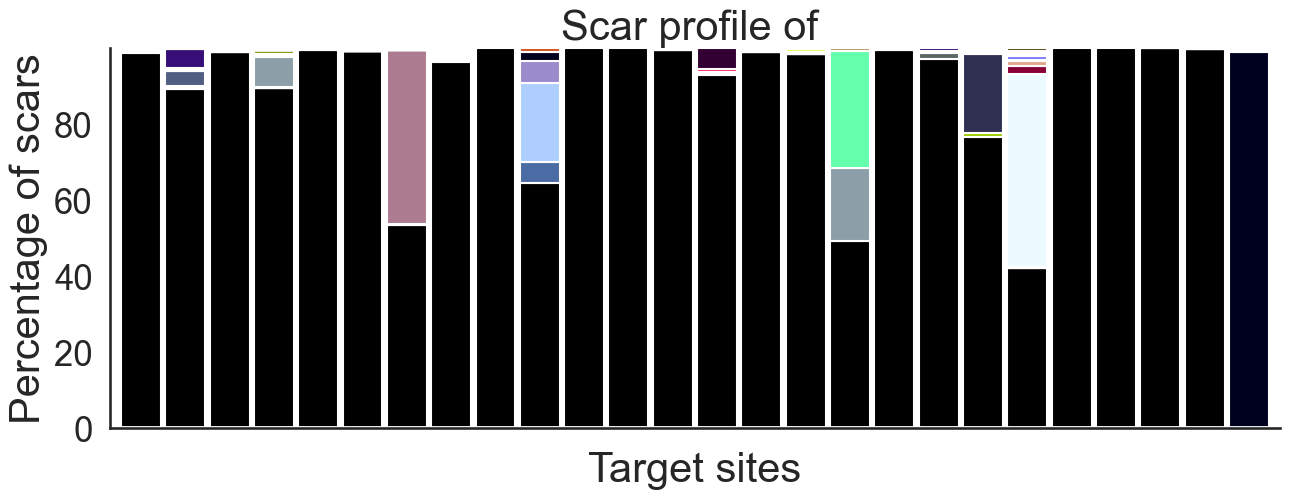

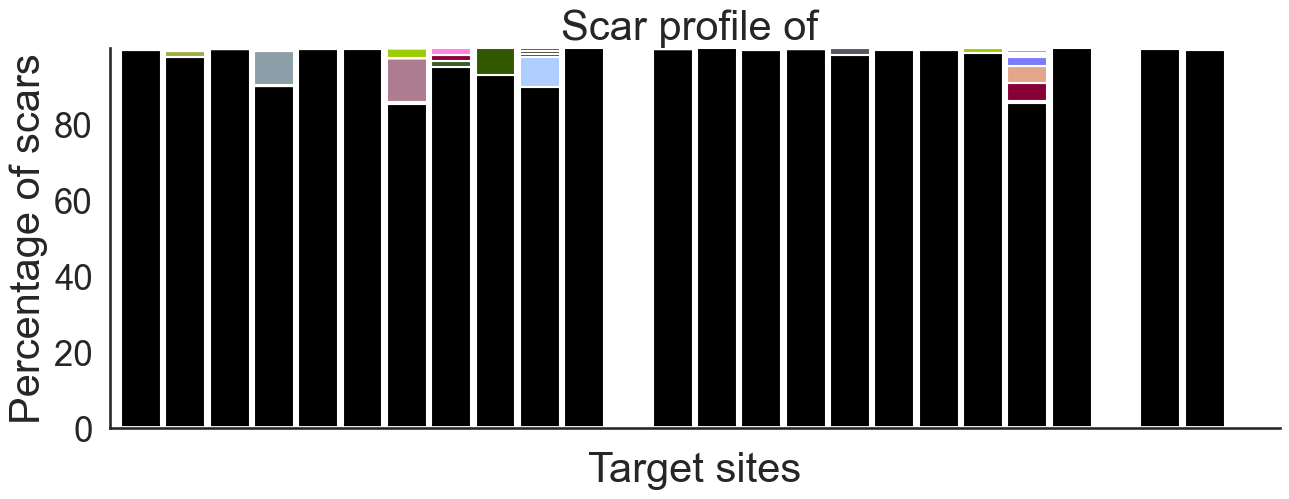

/Users/m.blotenburg/miniconda3/envs/scanpy2/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


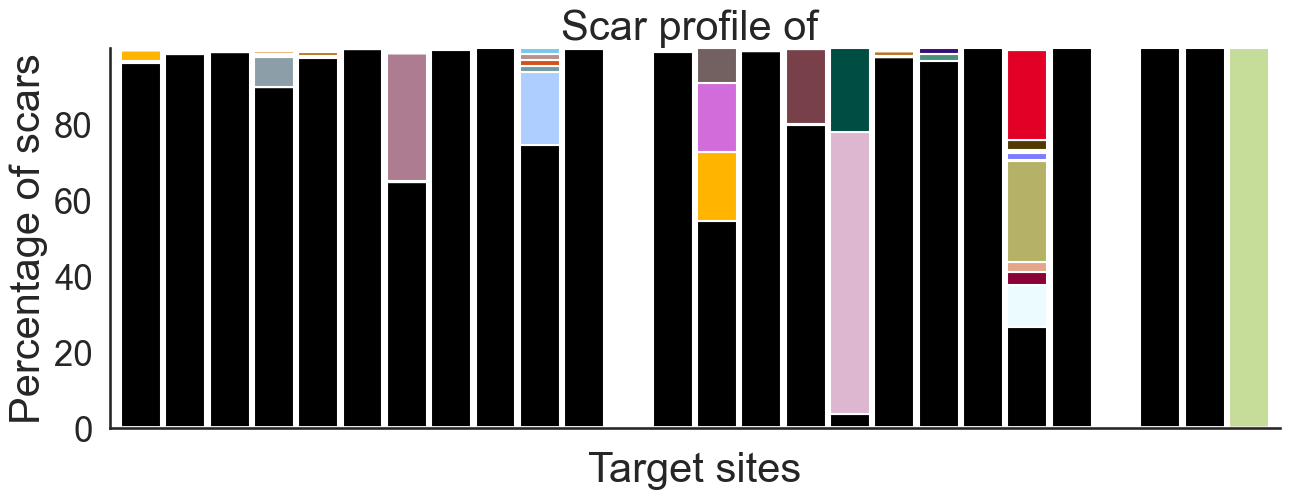

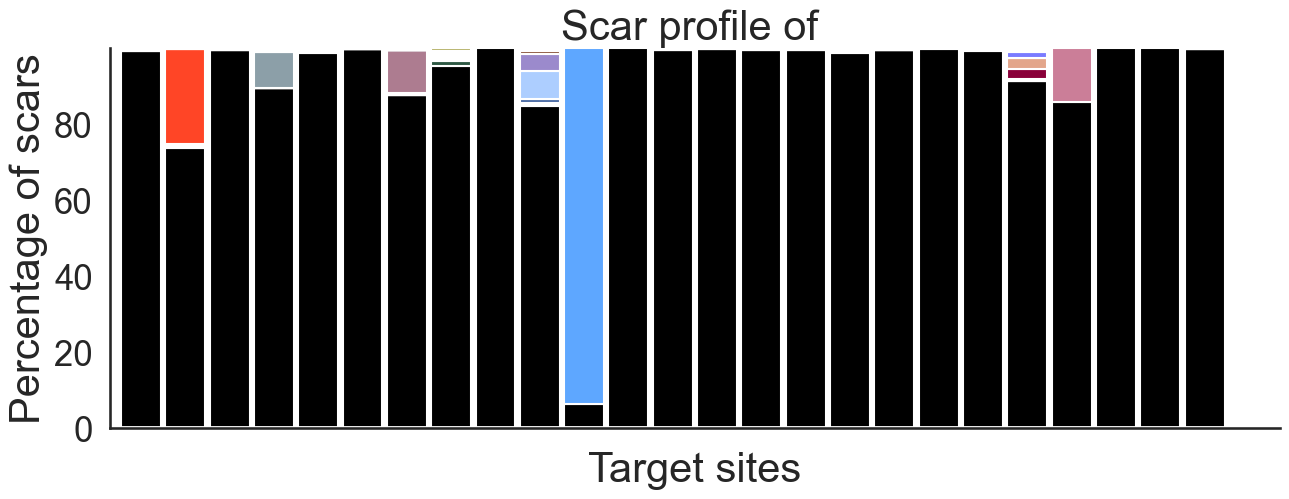

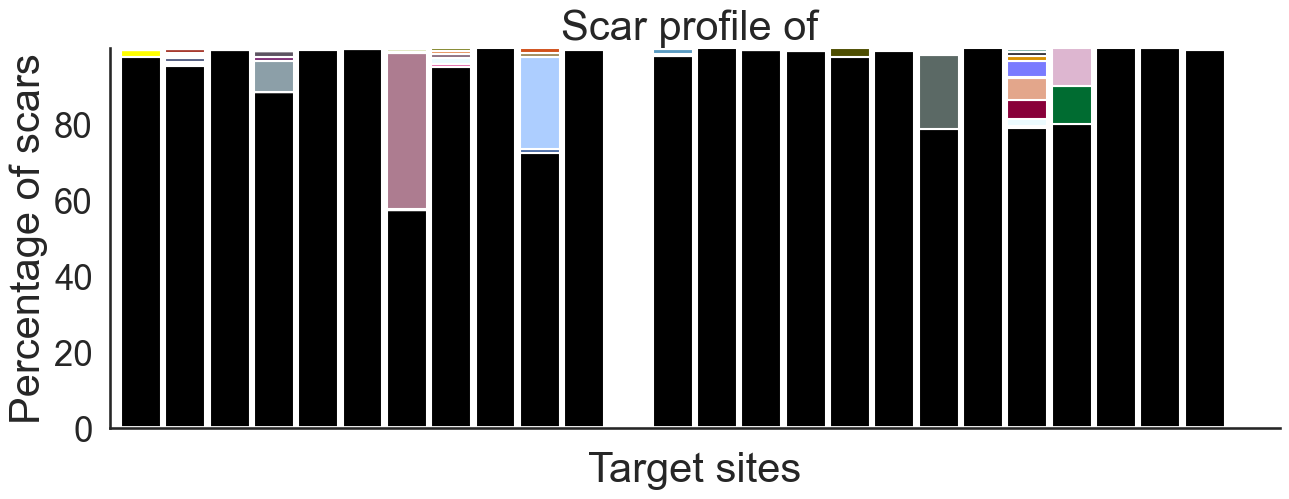

In [45]:
for sample in collapsed.columns:
    plotTargetSites(sample)

In [46]:
listOfNames = ['Scar profile of transfection I - mESC control day 0', 'Scar profile of transfection I - mESC transfected day 0',
       'Scar profile of transfection II - mESC control day 0', 'Scar profile of transfection II - mESC transfected day 0',
       'Scar profile of transfection I - mESC control day 7', 'Scar profile of transfection I - mESC transfected day 7',
       'Scar profile of transfection II - mESC control day 7', 'Scar profile of transfection II - mESC transfected day 7',
       'Scar profile of transfection I - gastruloid control day 7', 'Scar profile of transfection I - gastruloid transfected day 7',
       'Scar profile of transfection II - gastruloid control day 7', 'Scar profile of transfection II - gastruloid transfected day 7',]

0 2601_mESC_2401_control Scar profile of transfection I - mESC control day 0


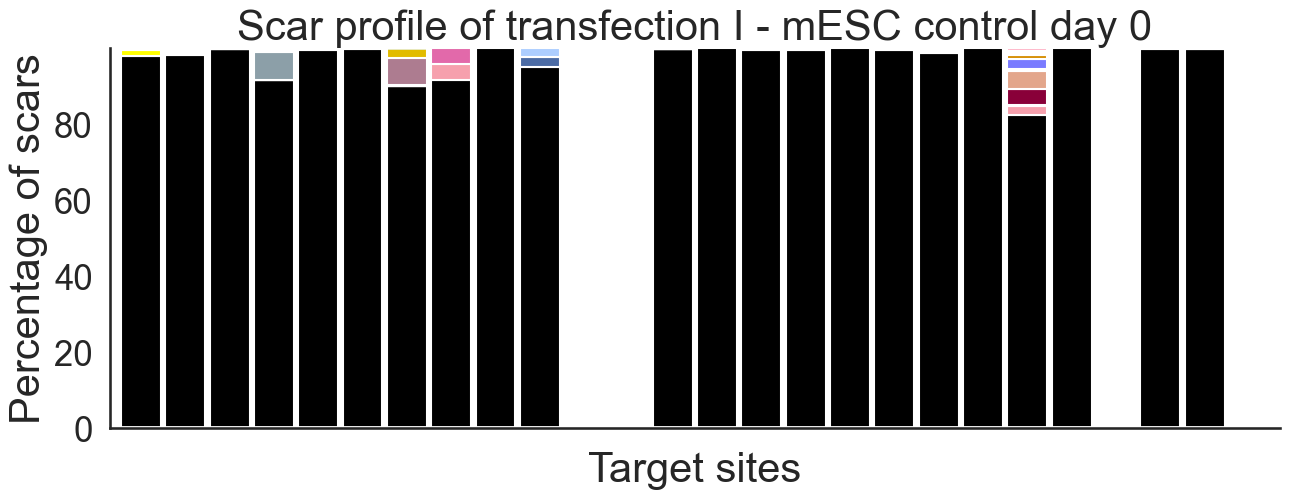

1 2601_mESC_2401_transfect Scar profile of transfection I - mESC transfected day 0


/Users/m.blotenburg/miniconda3/envs/scanpy2/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


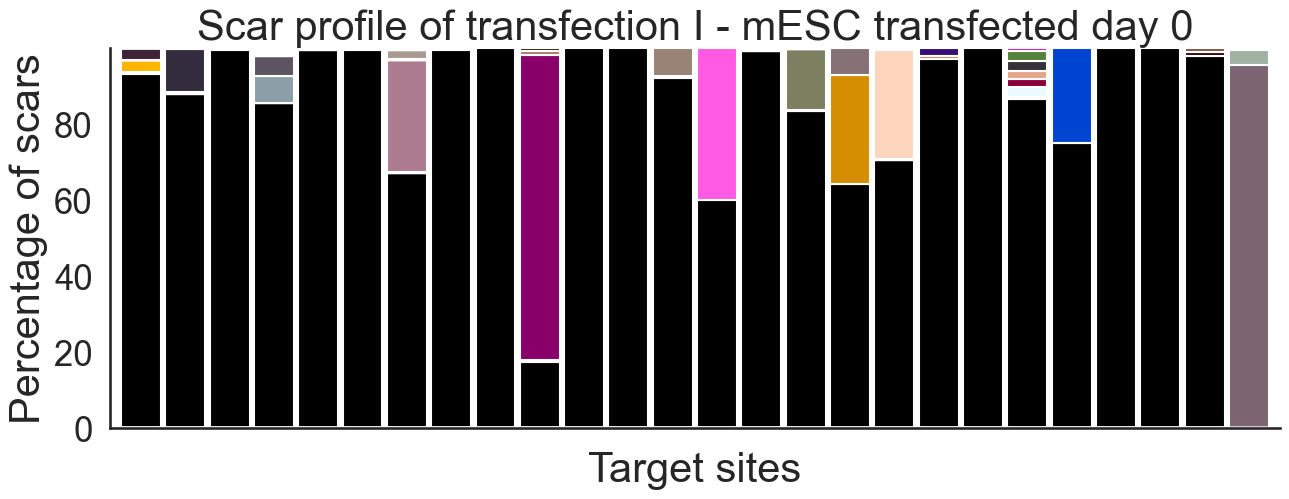

2 2601_mESC_2501_control Scar profile of transfection II - mESC control day 0


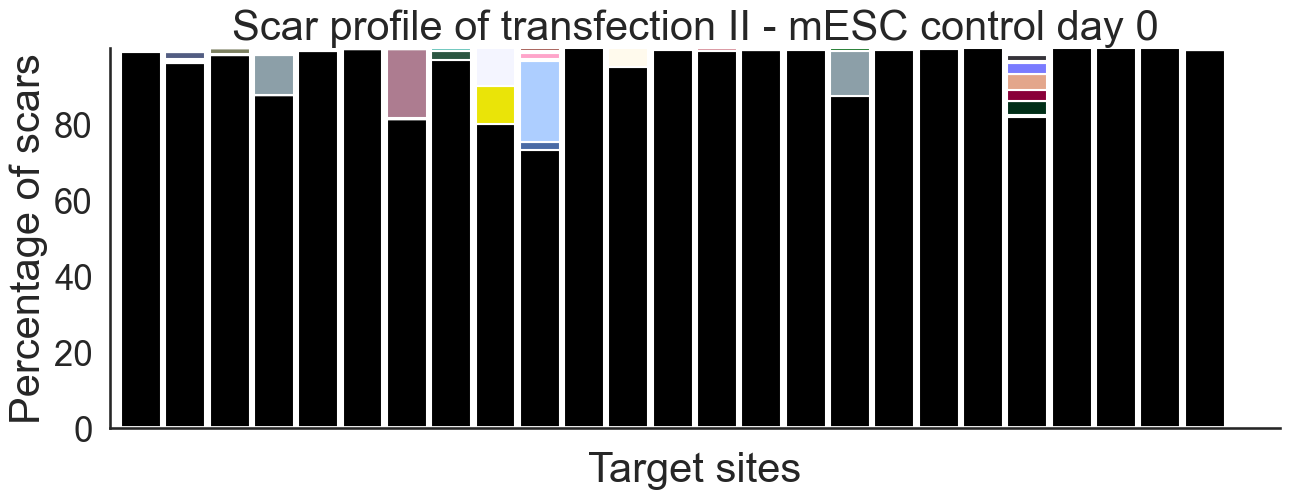

3 2601_mESC_2501_transfect Scar profile of transfection II - mESC transfected day 0


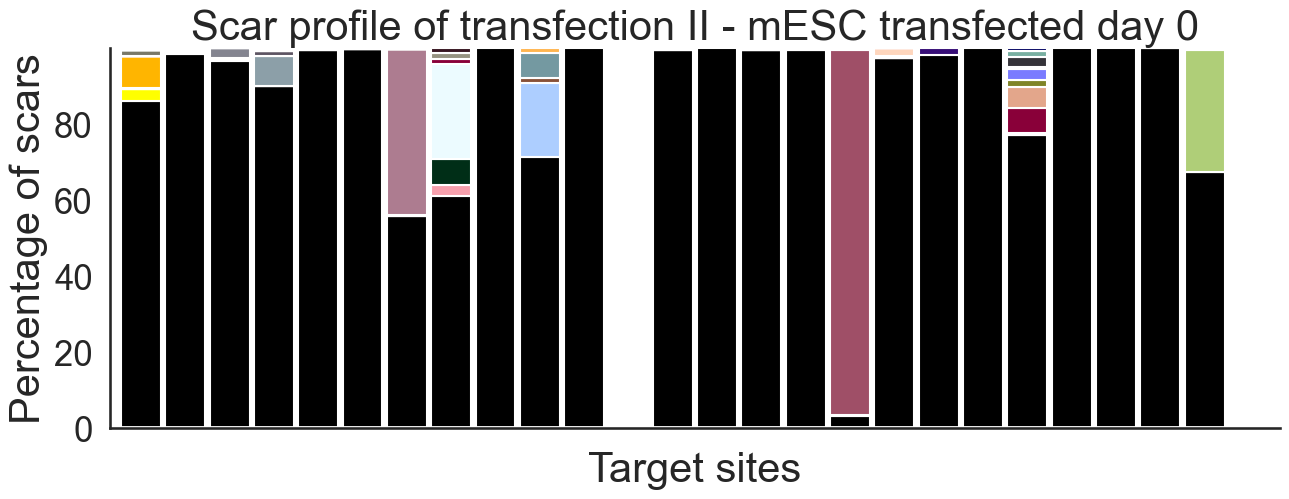

4 3101_mESC_2401_control Scar profile of transfection I - mESC control day 7


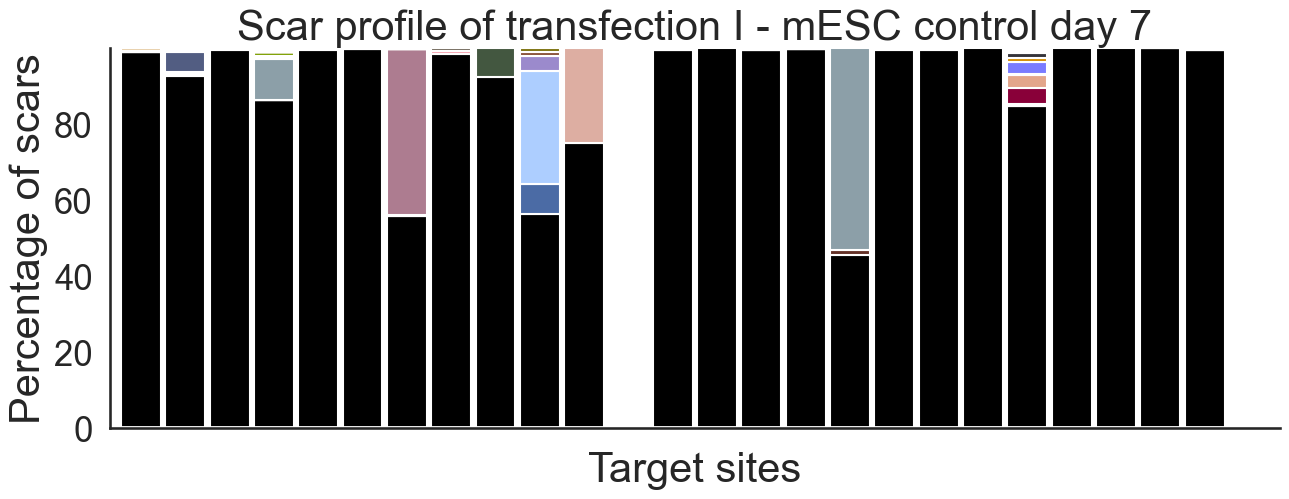

5 3101_mESC_2401_transfect Scar profile of transfection I - mESC transfected day 7


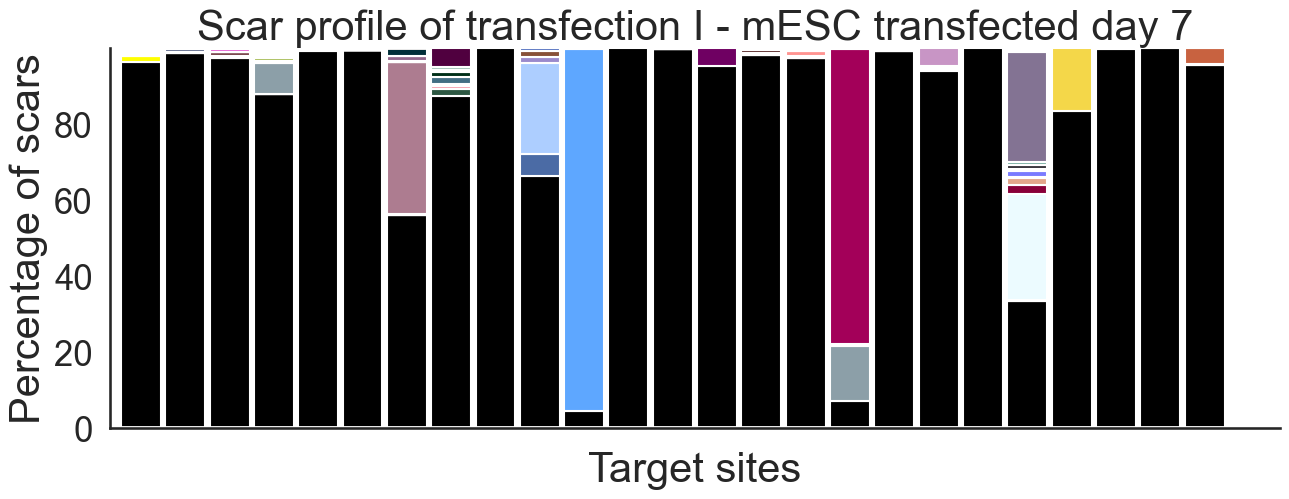

6 3101_mESC_2501_control Scar profile of transfection II - mESC control day 7


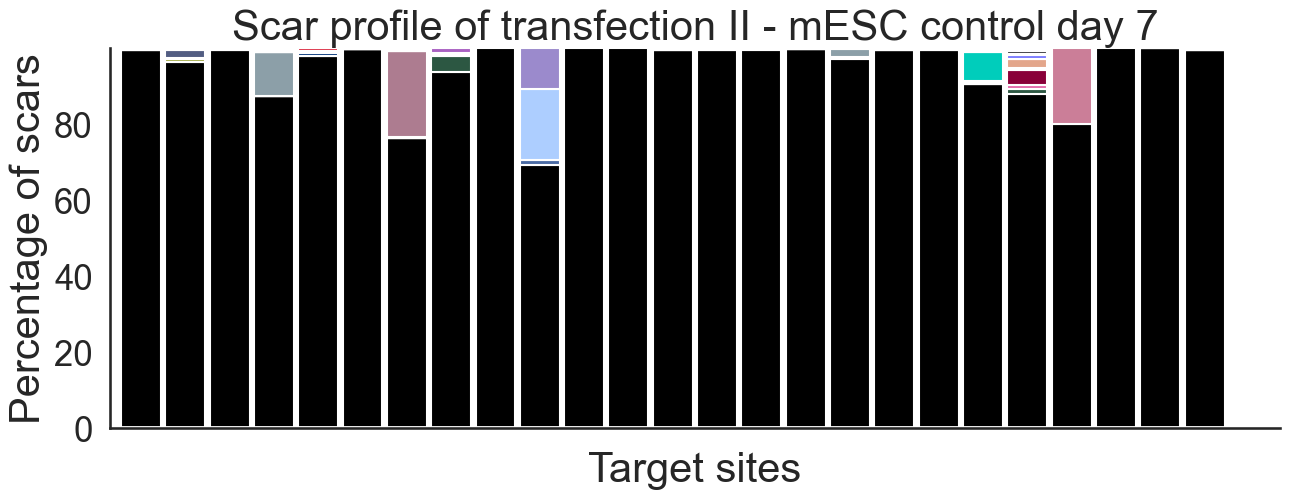

7 3101_mESC_2501_transfect Scar profile of transfection II - mESC transfected day 7


/Users/m.blotenburg/miniconda3/envs/scanpy2/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


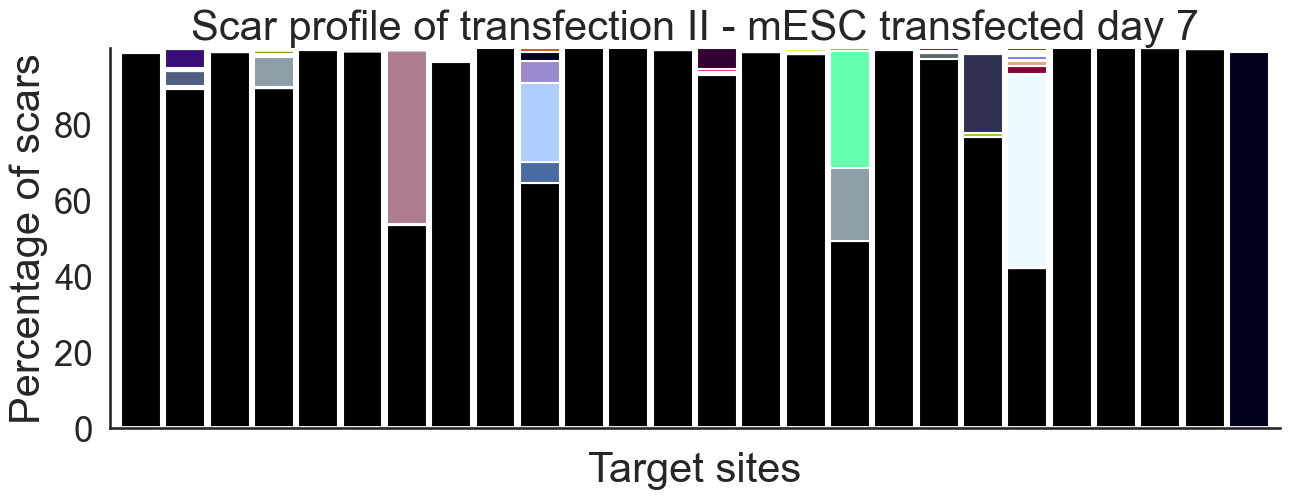

8 3101_gastr_2401_control Scar profile of transfection I - gastruloid control day 7


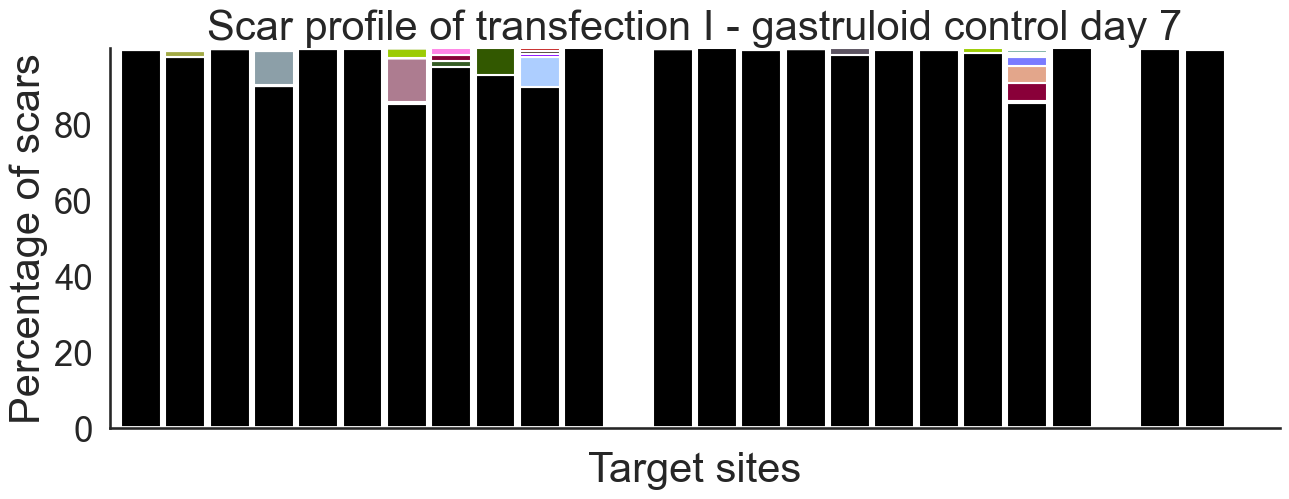

9 3101_gastr_2401_transfect Scar profile of transfection I - gastruloid transfected day 7


/Users/m.blotenburg/miniconda3/envs/scanpy2/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


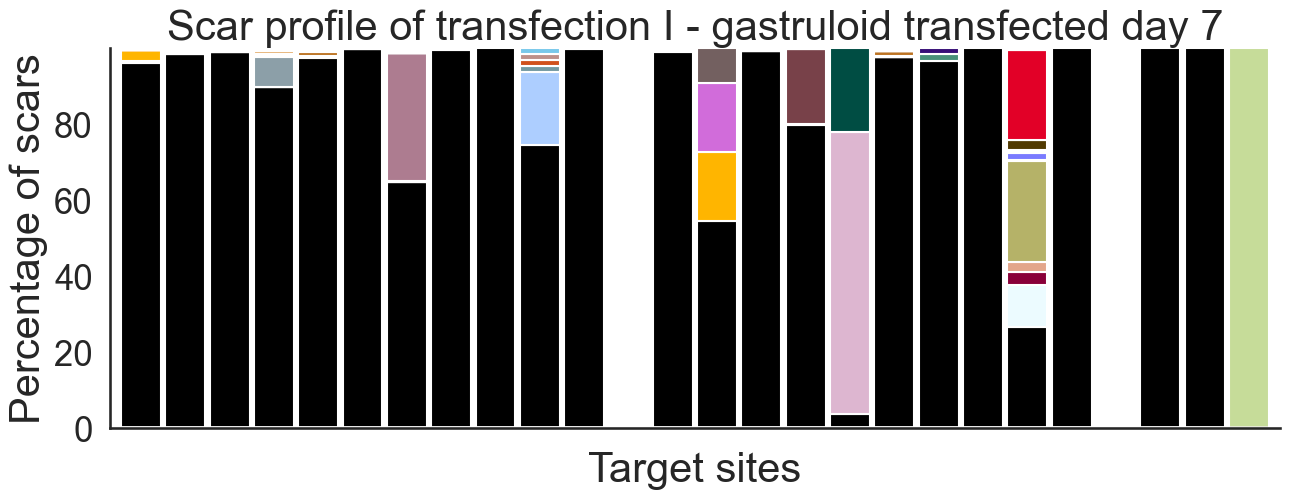

10 3101_gastr_2501_control Scar profile of transfection II - gastruloid control day 7


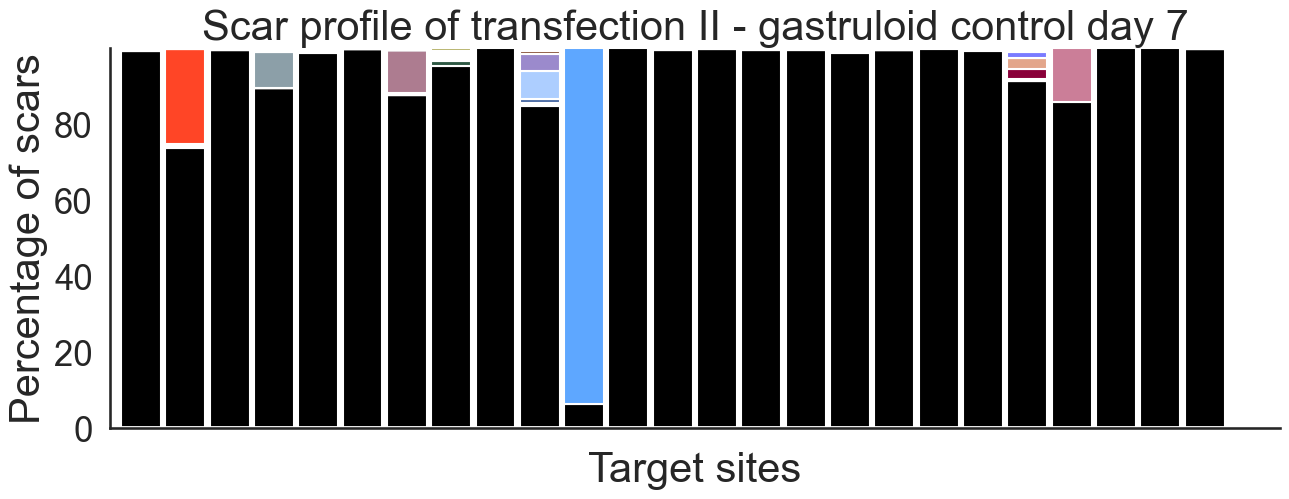

11 3101_gastr_2501_transfect Scar profile of transfection II - gastruloid transfected day 7


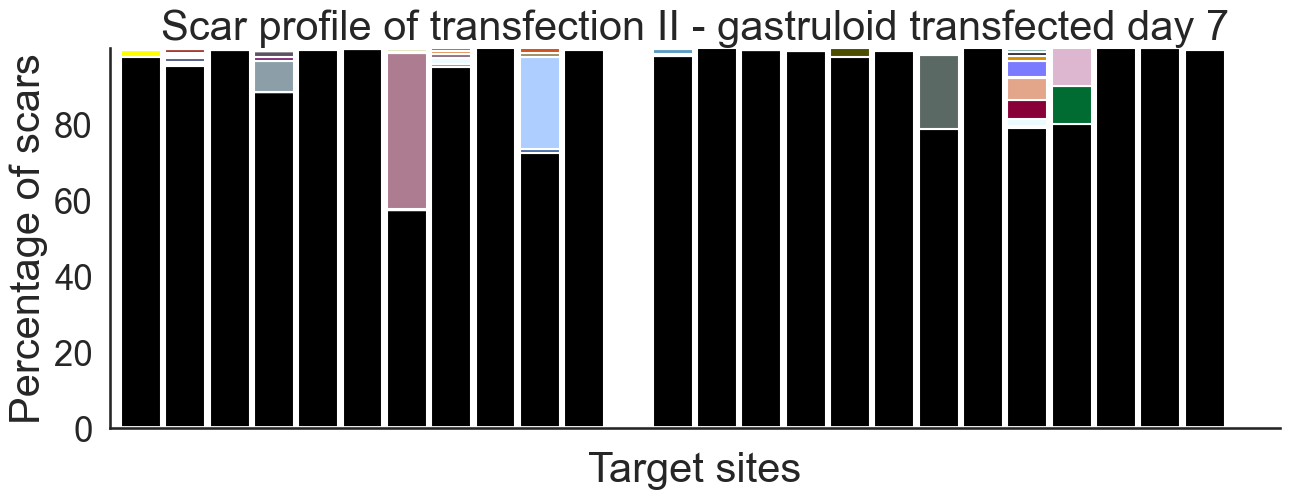

In [47]:
for nr in range(len(collapsed.columns)):
    print(nr, collapsed.columns[nr], listOfNames[nr])
    plotTargetSites(collapsed.columns[nr], title = listOfNames[nr])

In [48]:
order = [
    '2601_mESC_2401_control', '2601_mESC_2401_transfect',
       '3101_mESC_2401_control', '3101_mESC_2401_transfect',
        '3101_gastr_2401_control', '3101_gastr_2401_transfect',   
       '2601_mESC_2501_control', '2601_mESC_2501_transfect',
       '3101_mESC_2501_control', '3101_mESC_2501_transfect',
       '3101_gastr_2501_control', '3101_gastr_2501_transfect']

In [49]:

collapsed2 = collapsed.T.reindex(order)

In [50]:
collapsed3 = collapsed.T.reindex(order)

In [51]:
#collapsed.columns = 
collapsed2.index = collapsed2.index.str.replace('2.01_', '').str.replace('transfect', 'T').str.replace('3101_', '').str.replace('mESC_', 'mESCs ').str.replace('gastr_', 'Gastruloid ').str.replace('mESC_', '').str.replace('control', 'C')



/var/folders/pb/hvc2shb53x194_v0c3h_jyccsf3dhb/T/ipykernel_34166/2859778310.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  collapsed2.index = collapsed2.index.str.replace('2.01_', '').str.replace('transfect', 'T').str.replace('3101_', '').str.replace('mESC_', 'mESCs ').str.replace('gastr_', 'Gastruloid ').str.replace('mESC_', '').str.replace('control', 'C')


/Users/m.blotenburg/miniconda3/envs/scanpy2/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


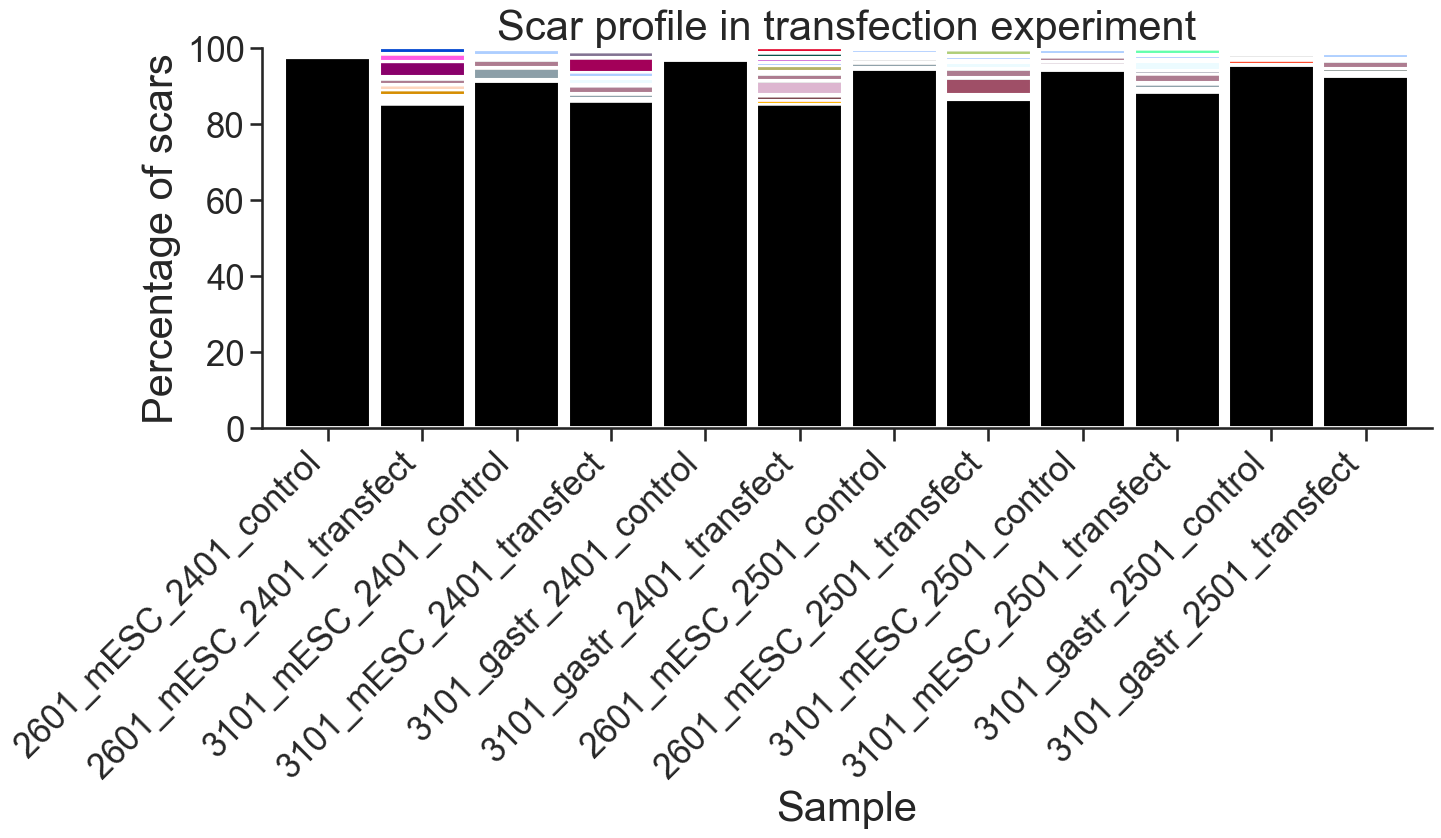

In [52]:
sns.set_style('ticks')
plotAllSamples(collapsed3, title = 'Scar profile in transfection experiment', x = 'Sample')

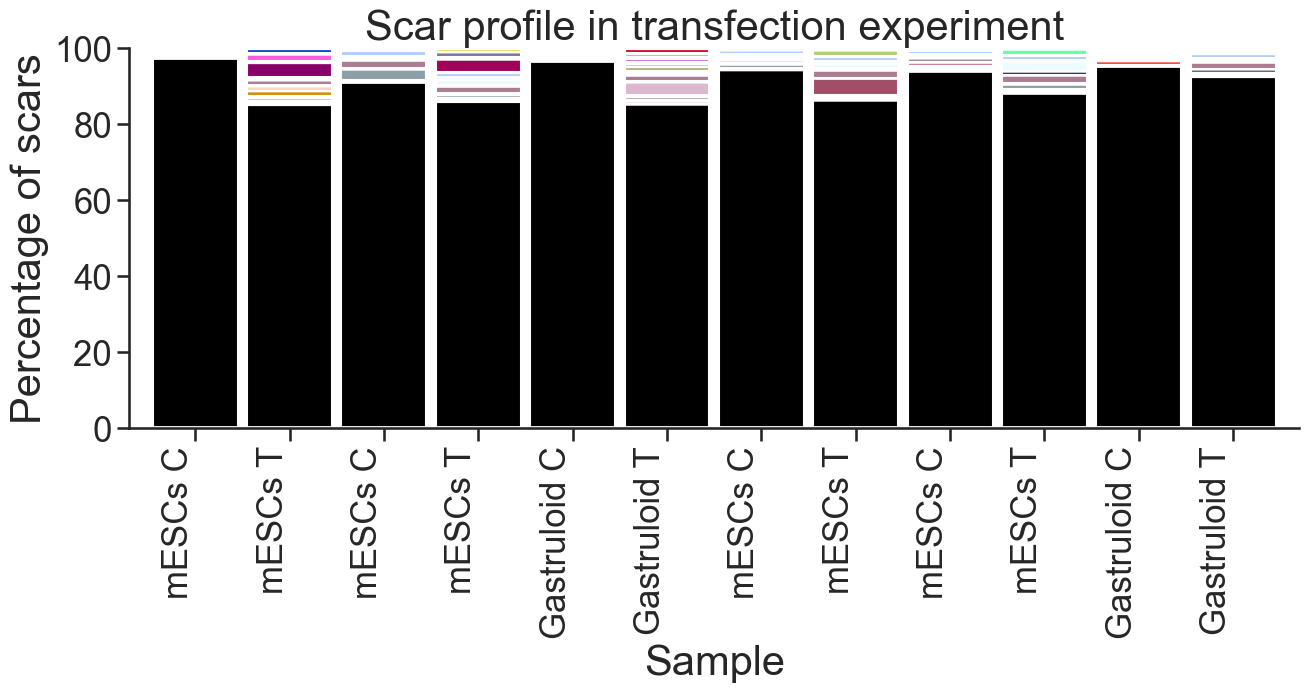

In [53]:

plotAllSamples(collapsed2, title = 'Scar profile in transfection experiment', x = 'Sample', xticks = 'rotate', rotation = 90)

In [60]:
allSites = collections.defaultdict(lambda: collections.defaultdict(collections.Counter ))
for sample in selectedpercentagesChr12_129.columns:
    for site, scar in selectedpercentagesChr12_129[sample].index:
        allSites[scar][(sample, '129', site)] = percentagesChr12_129[sample].loc[(site,scar)]

    for site, scar in selectedpercentagesChr12_B6[sample].index:
        allSites[scar][(sample, 'B6', site)] = percentagesChr12_B6[sample].loc[(site,scar)]

In [61]:
allSites = pd.DataFrame(allSites)
allSites

WT  \
2601_mESC_2401_control    129 114682733  97.816637   
                              114708749  98.056156   
                              114723873  99.674542   
                              114788473  91.585963   
                              114851291  99.514563   
...                                            ...   
3101_mESC_2501_transfect  B6  114843752        NaN   
3101_gastr_2401_control   B6  114843752        NaN   
3101_gastr_2401_transfect B6  114843752        NaN   
3101_gastr_2501_control   B6  114843752        NaN   
3101_gastr_2501_transfect B6  114843752        NaN   

                                         114682783.D,114682784.D,114682785.D,114682786.D,114682787.D  \
2601_mESC_2401_control    129 114682733                                             1.7838             
                              114708749                                                NaN             
                              114723873                                                NaN             
                              114788473                                                NaN             
                              114851291                                                NaN             
...                                                                                    ...             
3101_mESC_2501_transfect  B6  114843752                                                NaN             
3101_gastr_2401_control   B6  114843752                                                NaN             
3101_gastr_2401_transfect B6  114843752                                                NaN             
3101_gastr_2501_control   B6  114843752                                                NaN             
3101_gastr_2501_transfect B6  114843752                                                NaN             

                                         114682941.D  114682943.D  \
2601_mESC_2401_control    129 114682733     0.111626     0.056183   
                              114708749          NaN          NaN   
                              114723873          NaN          NaN   
                              114788473          NaN          NaN   
                              114851291          NaN          NaN   
...                                              ...          ...   
3101_mESC_2501_transfect  B6  114843752          NaN          NaN   
3101_gastr_2401_control   B6  114843752          NaN          NaN   
3101_gastr_2401_transfect B6  114843752          NaN          NaN   
3101_gastr_2501_control   B6  114843752          NaN          NaN   
3101_gastr_2501_transfect B6  114843752          NaN          NaN   

                                         114682945.D  114682944.D  \
2601_mESC_2401_control    129 114682733     0.050269     0.036593   
                              114708749          NaN          NaN   
                              114723873          NaN          NaN   
                              114788473          NaN          NaN   
                              114851291          NaN          NaN   
...                                              ...          ...   
3101_mESC_2501_transfect  B6  114843752          NaN          NaN   
3101_gastr_2401_control   B6  114843752          NaN          NaN   
3101_gastr_2401_transfect B6  114843752          NaN          NaN   
3101_gastr_2501_control   B6  114843752          NaN          NaN   
3101_gastr_2501_transfect B6  114843752          NaN          NaN   

                                         114682940.D  114682942.D,114682943.D  \
2601_mESC_2401_control    129 114682733     0.028091                 0.025134   
                              114708749          NaN                      NaN   
                              114723873          NaN                      NaN   
                              114788473          NaN                      NaN   
                              114851291          NaN                      NaN   
...   

In [62]:
allSites.index = allSites.index.set_levels(allSites.index.levels[2].astype(str),level=2)
allSites.index = ['_'.join(ind) for ind in allSites.index.values]
allSites2 = allSites.copy()
allSites2 = allSites2.T
newdict = {}
for sample in allSites2:
    newdict[sample] = len(allSites2[allSites2[sample] >= 0.05])
uniqueScars_scarlet = pd.DataFrame(list(newdict.items()),columns = ['full_sample','uniqueScars'])

In [75]:
WTcounts = pd.DataFrame(allSites['WT']).rename(columns={'WT':'Percentage'})
WTcounts = WTcounts.reset_index().rename(columns={'index':'full_sample'})
WTcounts = pd.merge(WTcounts, uniqueScars_scarlet, left_on='full_sample', right_on='full_sample')
scarcounts = WTcounts.copy()
scarcounts['Percentage'] = 100 - WTcounts['Percentage']
scarcounts['Type'] = 'Scar'
WTcounts['Type'] = 'WT'
WTcounts = pd.concat([WTcounts, scarcounts])
WTcounts = WTcounts[~WTcounts['Percentage'].isna()]
WTcounts['sample_name'] = WTcounts['full_sample'].str.rsplit('_', 3, expand = True)[0]
WTcounts['Day'] = WTcounts['sample_name'].str.rsplit('_', 2, expand = True)[2]
WTcounts['Replicate'] = WTcounts['full_sample'].str.rsplit('_', 3, expand = True)[1]
WTcounts['Sample'] = WTcounts['sample_name'].str.rsplit('_', 3, expand = True)[1]
WTcounts['targetsite'] = WTcounts['full_sample'].str.rsplit('_', 1, expand = True)[1]

In [76]:
WTcounts = WTcounts.sort_values(by='Day')
WTcounts_s = WTcounts[WTcounts['Type'] == 'Scar']


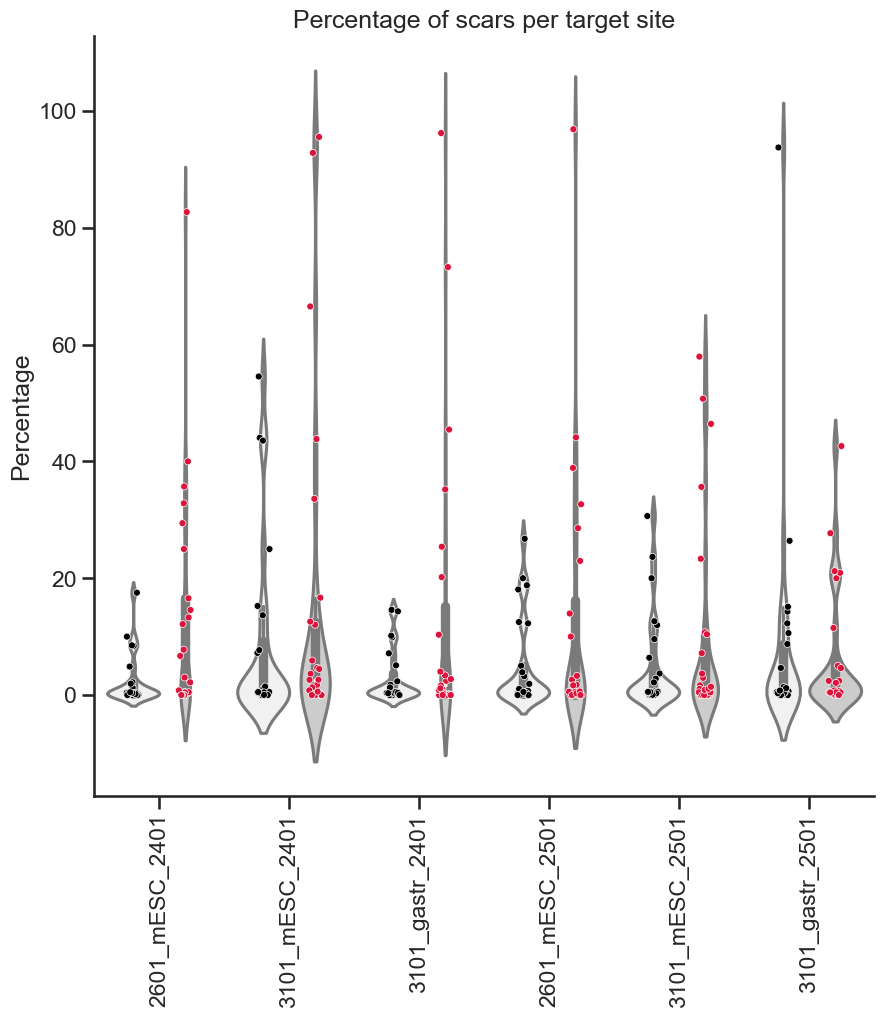

In [77]:
sc.set_figure_params(dpi=dpi, color_map = 'viridis')
sns.set_style('ticks')
sns.set_context("talk")

WTcounts = WTcounts.sort_values(by='Day')
fig, ax = plt.subplots(figsize=(10,10), dpi = dpi)
cols = ['black','crimson']

sns.violinplot(x="sample_name", y="Percentage", hue = 'Replicate', 
               data=WTcounts_s,                  
               order=['2601_mESC_2401','3101_mESC_2401','3101_gastr_2401',
                        '2601_mESC_2501','3101_mESC_2501','3101_gastr_2501'], 
               color="0.8", alpha = 0.7,bw=.20)
sns.stripplot(x="sample_name", y="Percentage", hue = 'Replicate', 
               data=WTcounts_s,                  
              order=['2601_mESC_2401','3101_mESC_2401','3101_gastr_2401',
                        '2601_mESC_2501','3101_mESC_2501','3101_gastr_2501'], 
              palette = cols, jitter=True, dodge = True,
              edgecolor='white',linewidth=0.5)

ax.set_ylabel("Percentage")
ax.set_xlabel("")
ax.set_title("Percentage of scars per target site")
ax.legend([], frameon=False)

plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
ax.tick_params(axis='x', rotation=90)
sns.despine()

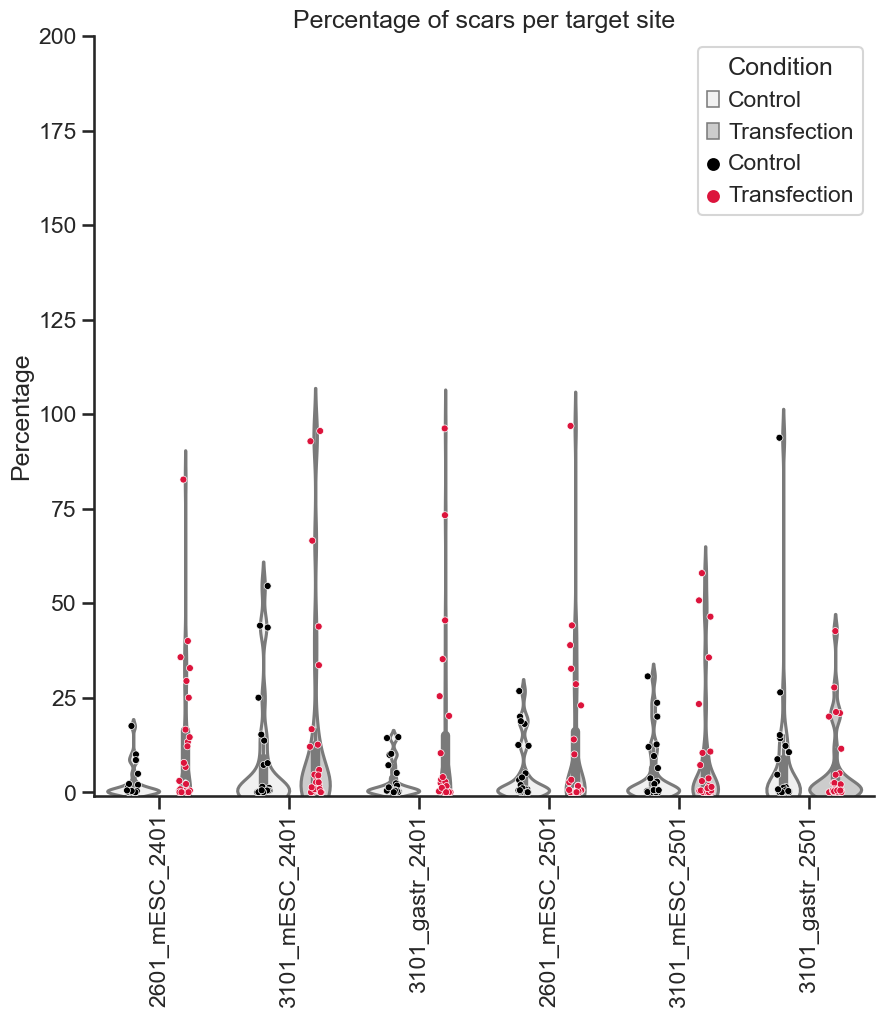

In [78]:
fig, ax = plt.subplots(figsize=(10,10), dpi = dpi)
cols = ['black','crimson']

WTcounts_s['Replicate'] = WTcounts_s['Replicate'].str.replace('control','Control')
WTcounts_s['Replicate'] = WTcounts_s['Replicate'].str.replace('transfect','Transfection')


sns.violinplot(x="sample_name", y="Percentage", hue = 'Replicate', 
               data=WTcounts_s,                  
               order=['2601_mESC_2401','3101_mESC_2401','3101_gastr_2401',
                        '2601_mESC_2501','3101_mESC_2501','3101_gastr_2501'], 
               color="0.8", alpha = 0.7,bw=.20)
sns.stripplot(x="sample_name", y="Percentage", hue = 'Replicate', 
               data=WTcounts_s,                  
              order=['2601_mESC_2401','3101_mESC_2401','3101_gastr_2401',
                        '2601_mESC_2501','3101_mESC_2501','3101_gastr_2501'], 
              palette = cols, jitter=True, dodge = True,
              edgecolor='white',linewidth=0.5)

ax.set_ylim(-1,200)
ax.set_ylabel("Percentage")
ax.set_xlabel("")
ax.set_title("Percentage of scars per target site")
ax.legend(loc = 'upper right', title = 'Condition')
ax.set_label(['x','y'])

plt.setp(ax.xaxis.get_majorticklabels(), ha='center')
ax.tick_params(axis='x', rotation=90)
sns.despine()

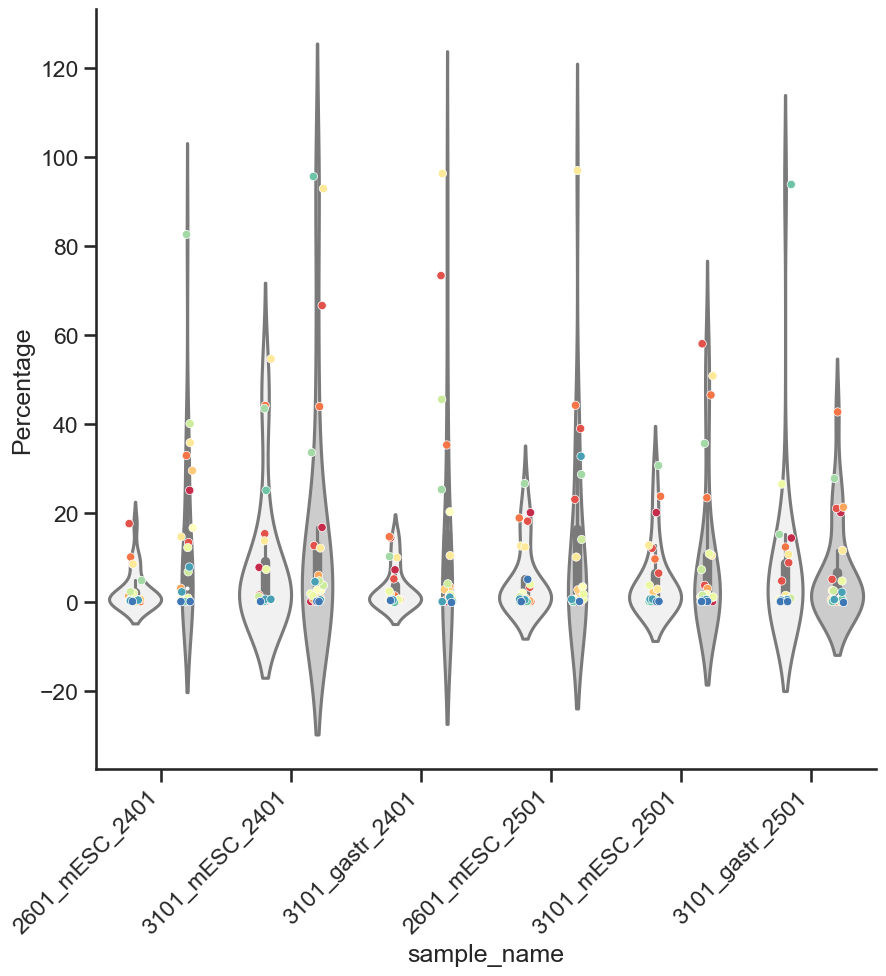

In [80]:
fig, ax1 = plt.subplots(figsize=(10,10), dpi = dpi)

ax1 = sns.violinplot(data=WTcounts_s, 
                     x="sample_name", y="Percentage", hue = 'Replicate', 
                     order=['2601_mESC_2401','3101_mESC_2401','3101_gastr_2401',
                        '2601_mESC_2501','3101_mESC_2501','3101_gastr_2501'], 
                  color = "0.8")

hatches = ['', '//']
for bars, hatch in zip(ax1.containers, hatches):
    for bar in bars:
        bar.set_hatch(hatch)
for ts, color in zip(WTcounts_s['targetsite'].unique(), sns.color_palette("Spectral",len(WTcounts_s['targetsite'].unique()))):
    df_per_ts = WTcounts_s[WTcounts_s['targetsite'] == ts]
    sns.stripplot(data=df_per_ts, 
                  x="sample_name", y="Percentage", hue = 'Replicate',
                  order=['2601_mESC_2401','3101_mESC_2401','3101_gastr_2401',
                        '2601_mESC_2501','3101_mESC_2501','3101_gastr_2501'], 
                  dodge=True, palette=[color] * 2,
                  marker='o', size=6, edgecolor='white', 
                  linewidth=0.5)
ax1.legend([], frameon=False)

plt.setp(ax1.xaxis.get_majorticklabels(), ha='right')
ax1.tick_params(axis='x', rotation=45)

sns.despine()

In [123]:
cols = ['black',"#C895C5", "#320033", "#FF6832", "#66E1D3", "#CFCDAC", "#D0AC94", "#7ED379", "#012C58",
    "#008941", "#FFFF00", "#1CE6FF", "#FF34FF", "#FF4A46", "#006FA6", "#A30059",
    "#FFDBE5", "#7A4900", "#0000A6", "#63FFAC", "#B79762", "#004D43", "#8FB0FF", "#997D87",
    "#5A0007", "#809693", "#FEFFE6", "#1B4400", "#4FC601", "#3B5DFF", "#4A3B53", "#FF2F80",
    "#61615A", "#BA0900", "#6B7900", "#00C2A0", "#FFAA92", "#FF90C9", "#B903AA", "#D16100",
    
    "#7A7BFF", "#D68E01", "#353339", "#78AFA1", "#FEB2C6", "#75797C", "#837393", "#943A4D",
    "#B5F4FF", "#D2DCD5", "#9556BD", "#6A714A", "#001325", "#02525F", "#0AA3F7", "#E98176",
    "#DBD5DD", "#5EBCD1", "#3D4F44", "#7E6405", "#02684E", "#962B75", "#8D8546", "#9695C5",
    "#E773CE", "#D86A78", "#3E89BE", "#CA834E", "#518A87", "#5B113C", "#55813B", "#E704C4",
    "#00005F", "#A97399", "#4B8160", "#59738A", "#FF5DA7", "#F7C9BF", "#643127", "#513A01",
      
        "#83AB58", "#001C1E", "#D1F7CE", "#004B28", "#C8D0F6", "#A3A489", "#806C66", "#222800",
    "#BF5650", "#E83000", "#66796D", "#DA007C", "#FF1A59", "#8ADBB4", "#1E0200", "#5B4E51",
    
    
              "#7900D7", "#A77500", "#6367A9", "#A05837", "#6B002C", "#772600", "#D790FF", "#9B9700",
    "#549E79", "#FFF69F", "#201625", "#72418F", "#BC23FF", "#99ADC0", "#3A2465", "#922329",
    "#5B4534", "#FDE8DC", "#404E55", "#0089A3", "#CB7E98", "#A4E804", "#324E72", "#6A3A4C",
    
    "#DDEFFF", "#000035", "#7B4F4B", "#A1C299", "#300018", "#0AA6D8", "#013349", "#00846F",
    "#372101", "#FFB500", "#C2FFED", "#A079BF", "#CC0744", "#C0B9B2", "#C2FF99", "#001E09",
    "#00489C", "#6F0062", "#0CBD66", "#EEC3FF", "#456D75", "#B77B68", "#7A87A1", "#788D66",
    "#885578", "#FAD09F", "#FF8A9A", "#D157A0", "#BEC459", "#456648", "#0086ED", "#886F4C",
    "#34362D", "#B4A8BD", "#00A6AA", "#452C2C", "#636375", "#A3C8C9", "#FF913F", "#938A81",
    "#575329", "#00FECF", "#B05B6F", "#8CD0FF", "#3B9700", "#04F757", "#C8A1A1", "#1E6E00",


    "#BDC9D2", "#9FA064", "#BE4700", "#658188", "#83A485", "#453C23", "#47675D", "#3A3F00",
    "#061203", "#DFFB71", "#868E7E", "#98D058", "#6C8F7D", "#D7BFC2", "#3C3E6E", "#D83D66",
    "#2F5D9B", "#6C5E46", "#D25B88", "#5B656C", "#00B57F", "#545C46", "#866097", "#365D25",
    "#252F99", "#00CCFF", "#674E60", "#FC009C", "#92896B", "#1E2324", "#DEC9B2", "#9D4948",
    "#85ABB4", "#342142", "#D09685", "#A4ACAC", "#00FFFF", "#AE9C86", "#742A33", "#0E72C5",
    "#AFD8EC", "#C064B9", "#91028C", "#FEEDBF", "#FFB789", "#9CB8E4", "#AFFFD1", "#2A364C",
    "#4F4A43", "#647095", "#34BBFF", "#807781", "#920003", "#B3A5A7", "#018615", "#F1FFC8",
    "#976F5C", "#FF3BC1", "#FF5F6B", "#077D84", "#F56D93", "#5771DA", "#4E1E2A", "#830055",
    "#02D346", "#BE452D", "#00905E", "#BE0028", "#6E96E3", "#007699", "#FEC96D", "#9C6A7D",
    "#3FA1B8", "#893DE3", "#79B4D6", "#7FD4D9", "#6751BB", "#B28D2D", "#E27A05", "#DD9CB8",
    "#AABC7A", "#980034", "#561A02", "#8F7F00", "#635000", "#CD7DAE", "#8A5E2D", "#FFB3E1",
    "#6B6466", "#C6D300", "#0100E2", "#88EC69", "#8FCCBE", "#21001C", "#511F4D", "#E3F6E3",
    "#FF8EB1", "#6B4F29", "#A37F46", "#6A5950", "#1F2A1A", "#04784D", "#101835", "#E6E0D0",
    "#FF74FE", "#00A45F", "#8F5DF8", "#4B0059", "#412F23", "#D8939E", "#DB9D72", "#604143",
    "#B5BACE", "#989EB7", "#D2C4DB", "#A587AF", "#77D796", "#7F8C94", "#FF9B03", "#555196",
    "#31DDAE", "#74B671", "#802647", "#2A373F", "#014A68", "#696628", "#4C7B6D", "#002C27",
    "#7A4522", "#3B5859", "#E5D381", "#FFF3FF", "#679FA0", "#261300", "#2C5742", "#9131AF",
    "#AF5D88", "#C7706A", "#61AB1F", "#8CF2D4", "#C5D9B8", "#9FFFFB", "#BF45CC", "#493941"]